# Clusterless Decoding

## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- This tutorial assumes you've already 
  [extracted marks](./31_Extract_Mark_Indicators.ipynb), as well as loaded 
  position data. If 1D decoding, this data should also be
  [linearized](./24_Linearization.ipynb).
- This tutorial also assumes you're familiar with how to run processes on GPU, 
  as presented in [this notebook](./32_Decoding_with_GPUs.ipynb)

Clusterless decoding can be performed on either 1D or 2D data. A few steps in
this notebook will refer to a `decode_1d` variable set in 
[select data](#select-data) to include these steps.


## Imports


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import datajoint as dj
import matplotlib.pyplot as plt
import logging
import cupy as cp

from pprint import pprint


logging.basicConfig(
    level="INFO", format="%(asctime)s %(message)s", datefmt="%d-%b-%y %H:%M:%S"
)

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.common.common_position as sgc_pos
import spyglass.common.interval as sgc_int
import spyglass.decoding.clusterless as sgd_clusterless
import spyglass.decoding.visualization as sgd_viz
import replay_trajectory_classification as rtc
import replay_trajectory_classification.environments as rtc_env


# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

[2023-08-01 11:16:06,882][INFO]: Connecting root@localhost:3306
[2023-08-01 11:16:06,909][INFO]: Connected root@localhost:3306


## Select data

In [4]:
nwb_copy_file_name = "chimi20200216_new_.nwb"
decode_1d = True

## `UnitMarksIndicator`


First, we'll fetch marks with `fetch_xarray`, which provides a labeled array of
shape (n_time, n_mark_features, n_electrodes). Time is in 2 ms bins with either
`NaN` if no spike occurred or the value of the spike features.

If there is >1 spike per time bin per tetrode, we take an an average of the
marks. Ideally, we would use all the marks, this is a rare occurrence and
decoding is generally robust to the averaging.

In [10]:
marks = (
    sgd_clusterless.UnitMarksIndicator
    & {
        "nwb_file_name": nwb_copy_file_name,
        "sort_interval_name": "runs_noPrePostTrialTimes raw data valid times",
        "filter_parameter_set_name": "franklab_default_hippocampus",
        "unit_inclusion_param_name": "all2",
        "mark_param_name": "default",
        "interval_list_name": "pos 1 valid times",
        "sampling_rate": 500,
    }
).fetch_xarray()

marks

/stelmo/nwb/analysis/chimi20200216_new_7M0E8ERPE7.nwb
/stelmo/nwb/analysis/chimi20200216_new_6WW86B509M.nwb
/stelmo/nwb/analysis/chimi20200216_new_TLD0MCIC5H.nwb
/stelmo/nwb/analysis/chimi20200216_new_7BEQDOTX3E.nwb
/stelmo/nwb/analysis/chimi20200216_new_F8QVNUMVJS.nwb
/stelmo/nwb/analysis/chimi20200216_new_BVZKYWREUE.nwb
/stelmo/nwb/analysis/chimi20200216_new_3HMJON557D.nwb
/stelmo/nwb/analysis/chimi20200216_new_QGMZ5ESFVA.nwb
/stelmo/nwb/analysis/chimi20200216_new_1KRVBBCP2N.nwb
/stelmo/nwb/analysis/chimi20200216_new_9E2Z0R6TLO.nwb
/stelmo/nwb/analysis/chimi20200216_new_ALRF0STB1P.nwb
/stelmo/nwb/analysis/chimi20200216_new_F2TDZW8LRY.nwb
/stelmo/nwb/analysis/chimi20200216_new_LTEU71Z21T.nwb
/stelmo/nwb/analysis/chimi20200216_new_KT4E4LIYAI.nwb
/stelmo/nwb/analysis/chimi20200216_new_KOIRLX6R6X.nwb
/stelmo/nwb/analysis/chimi20200216_new_4S01EA6NVN.nwb
/stelmo/nwb/analysis/chimi20200216_new_ATQO860QOB.nwb
/stelmo/nwb/analysis/chimi20200216_new_H3E2HYMEJA.nwb
/stelmo/nwb/analysis/chimi20

<xarray.DataArray (time: 655645, marks: 4, electrodes: 22)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       ...,

       [[ -99.,   nan,   nan, ...,   nan,   nan,   nan],
        [-100.,   nan,   nan, ...,   nan,   nan,   nan],
        [ -94.,   nan,   nan, ...,   nan,   nan,   nan],
        [-104.,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]])
Coordinates:
  * time        (time) float64 1.582e+09 1.582e+09 ... 1.582e+09 1.582e+09
  * marks       (marks) <U14 'amplitude_0000' ... 'amplitude_0003'
  * electrodes  (electrodes) int64 0 1 2 3 5 6 7 8 9 ... 15 16 17 18 19 21 22 23

We'll use `UnitMarksIndicator.plot_all_marks` to make sure our marks look right.
This will plot each mark feature against the other for each electrode. We check
for items that look overly correlated (strong diagonal on the off-diagonal
plots) and extreme amplitudes.

For tutorial purposes, we only look at the first 2 plots, but removing this 
argument will show all plots.

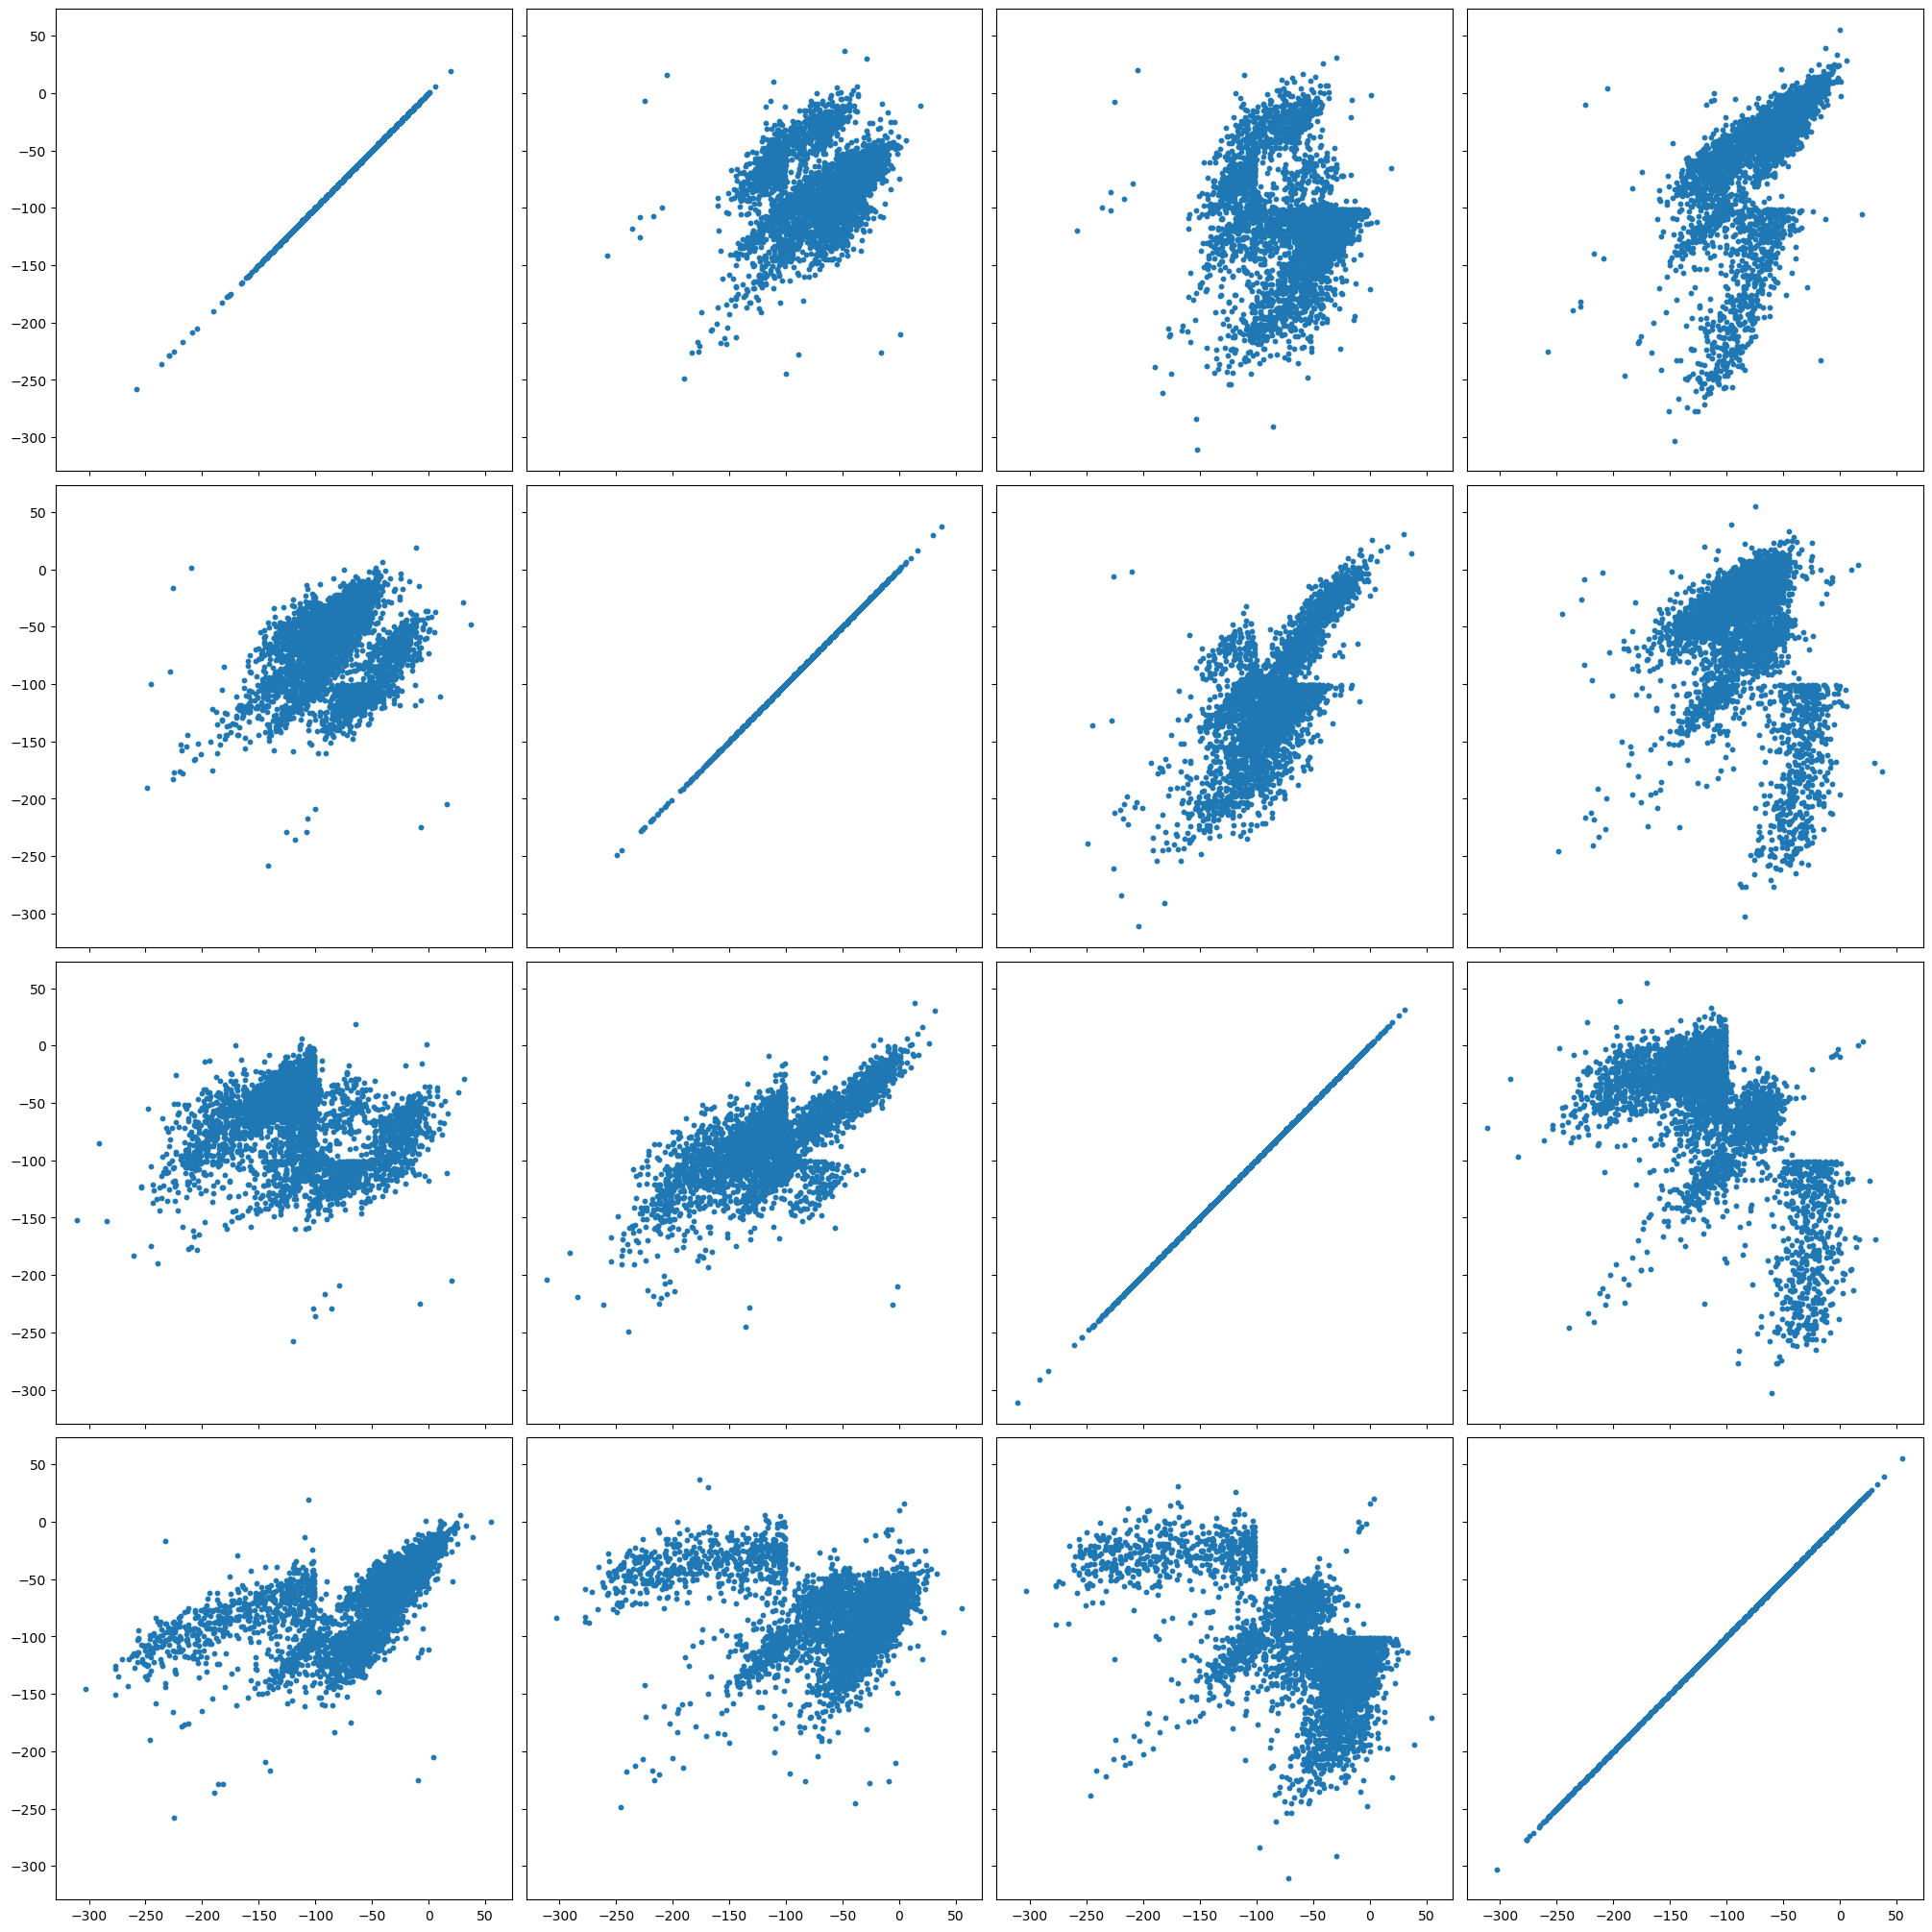

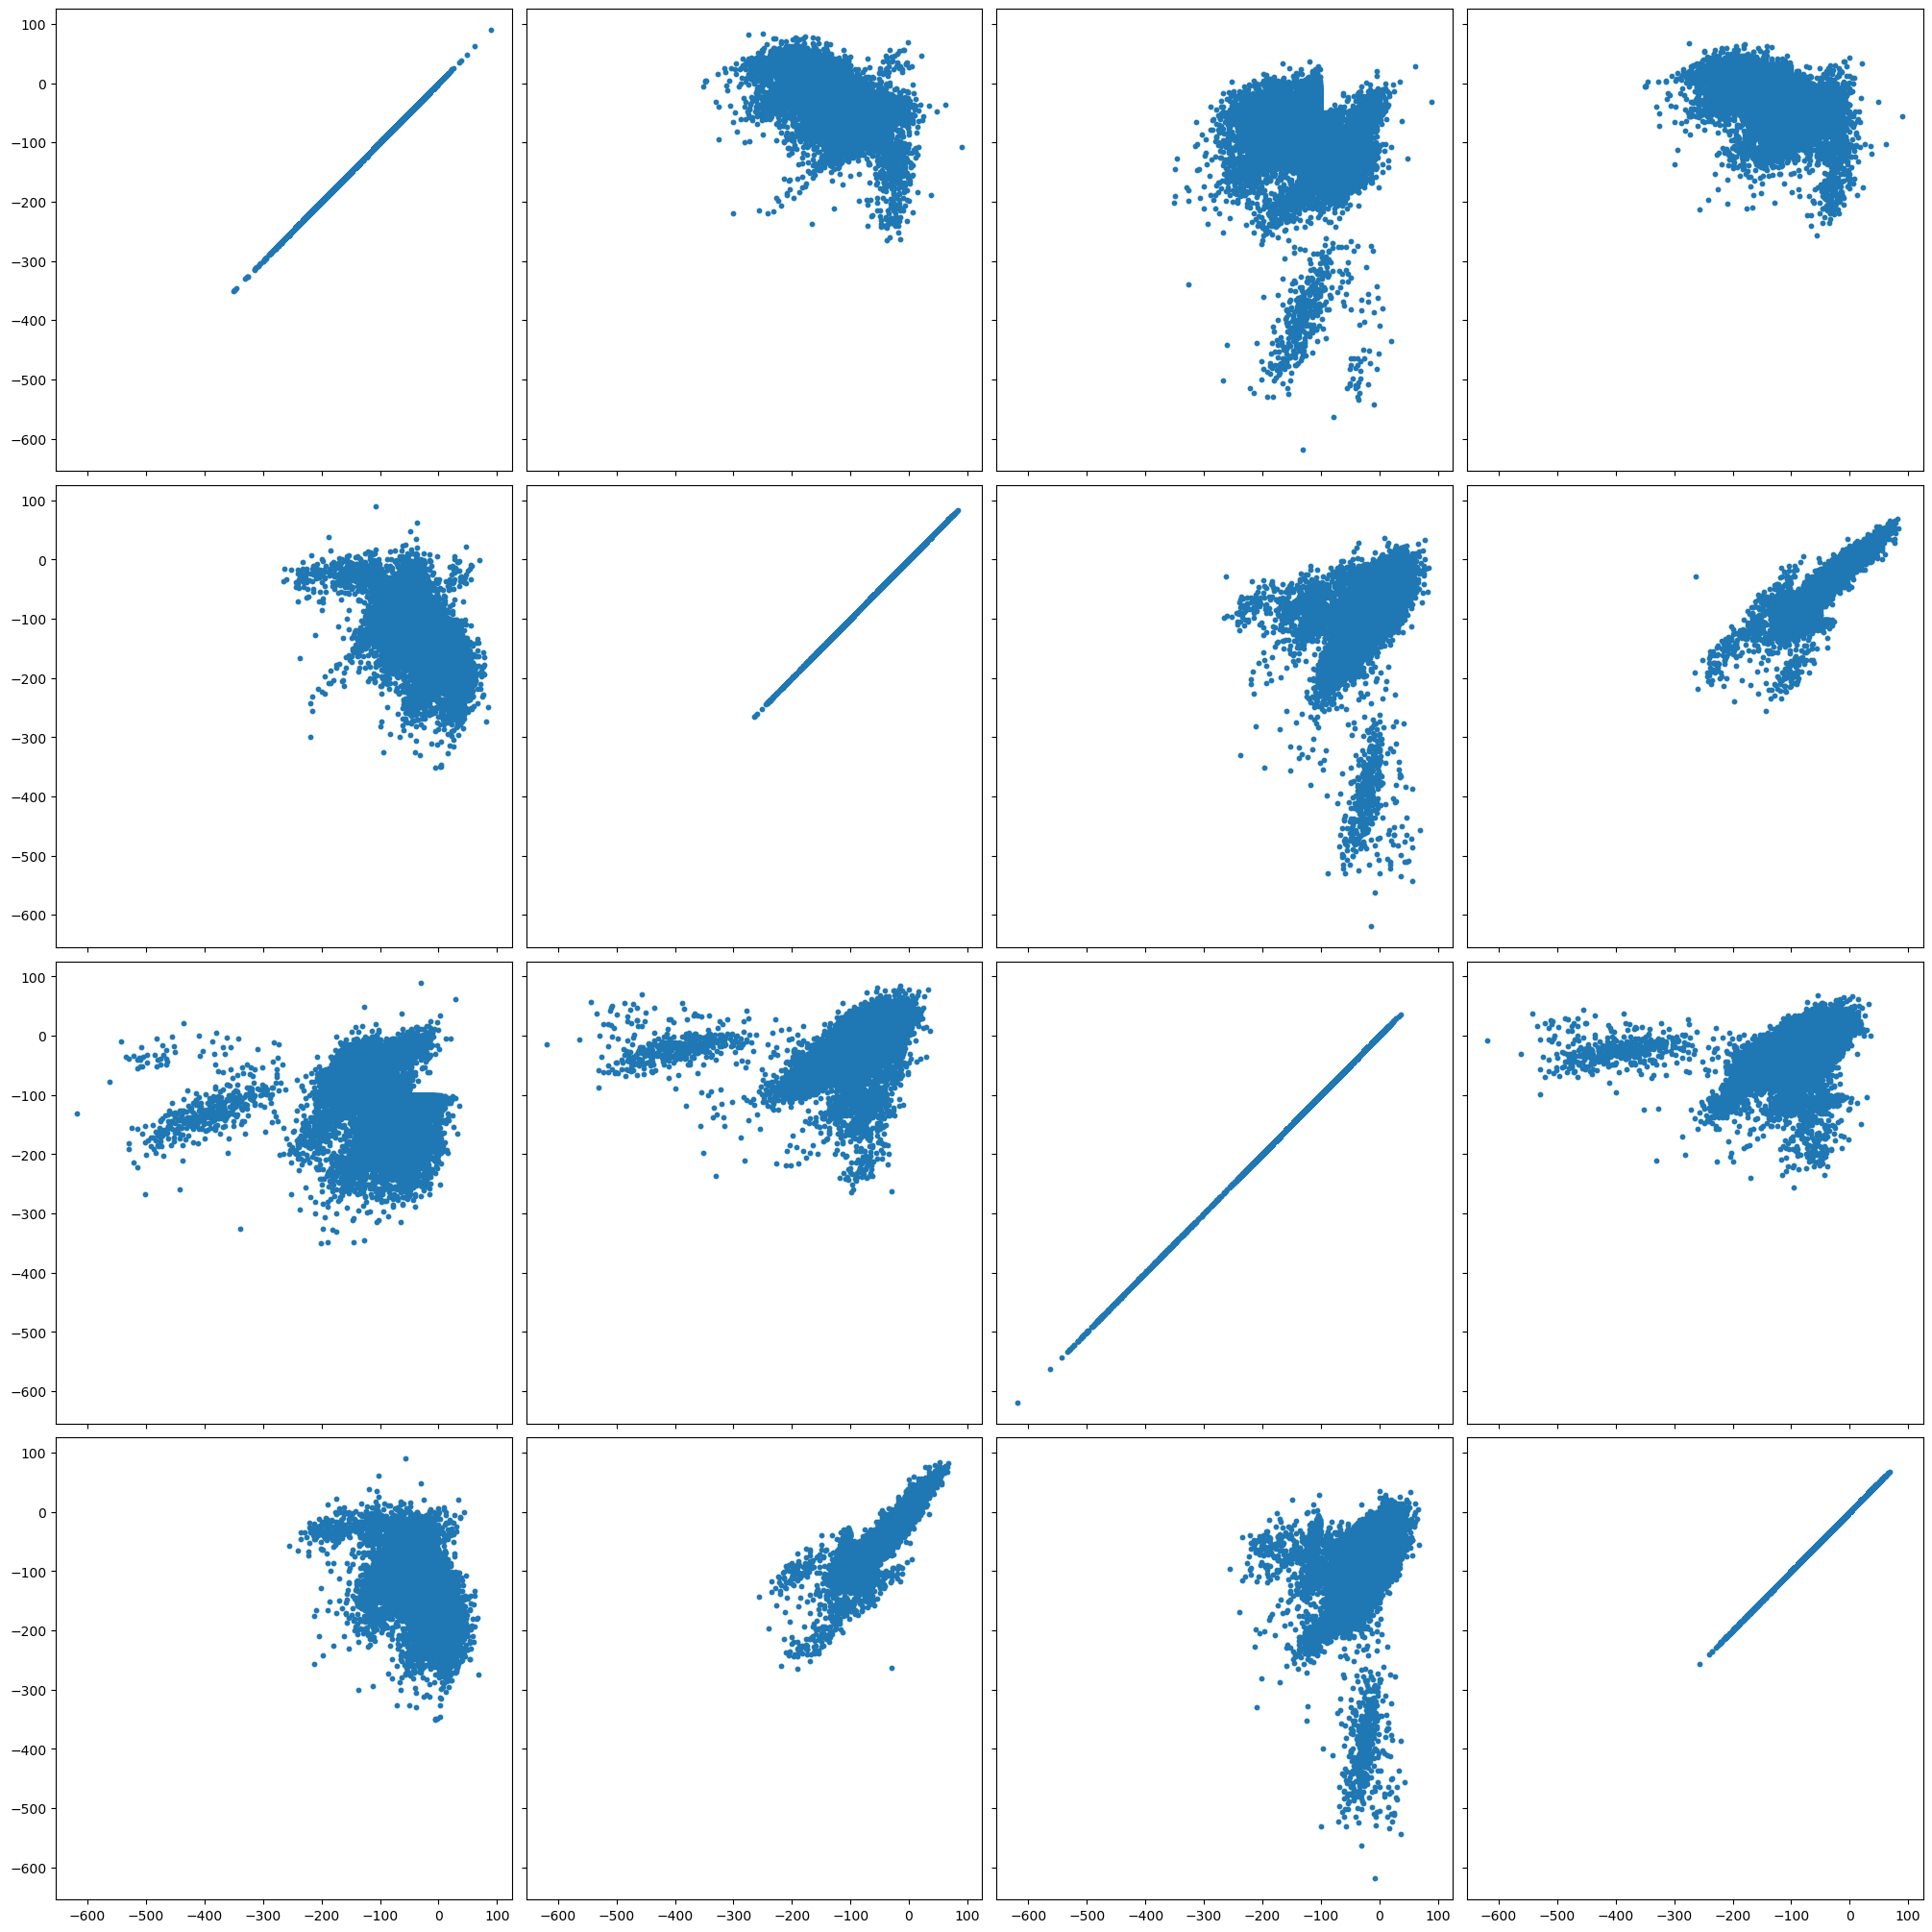

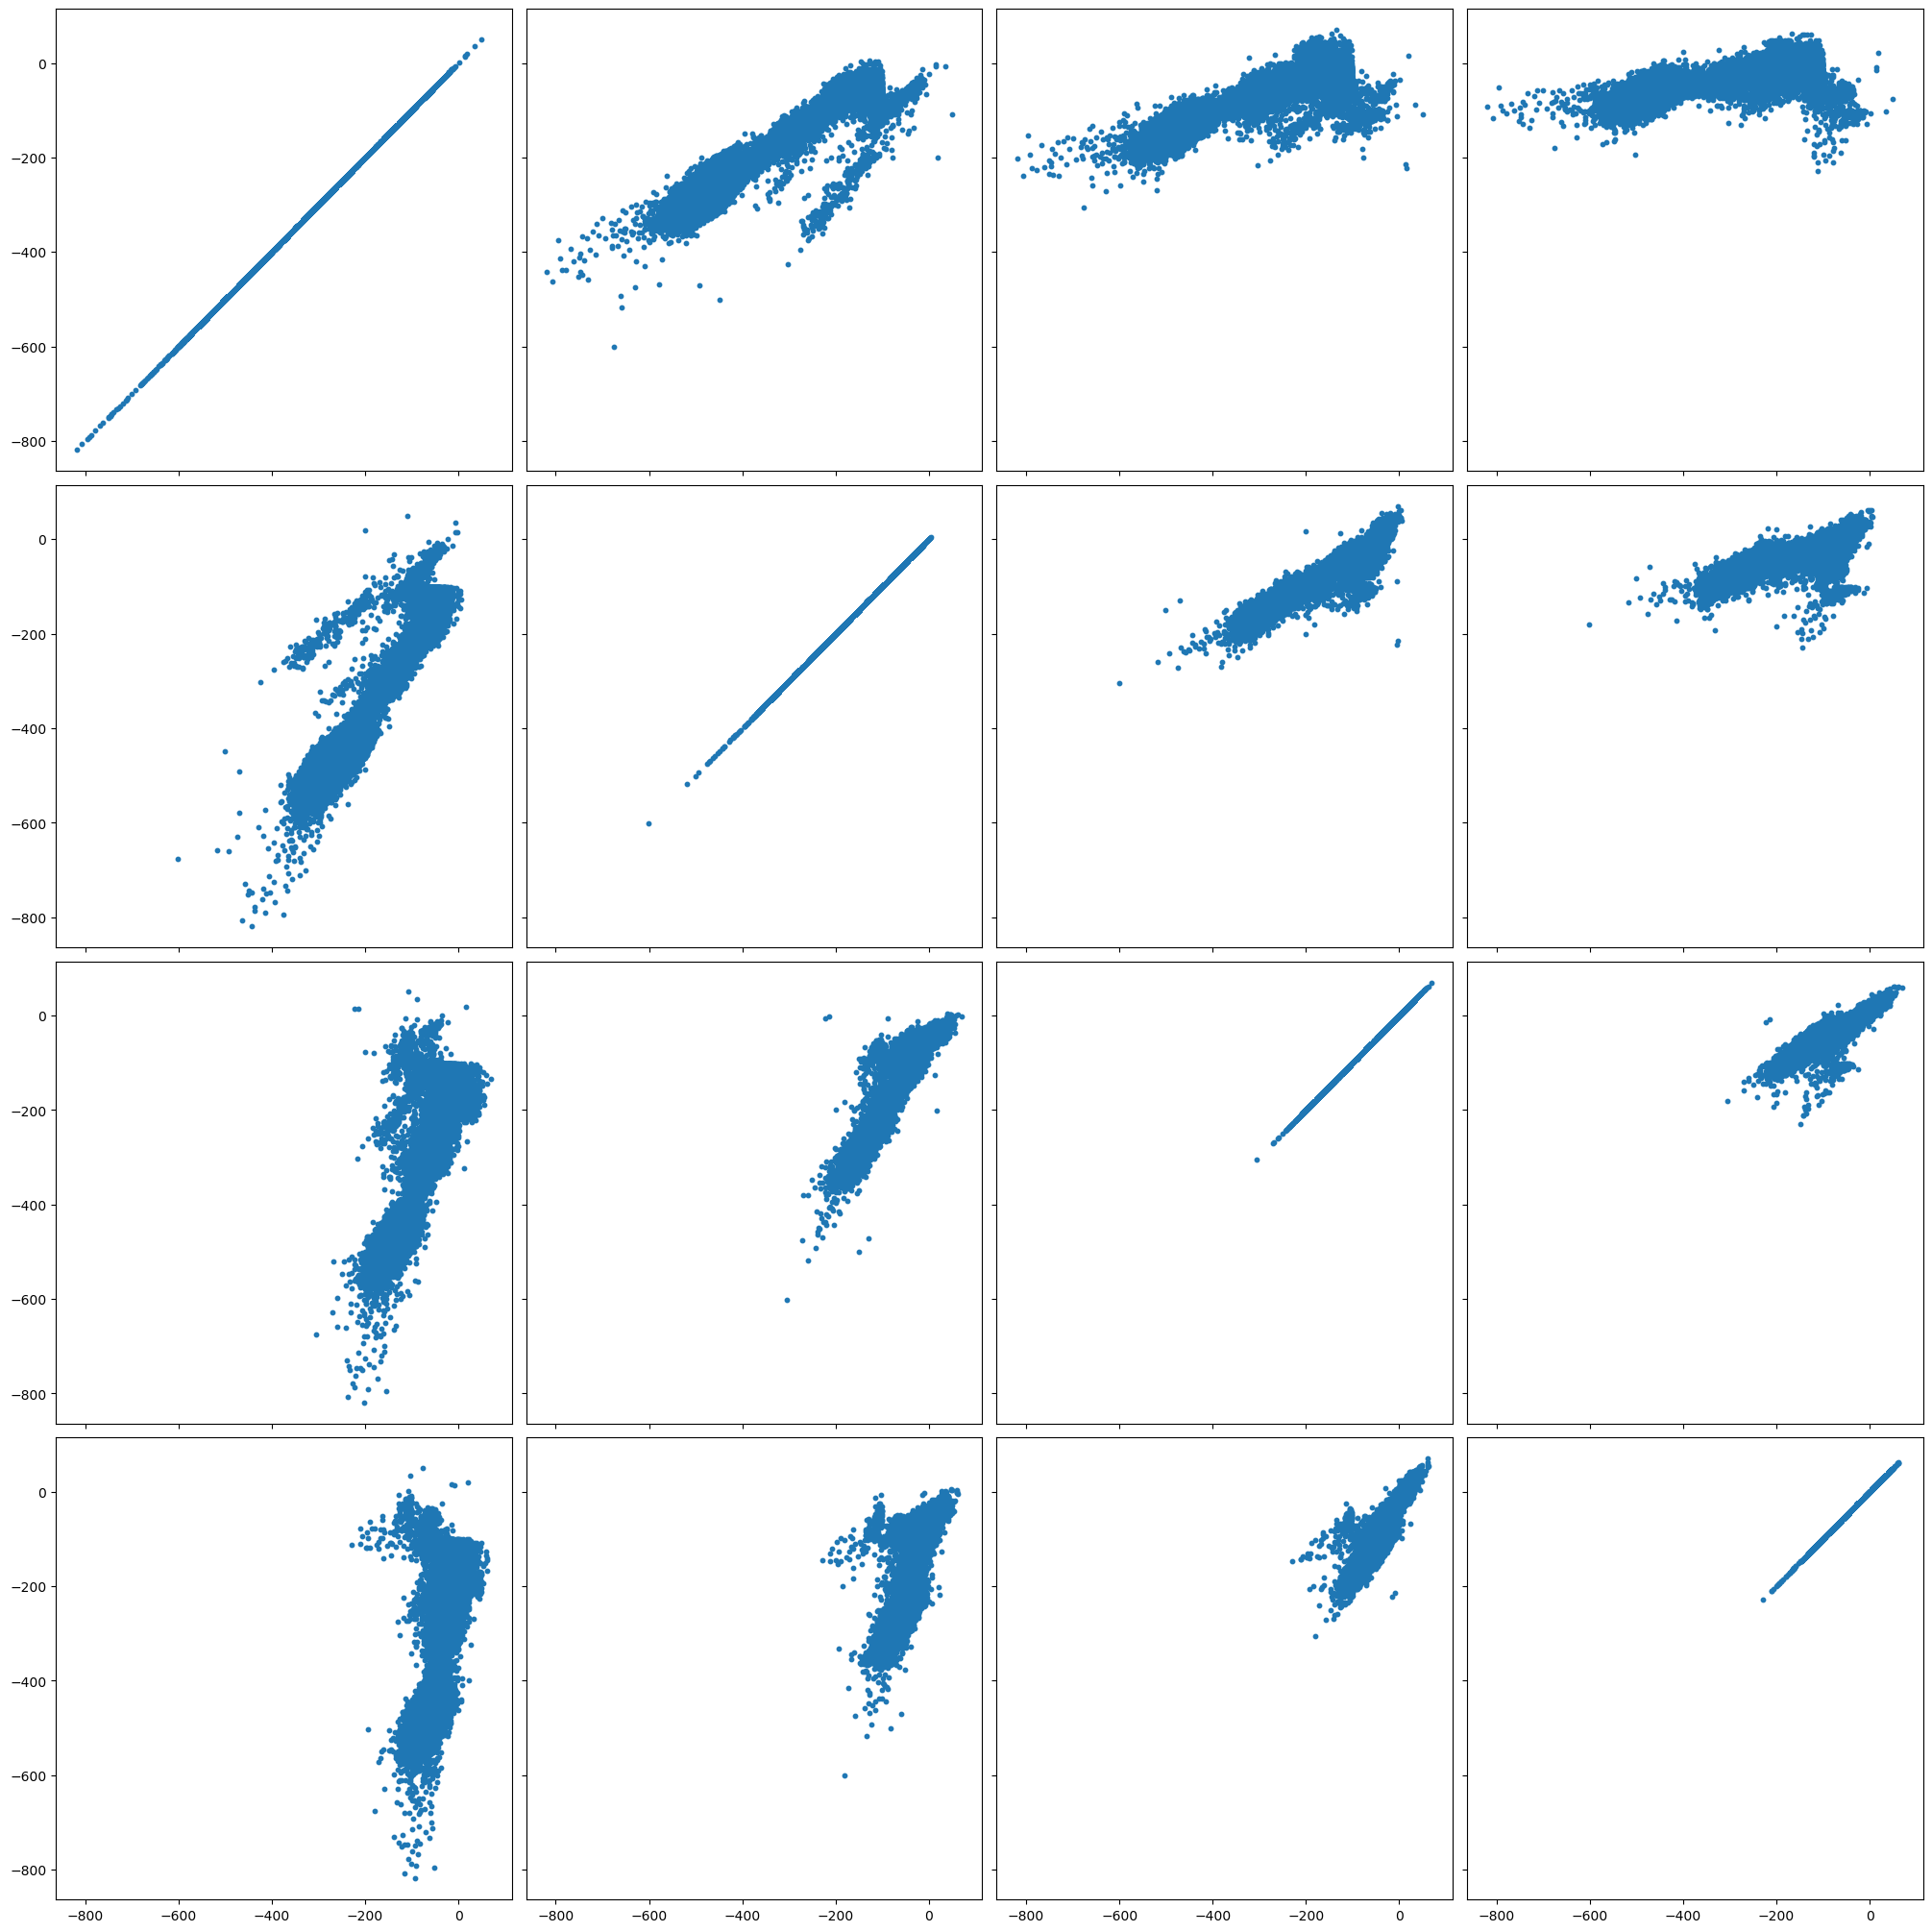

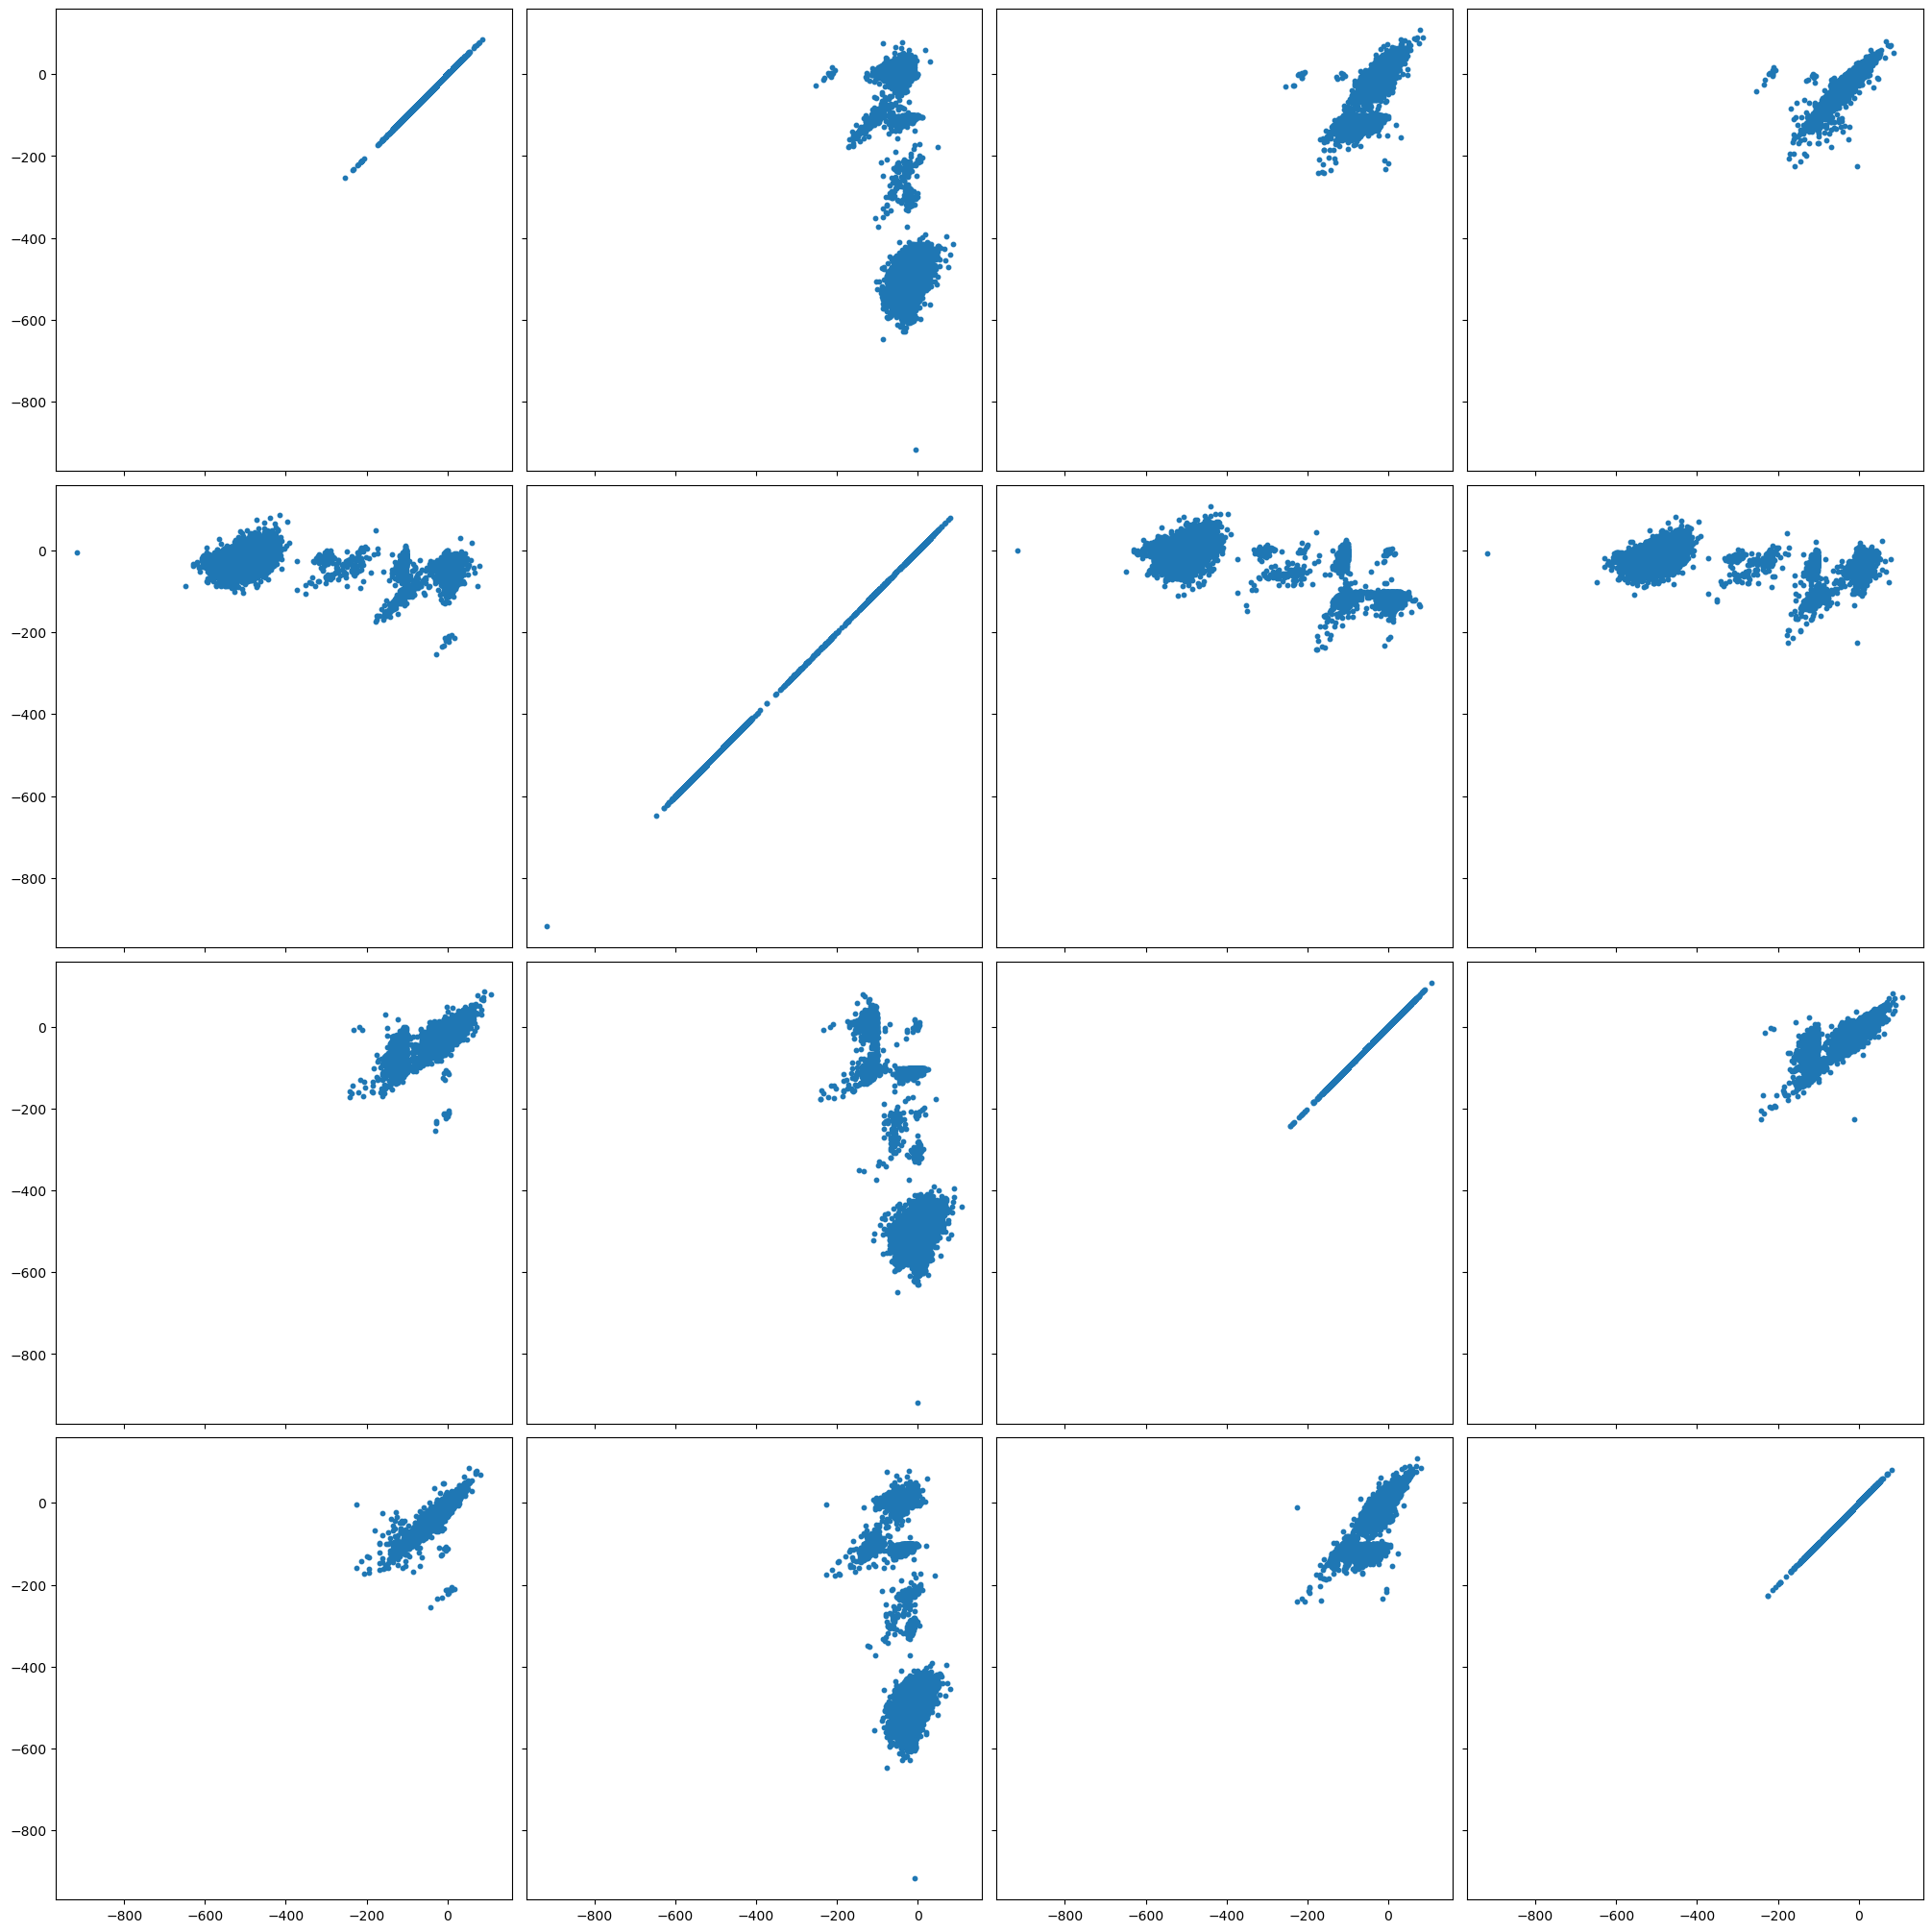

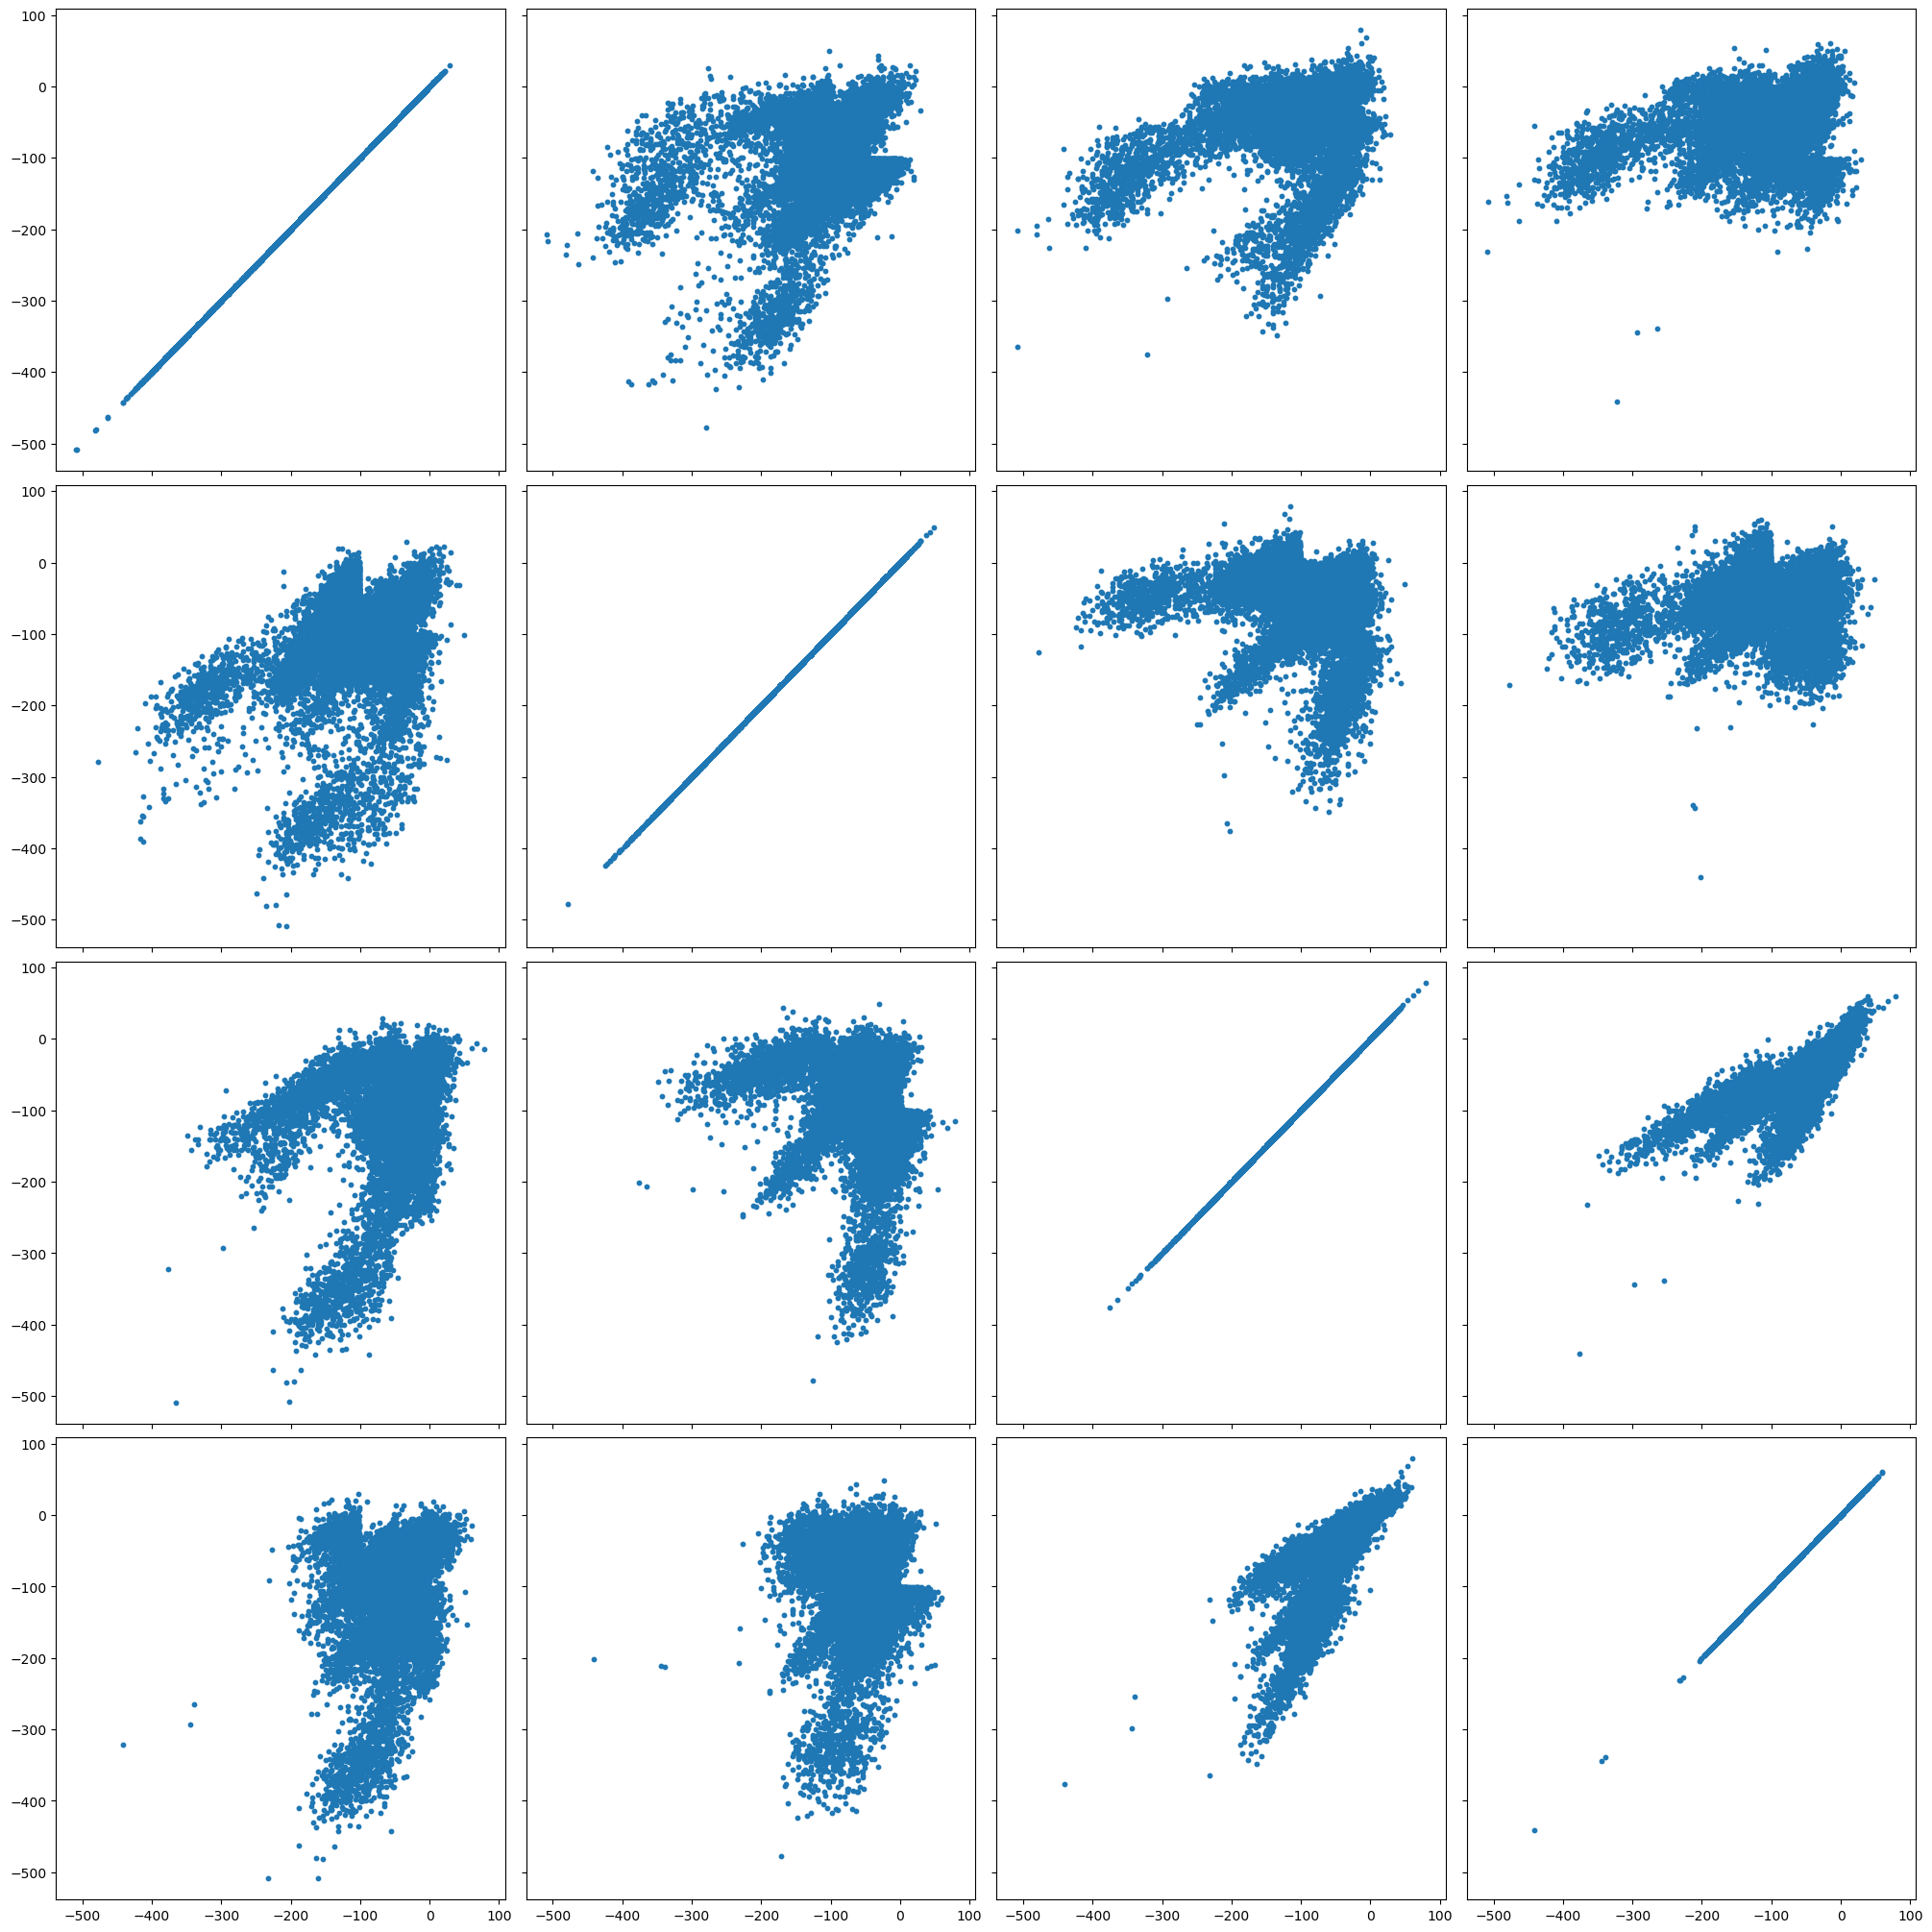

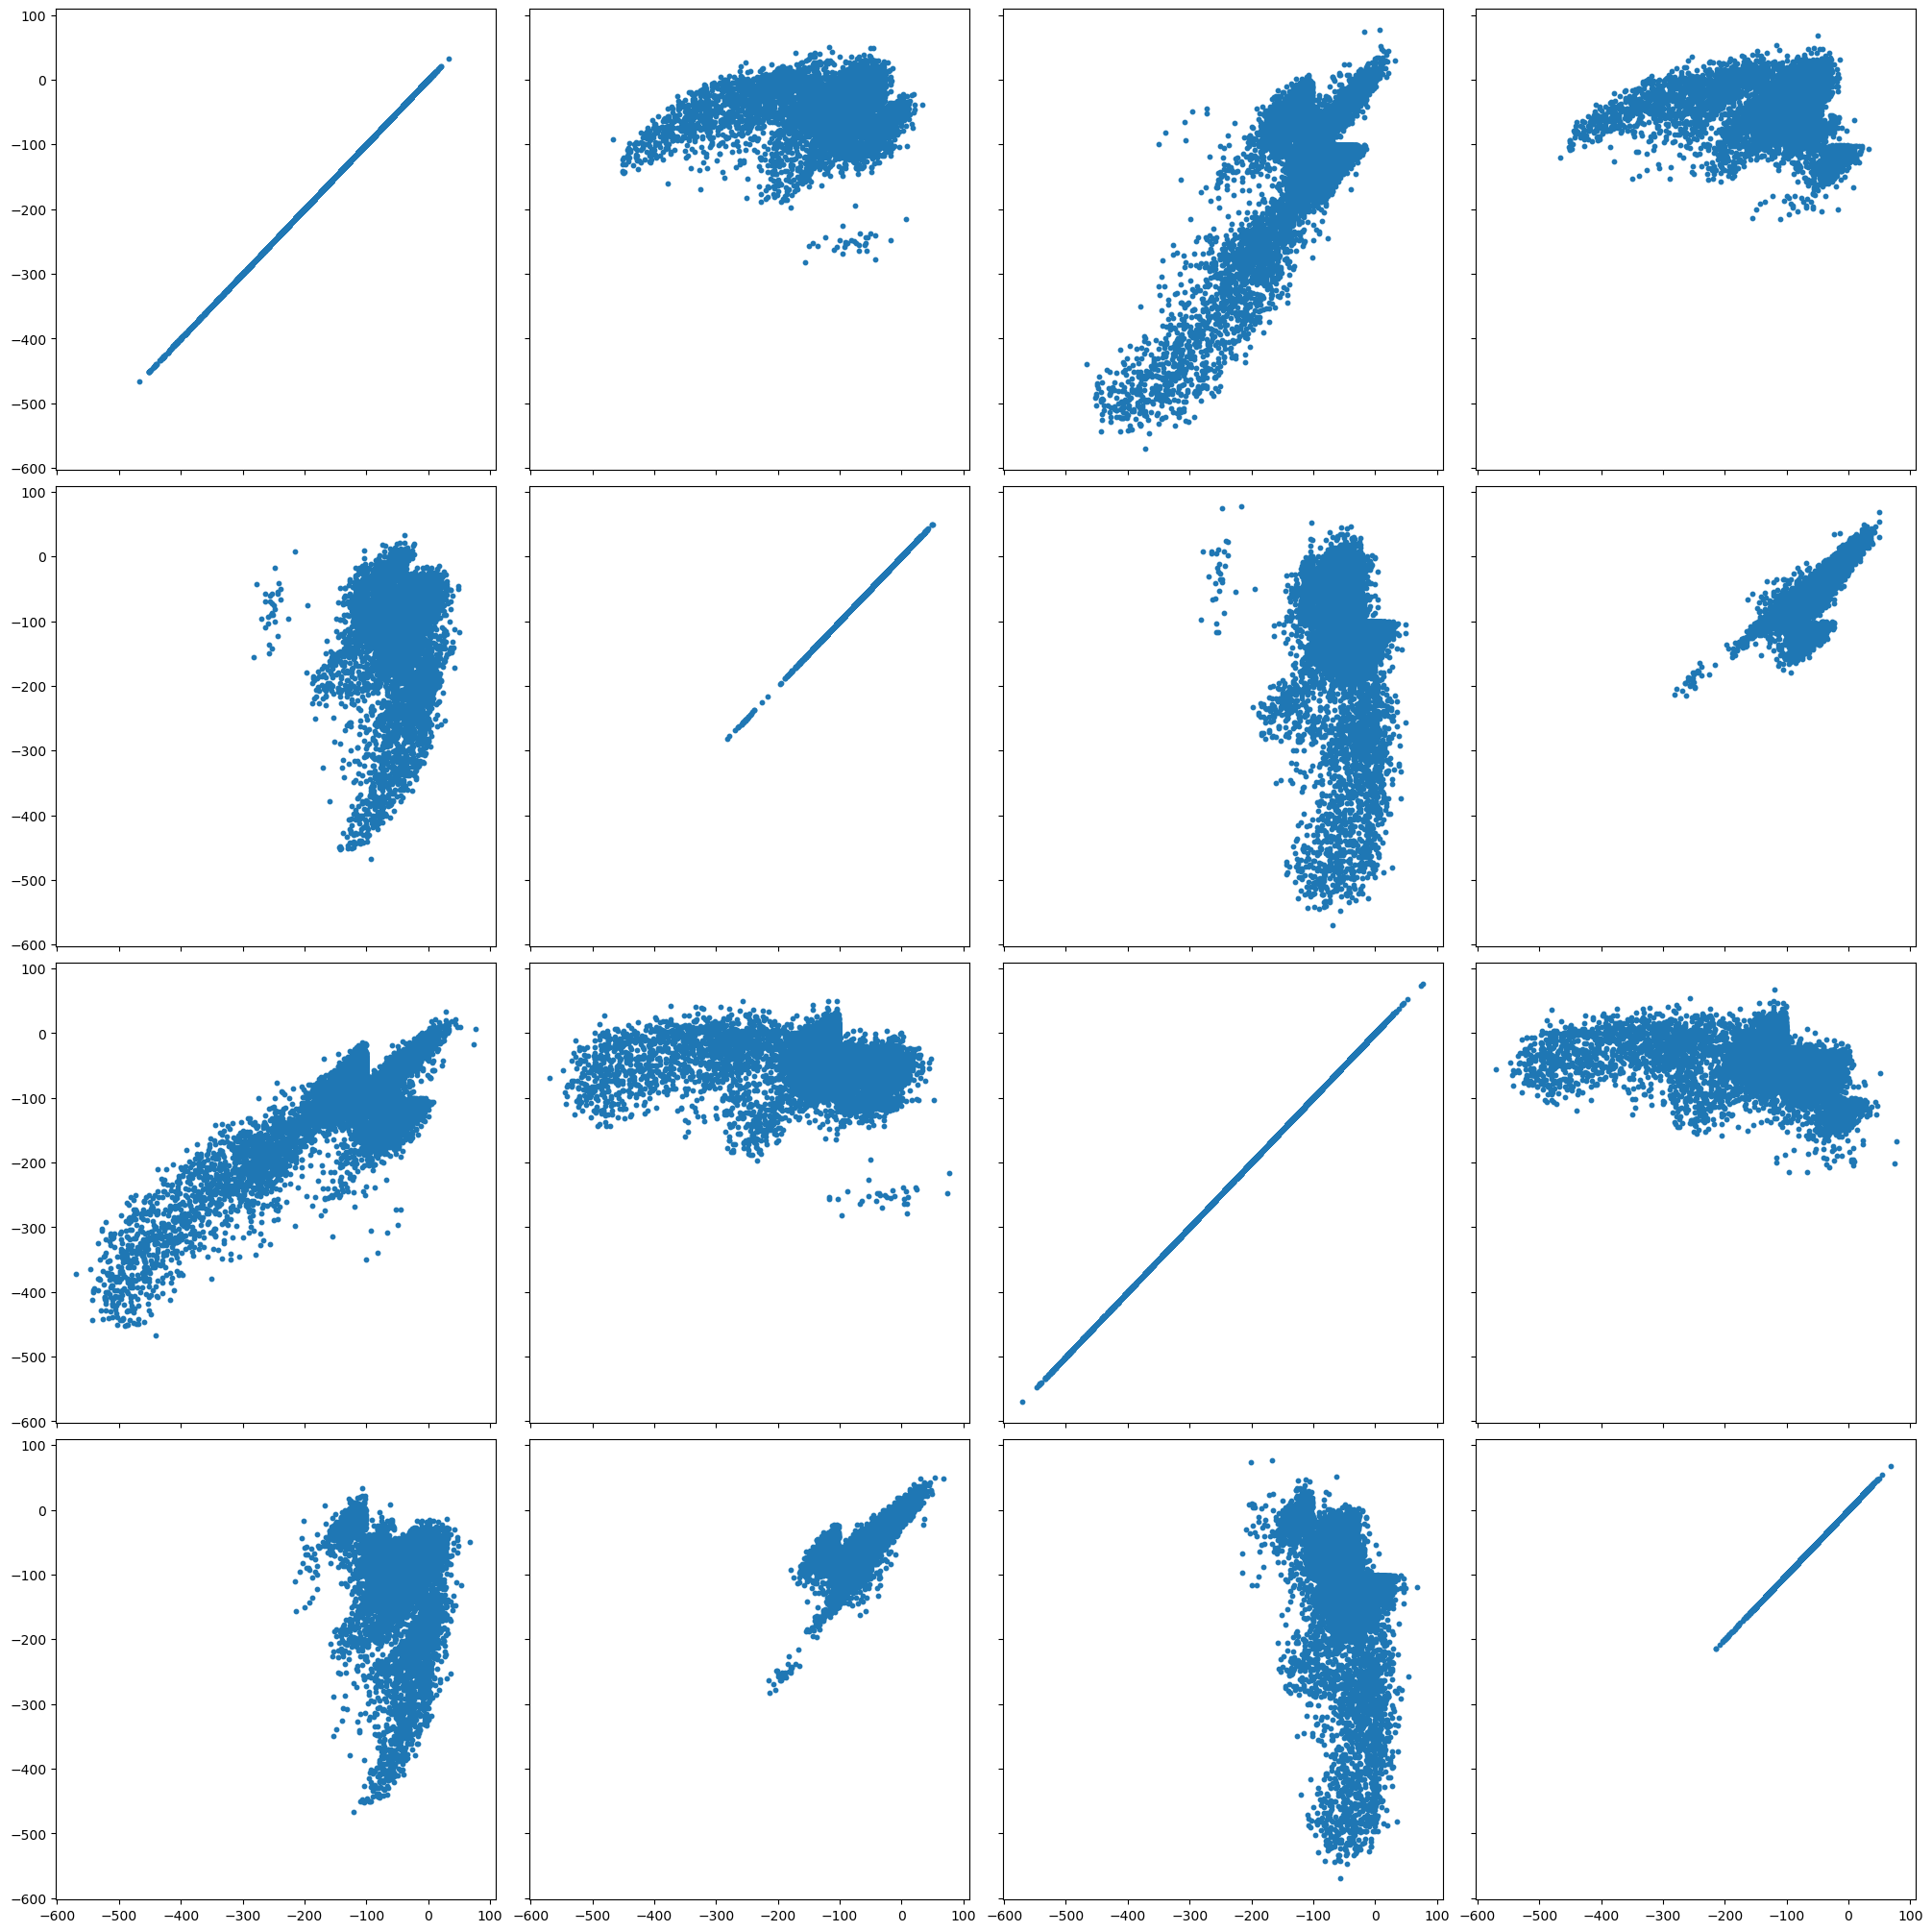

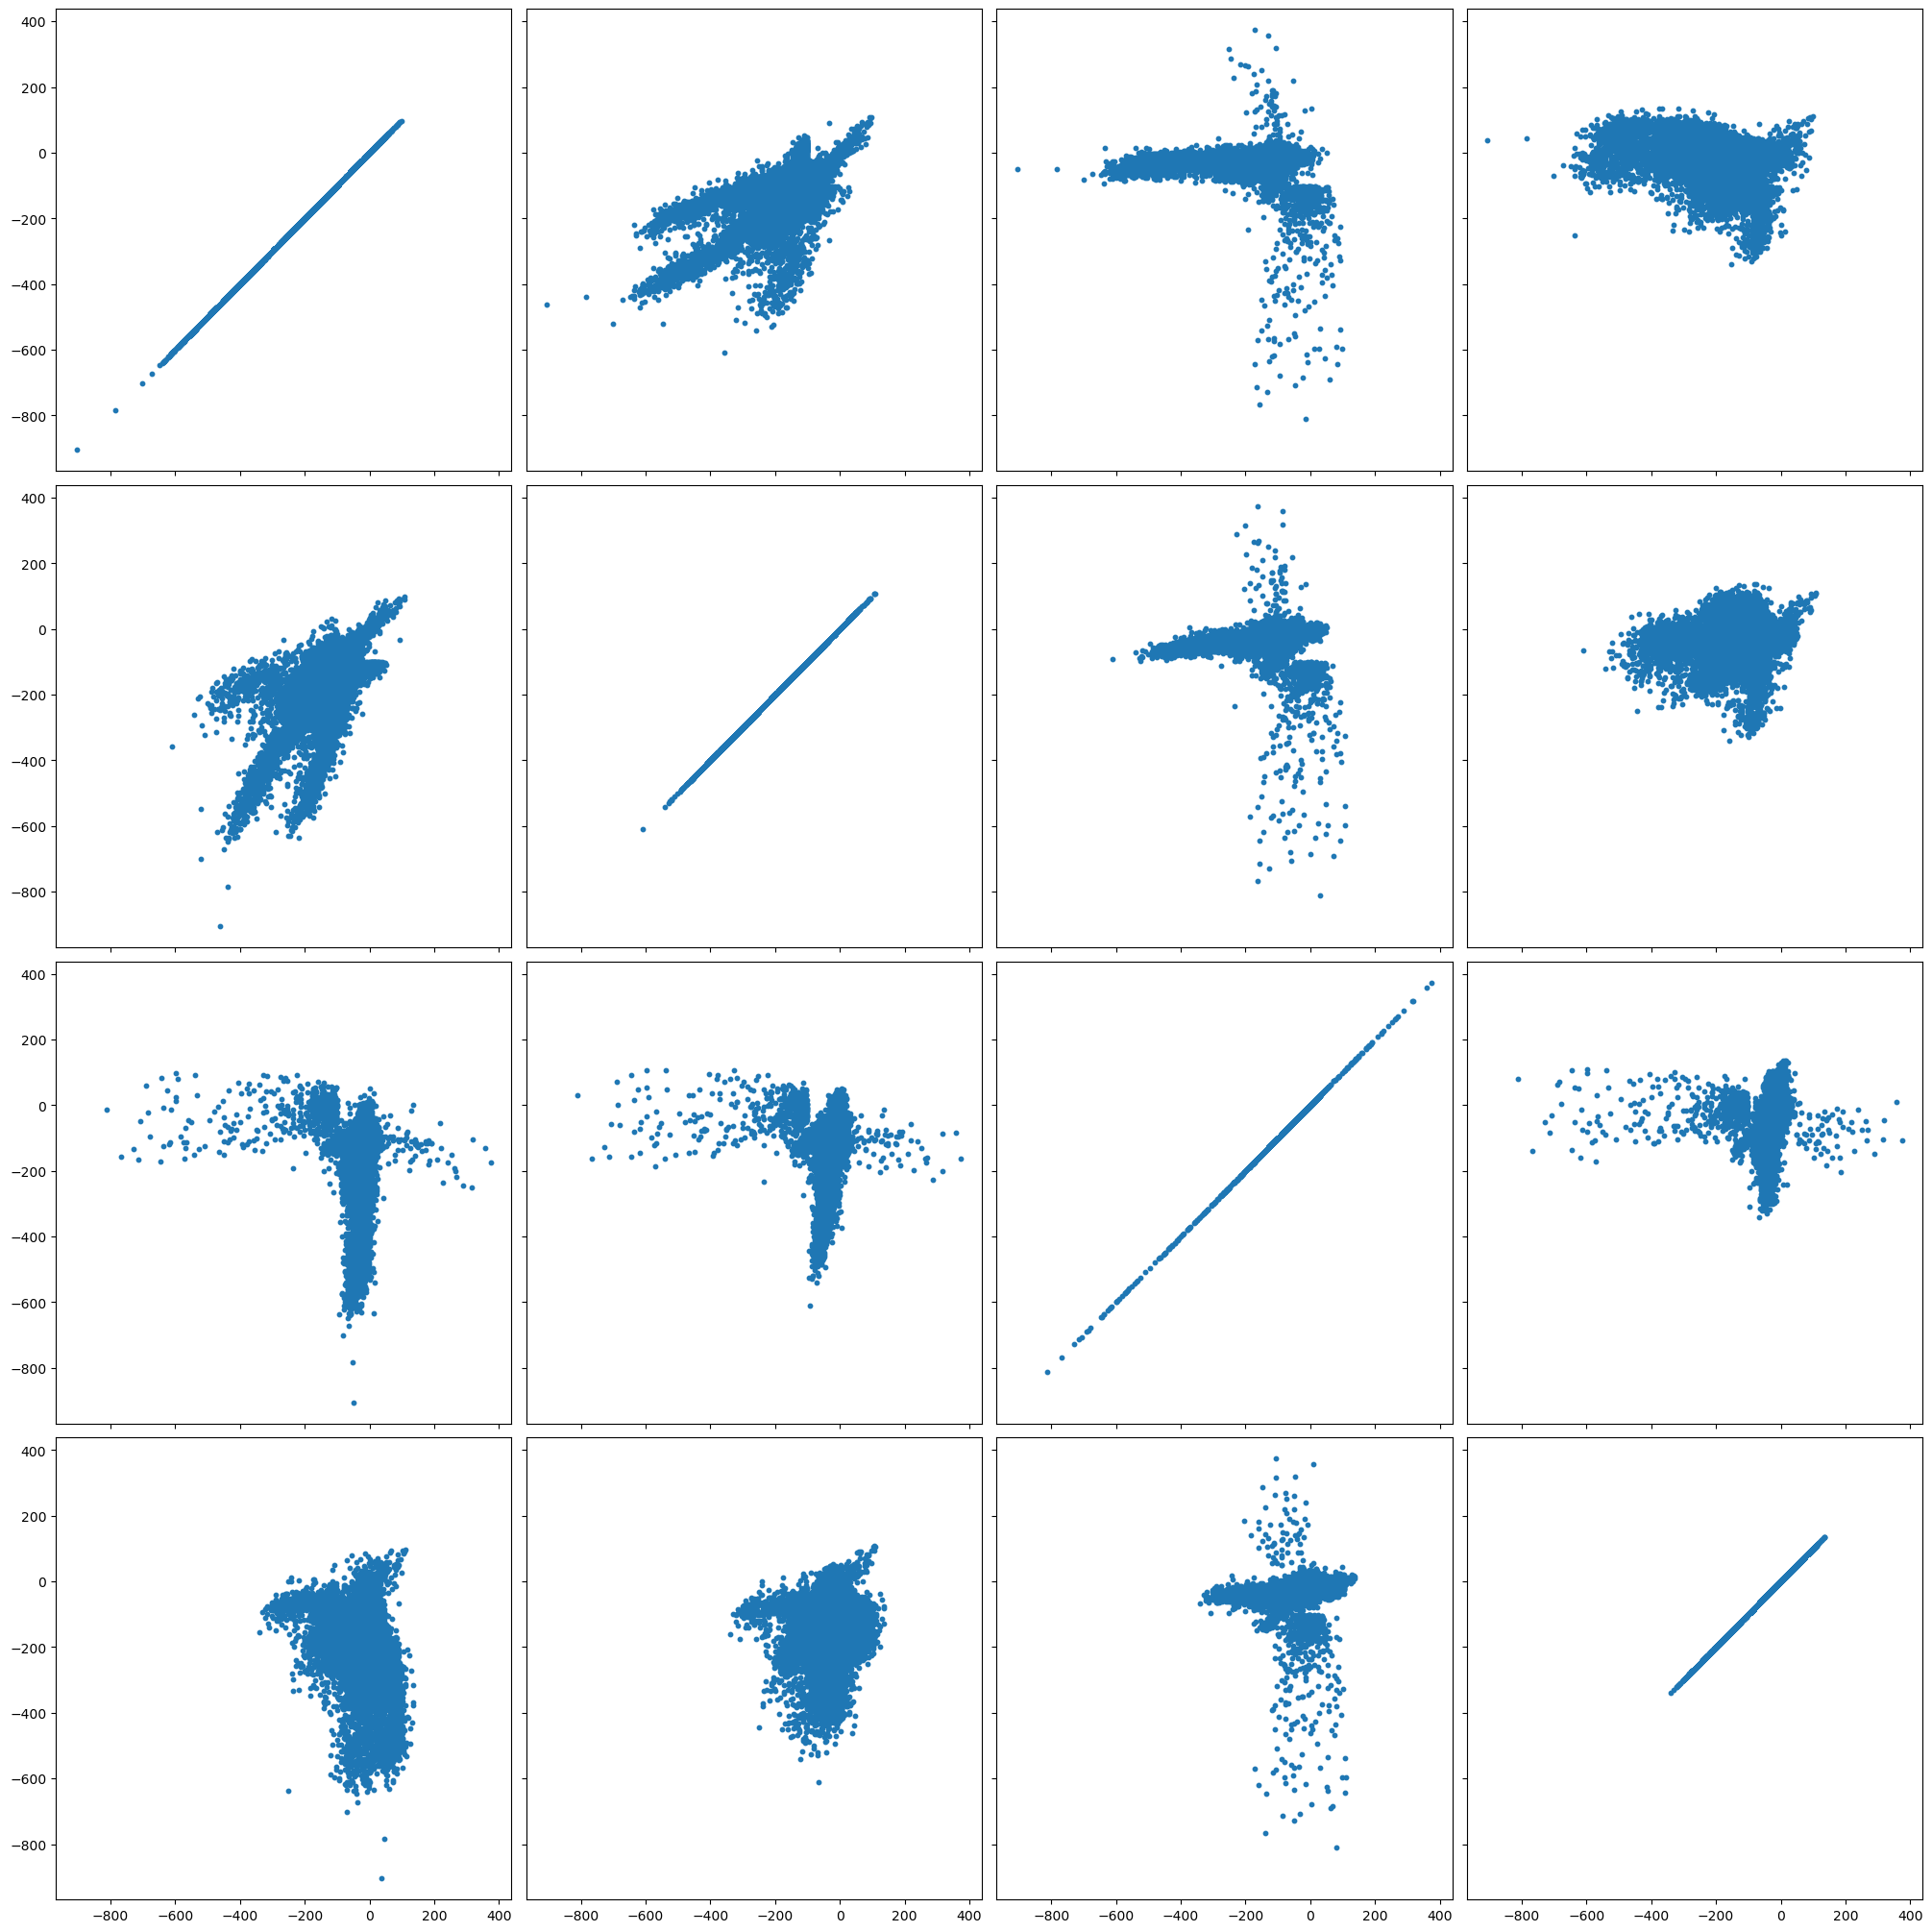

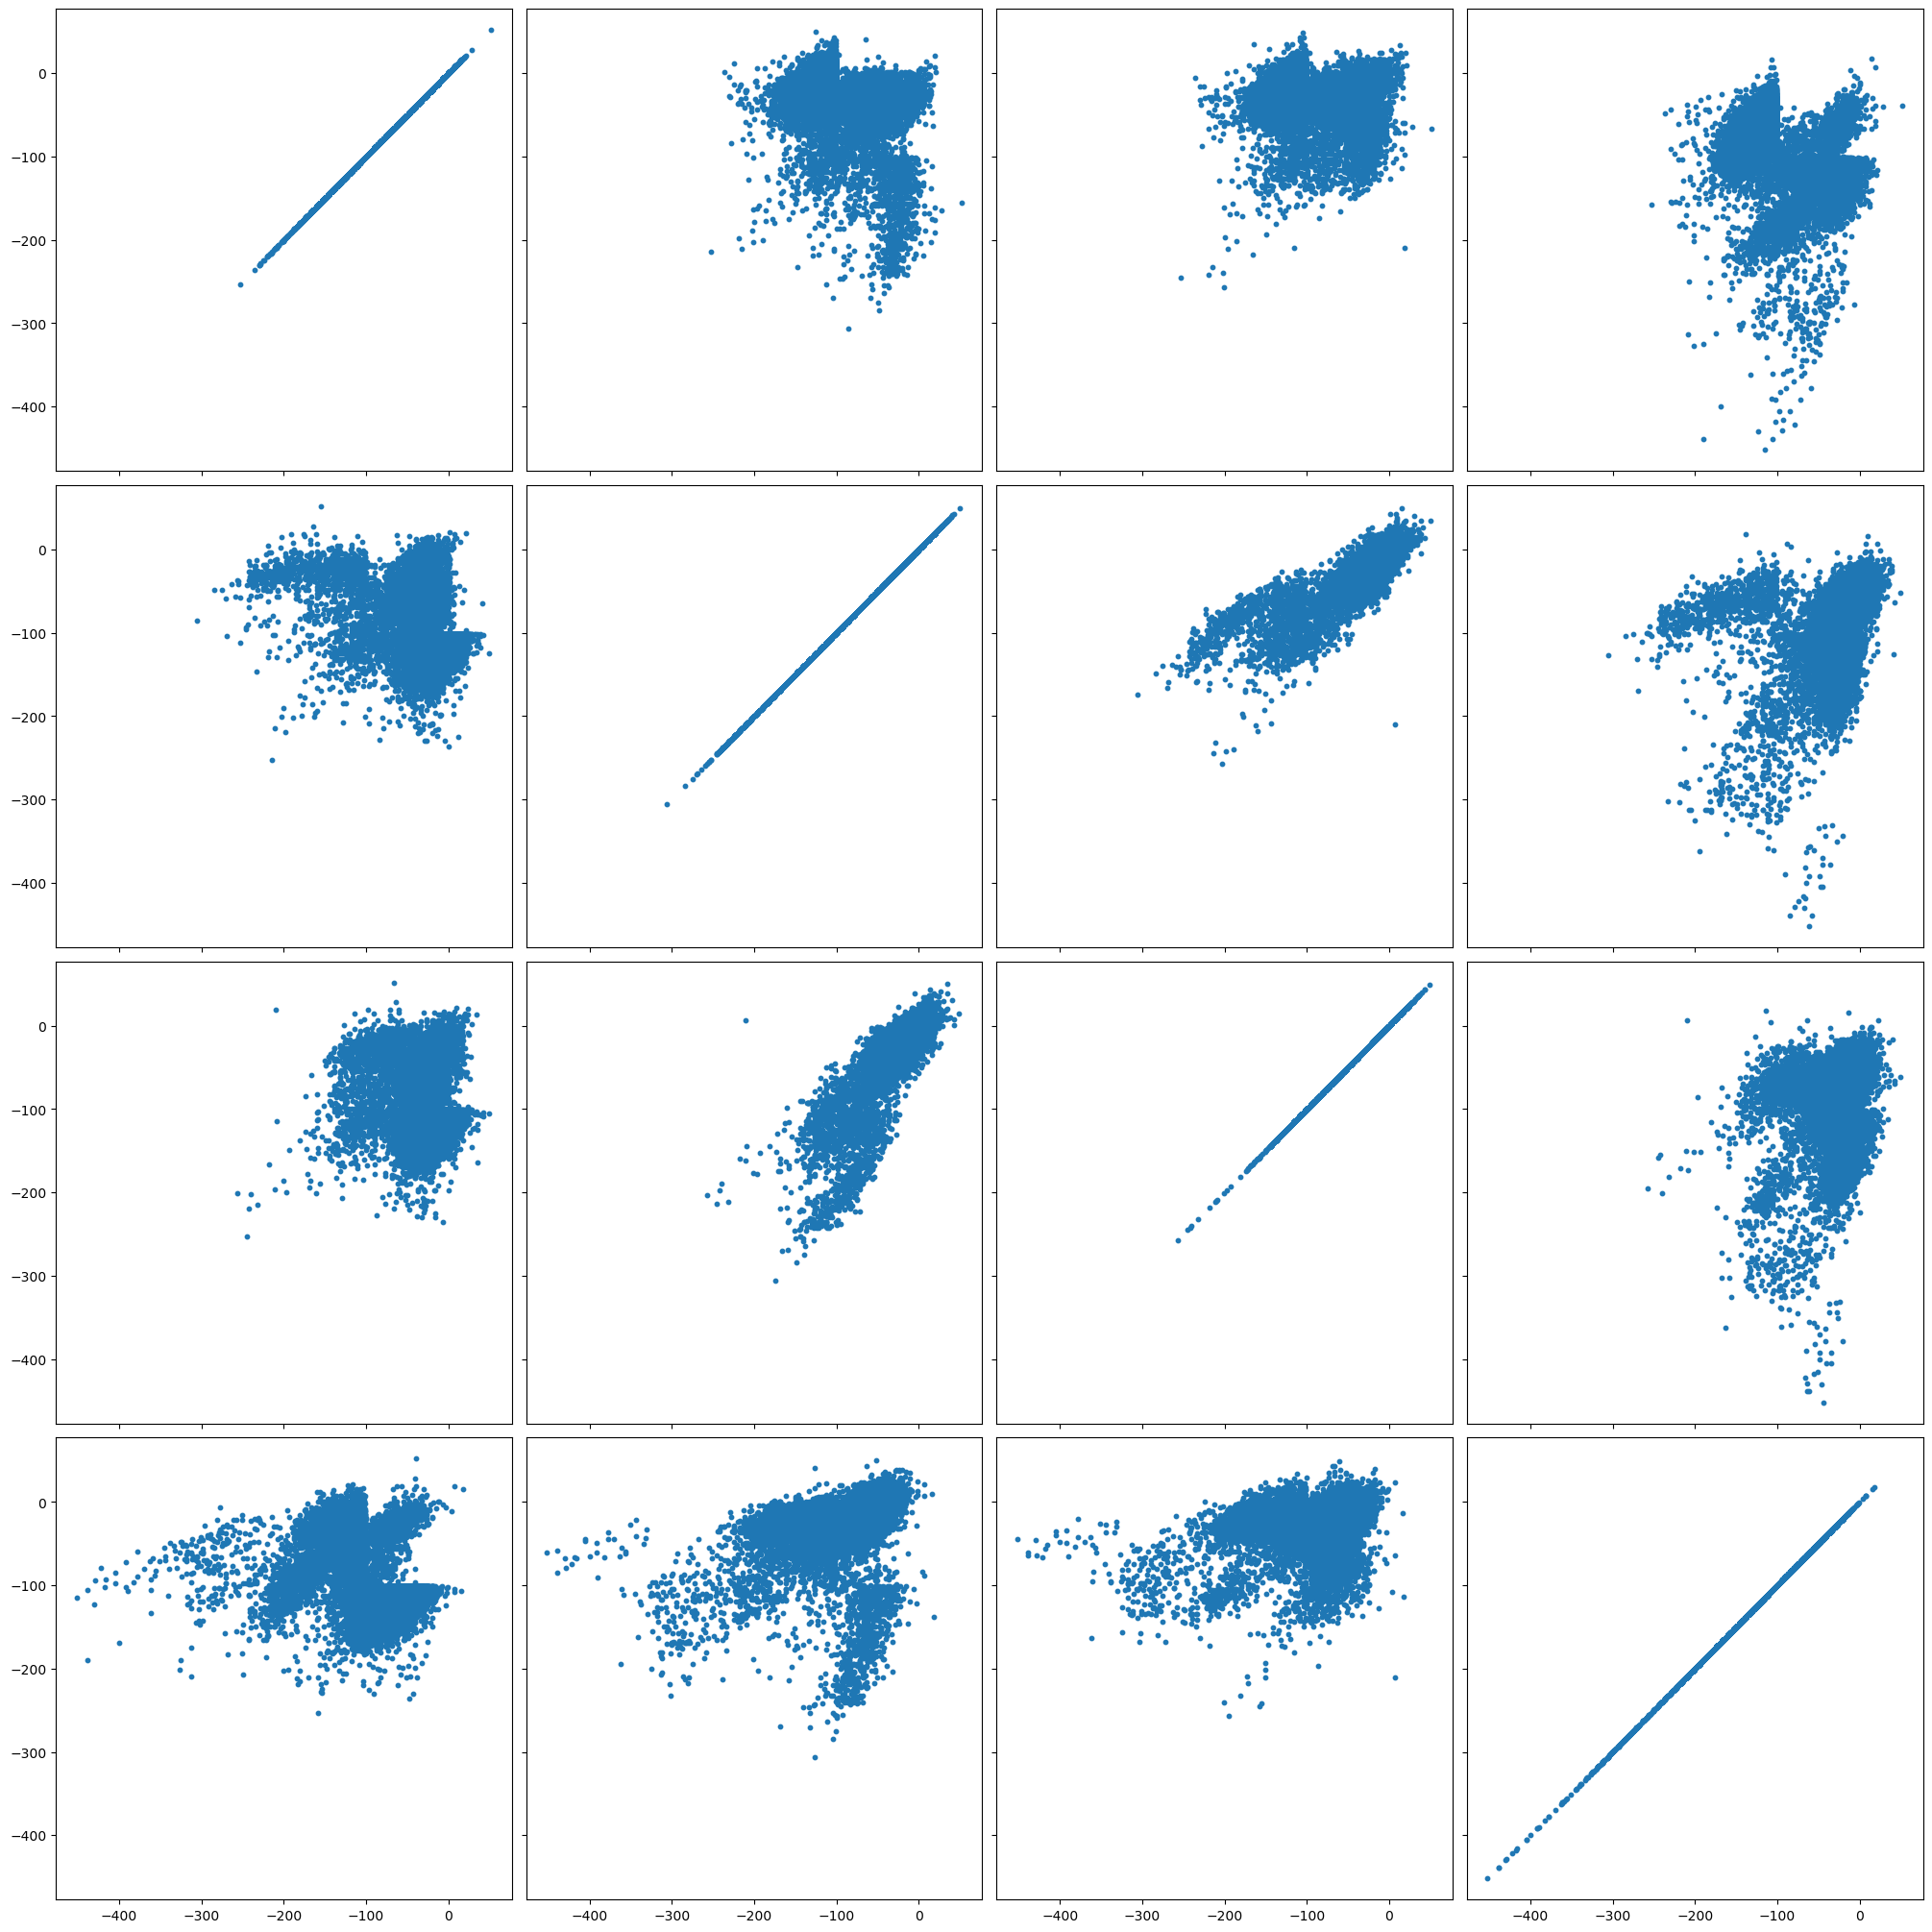

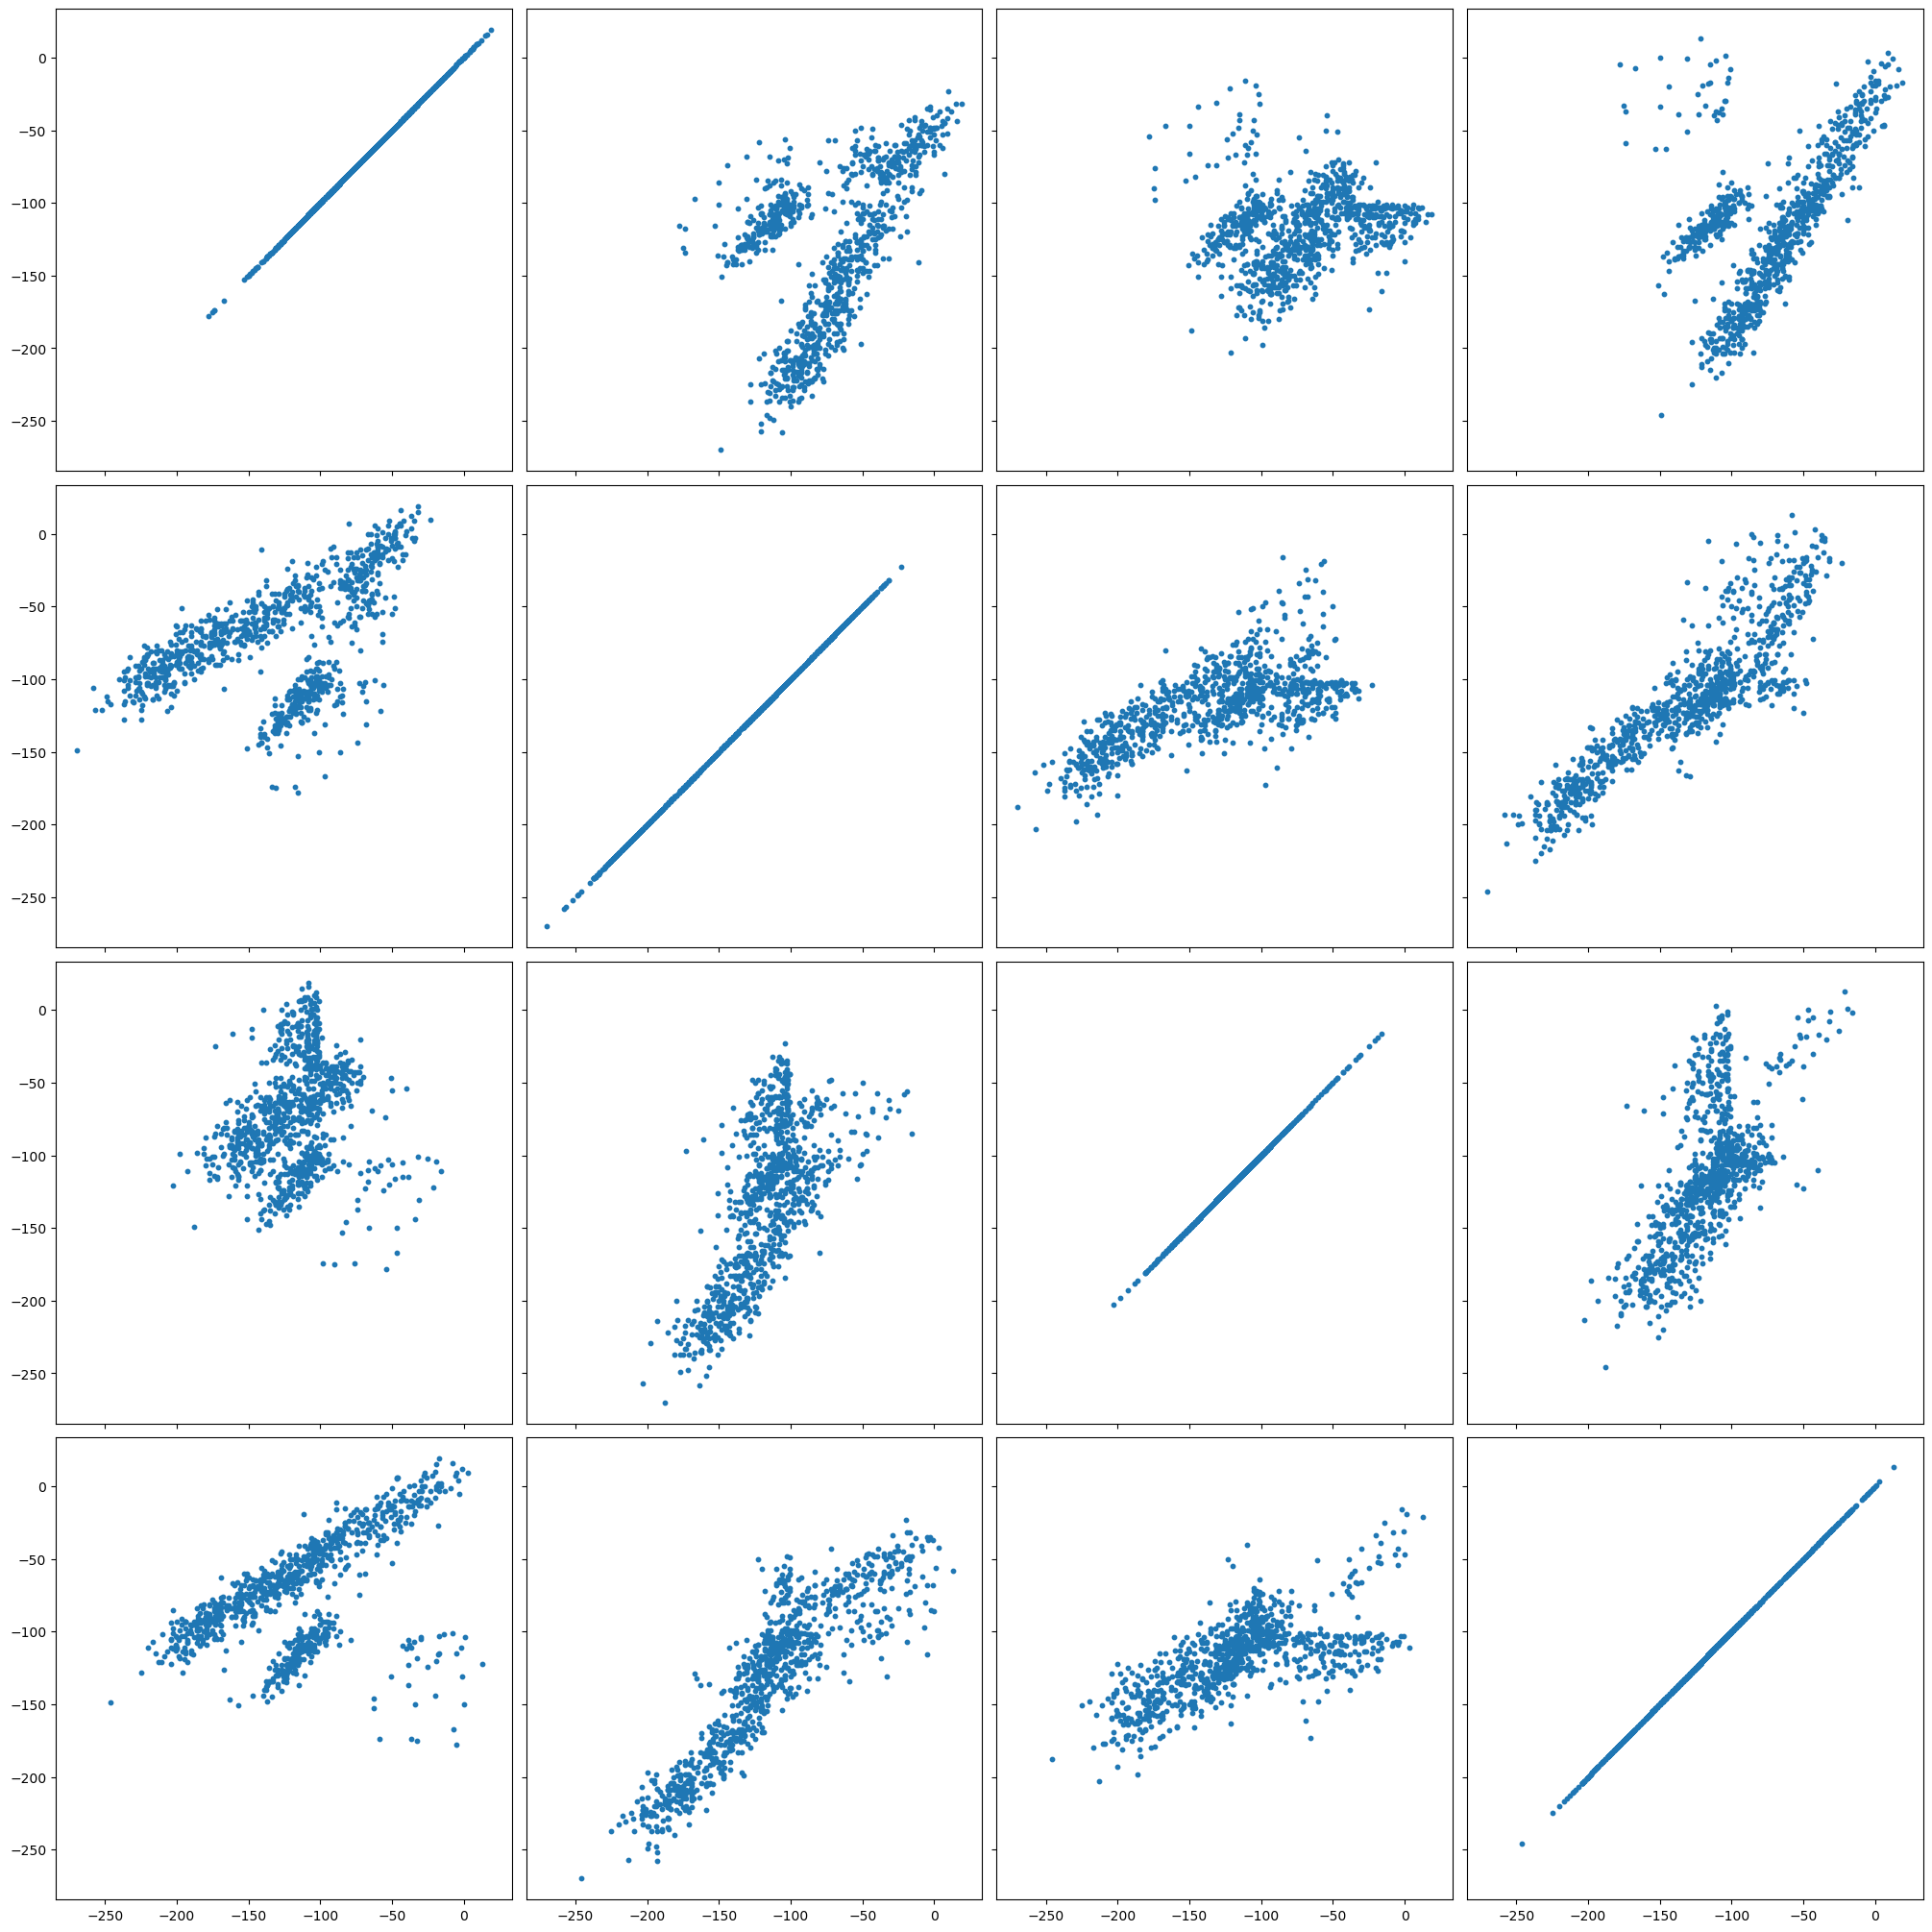

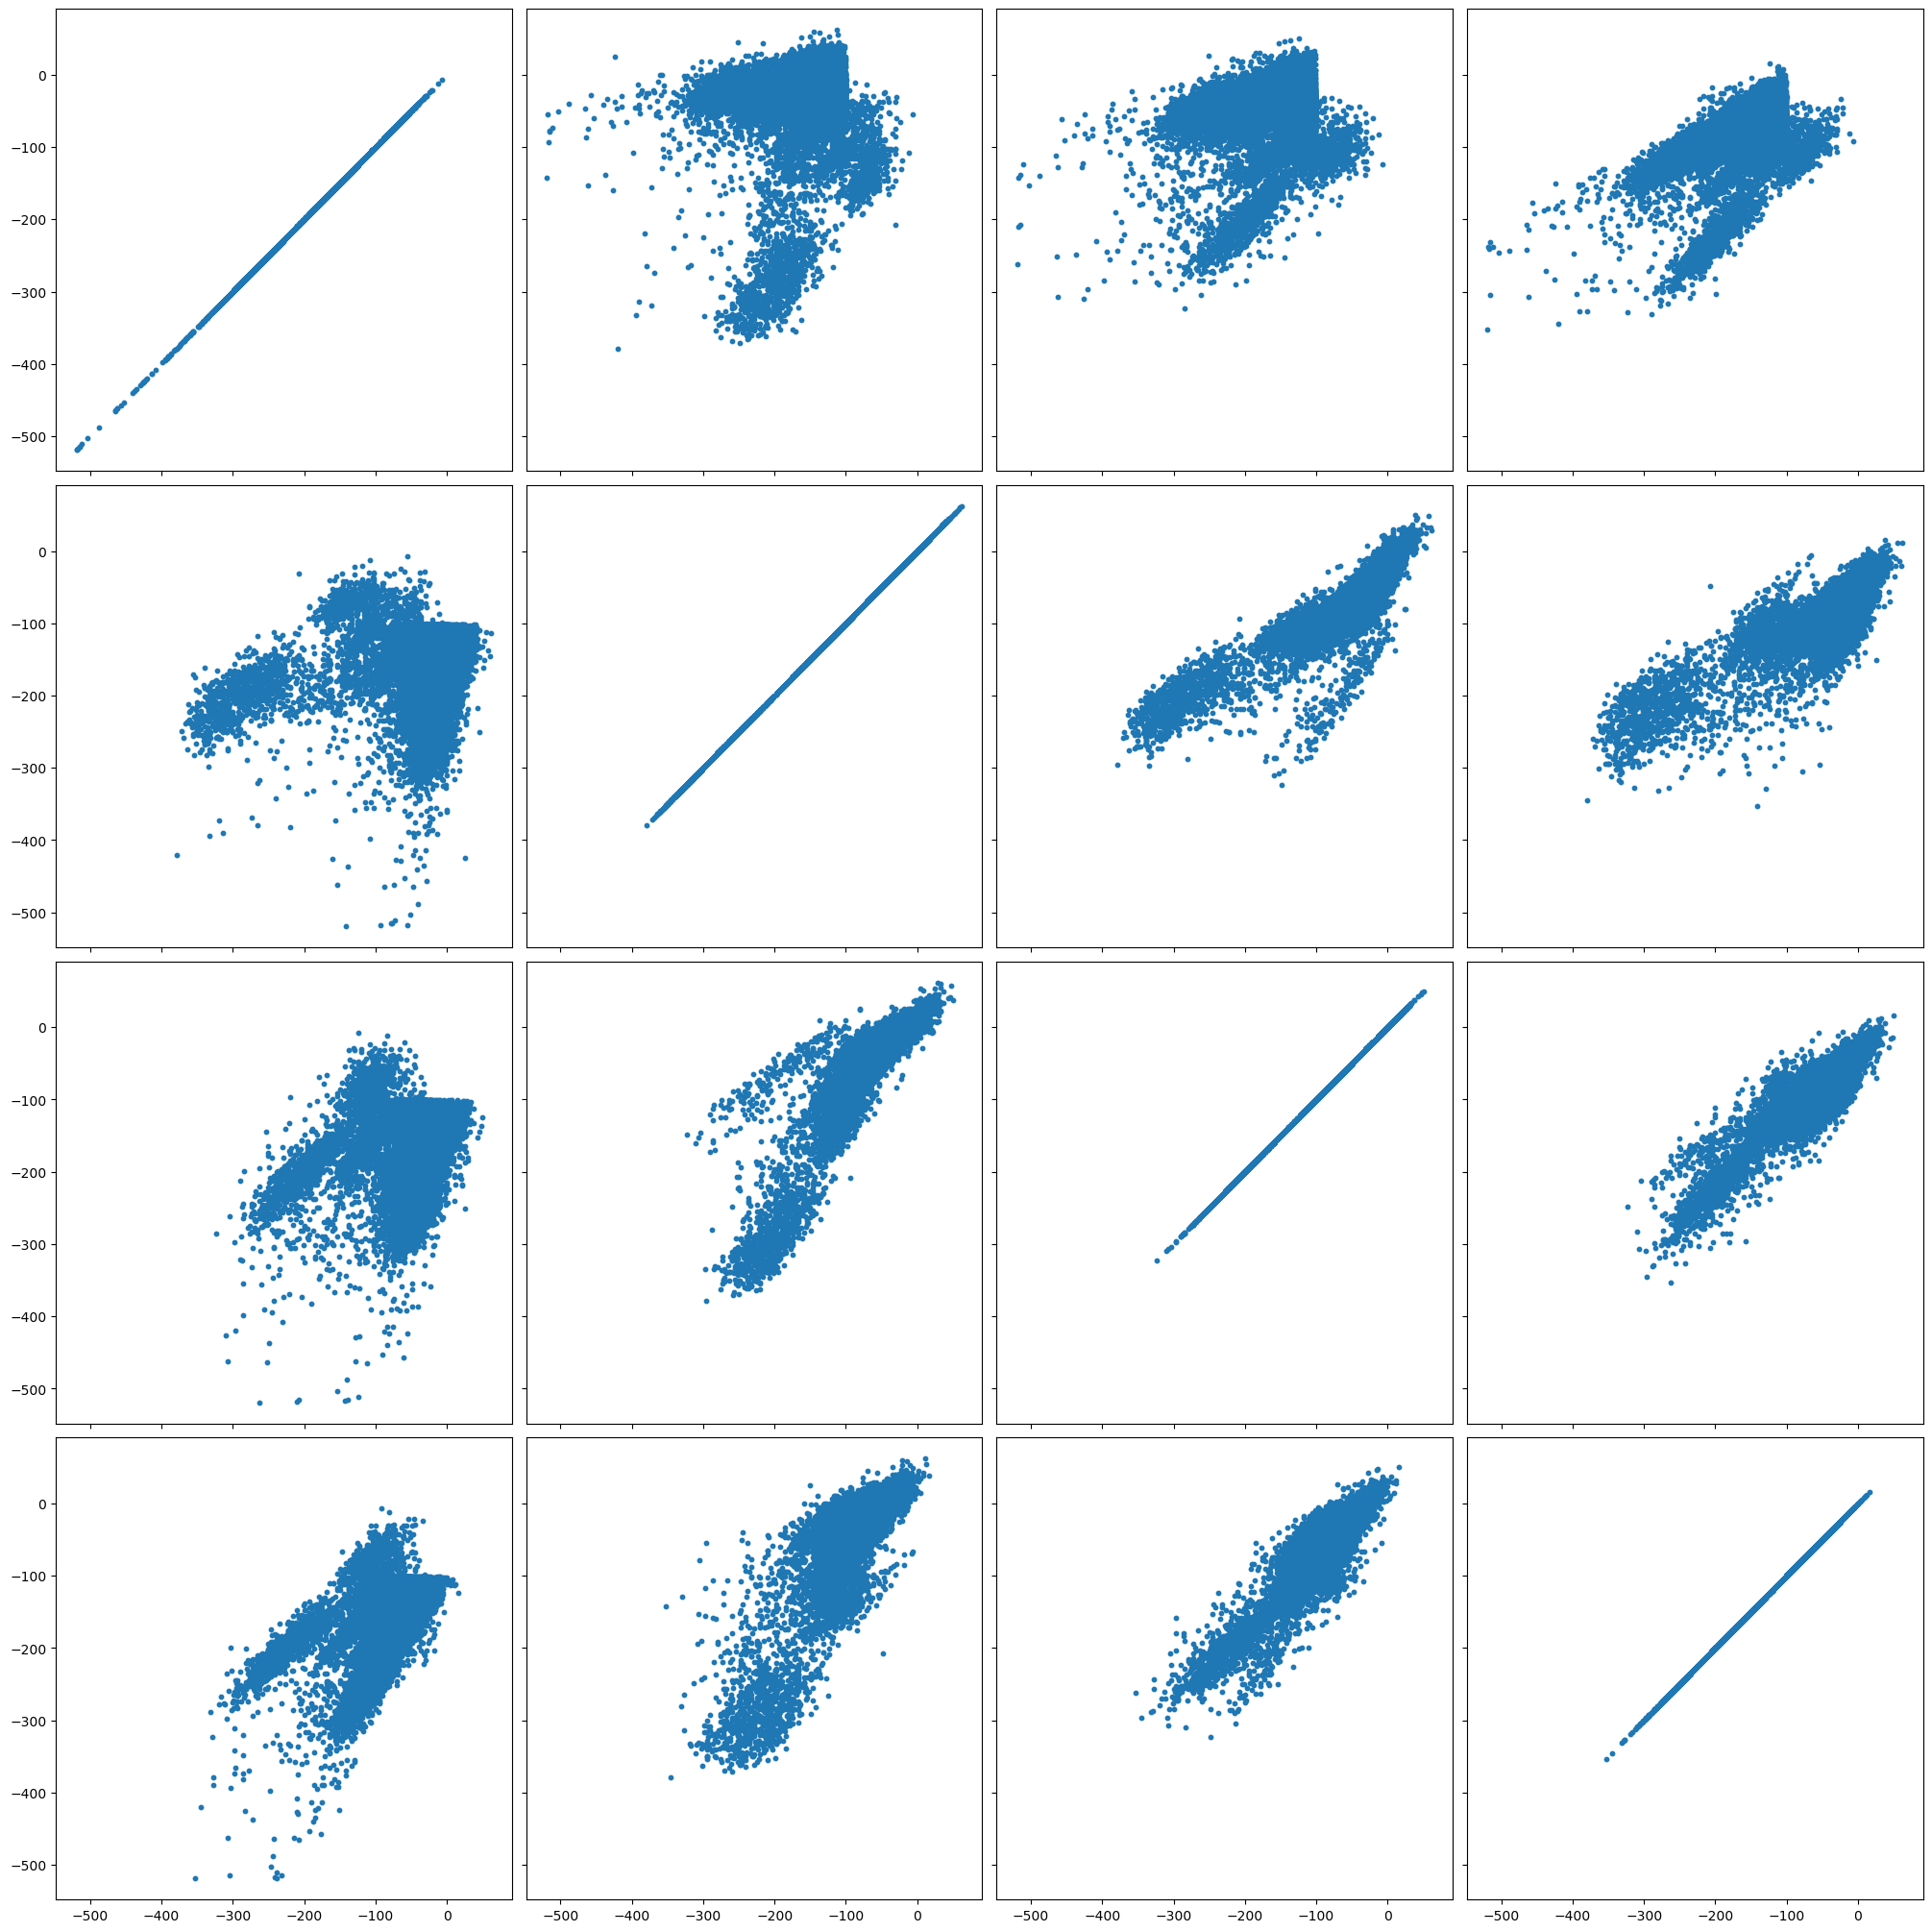

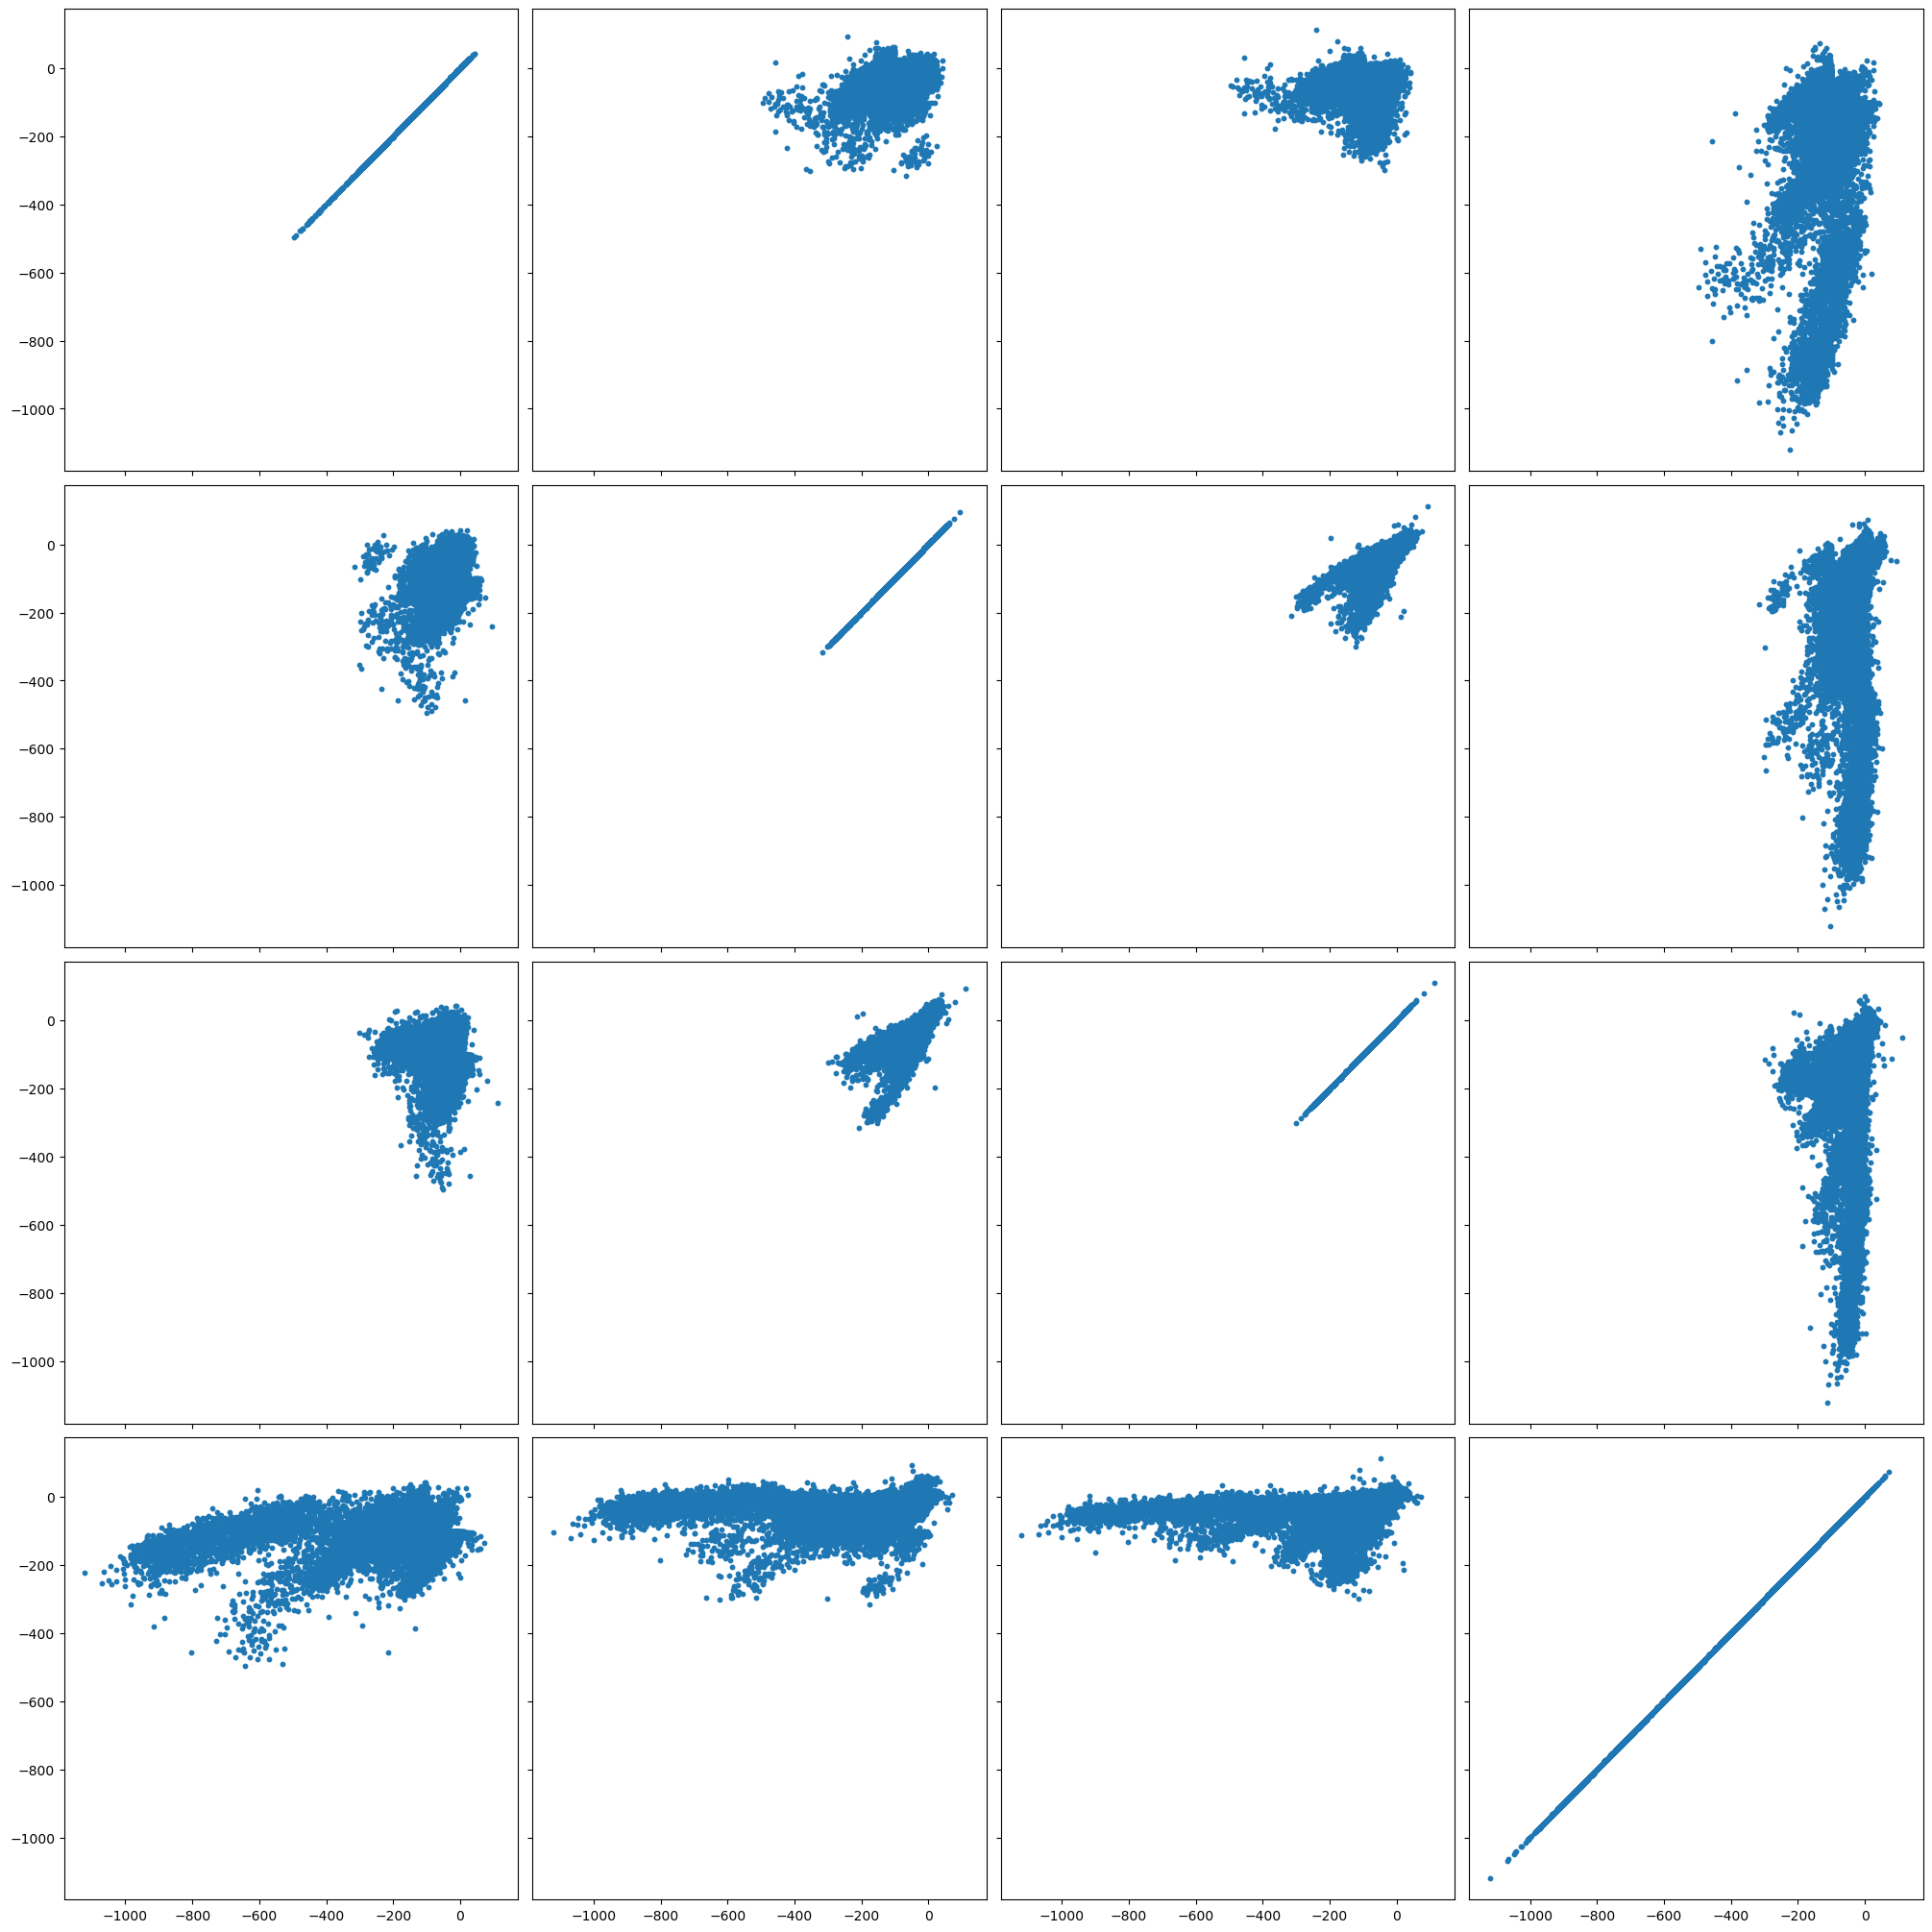

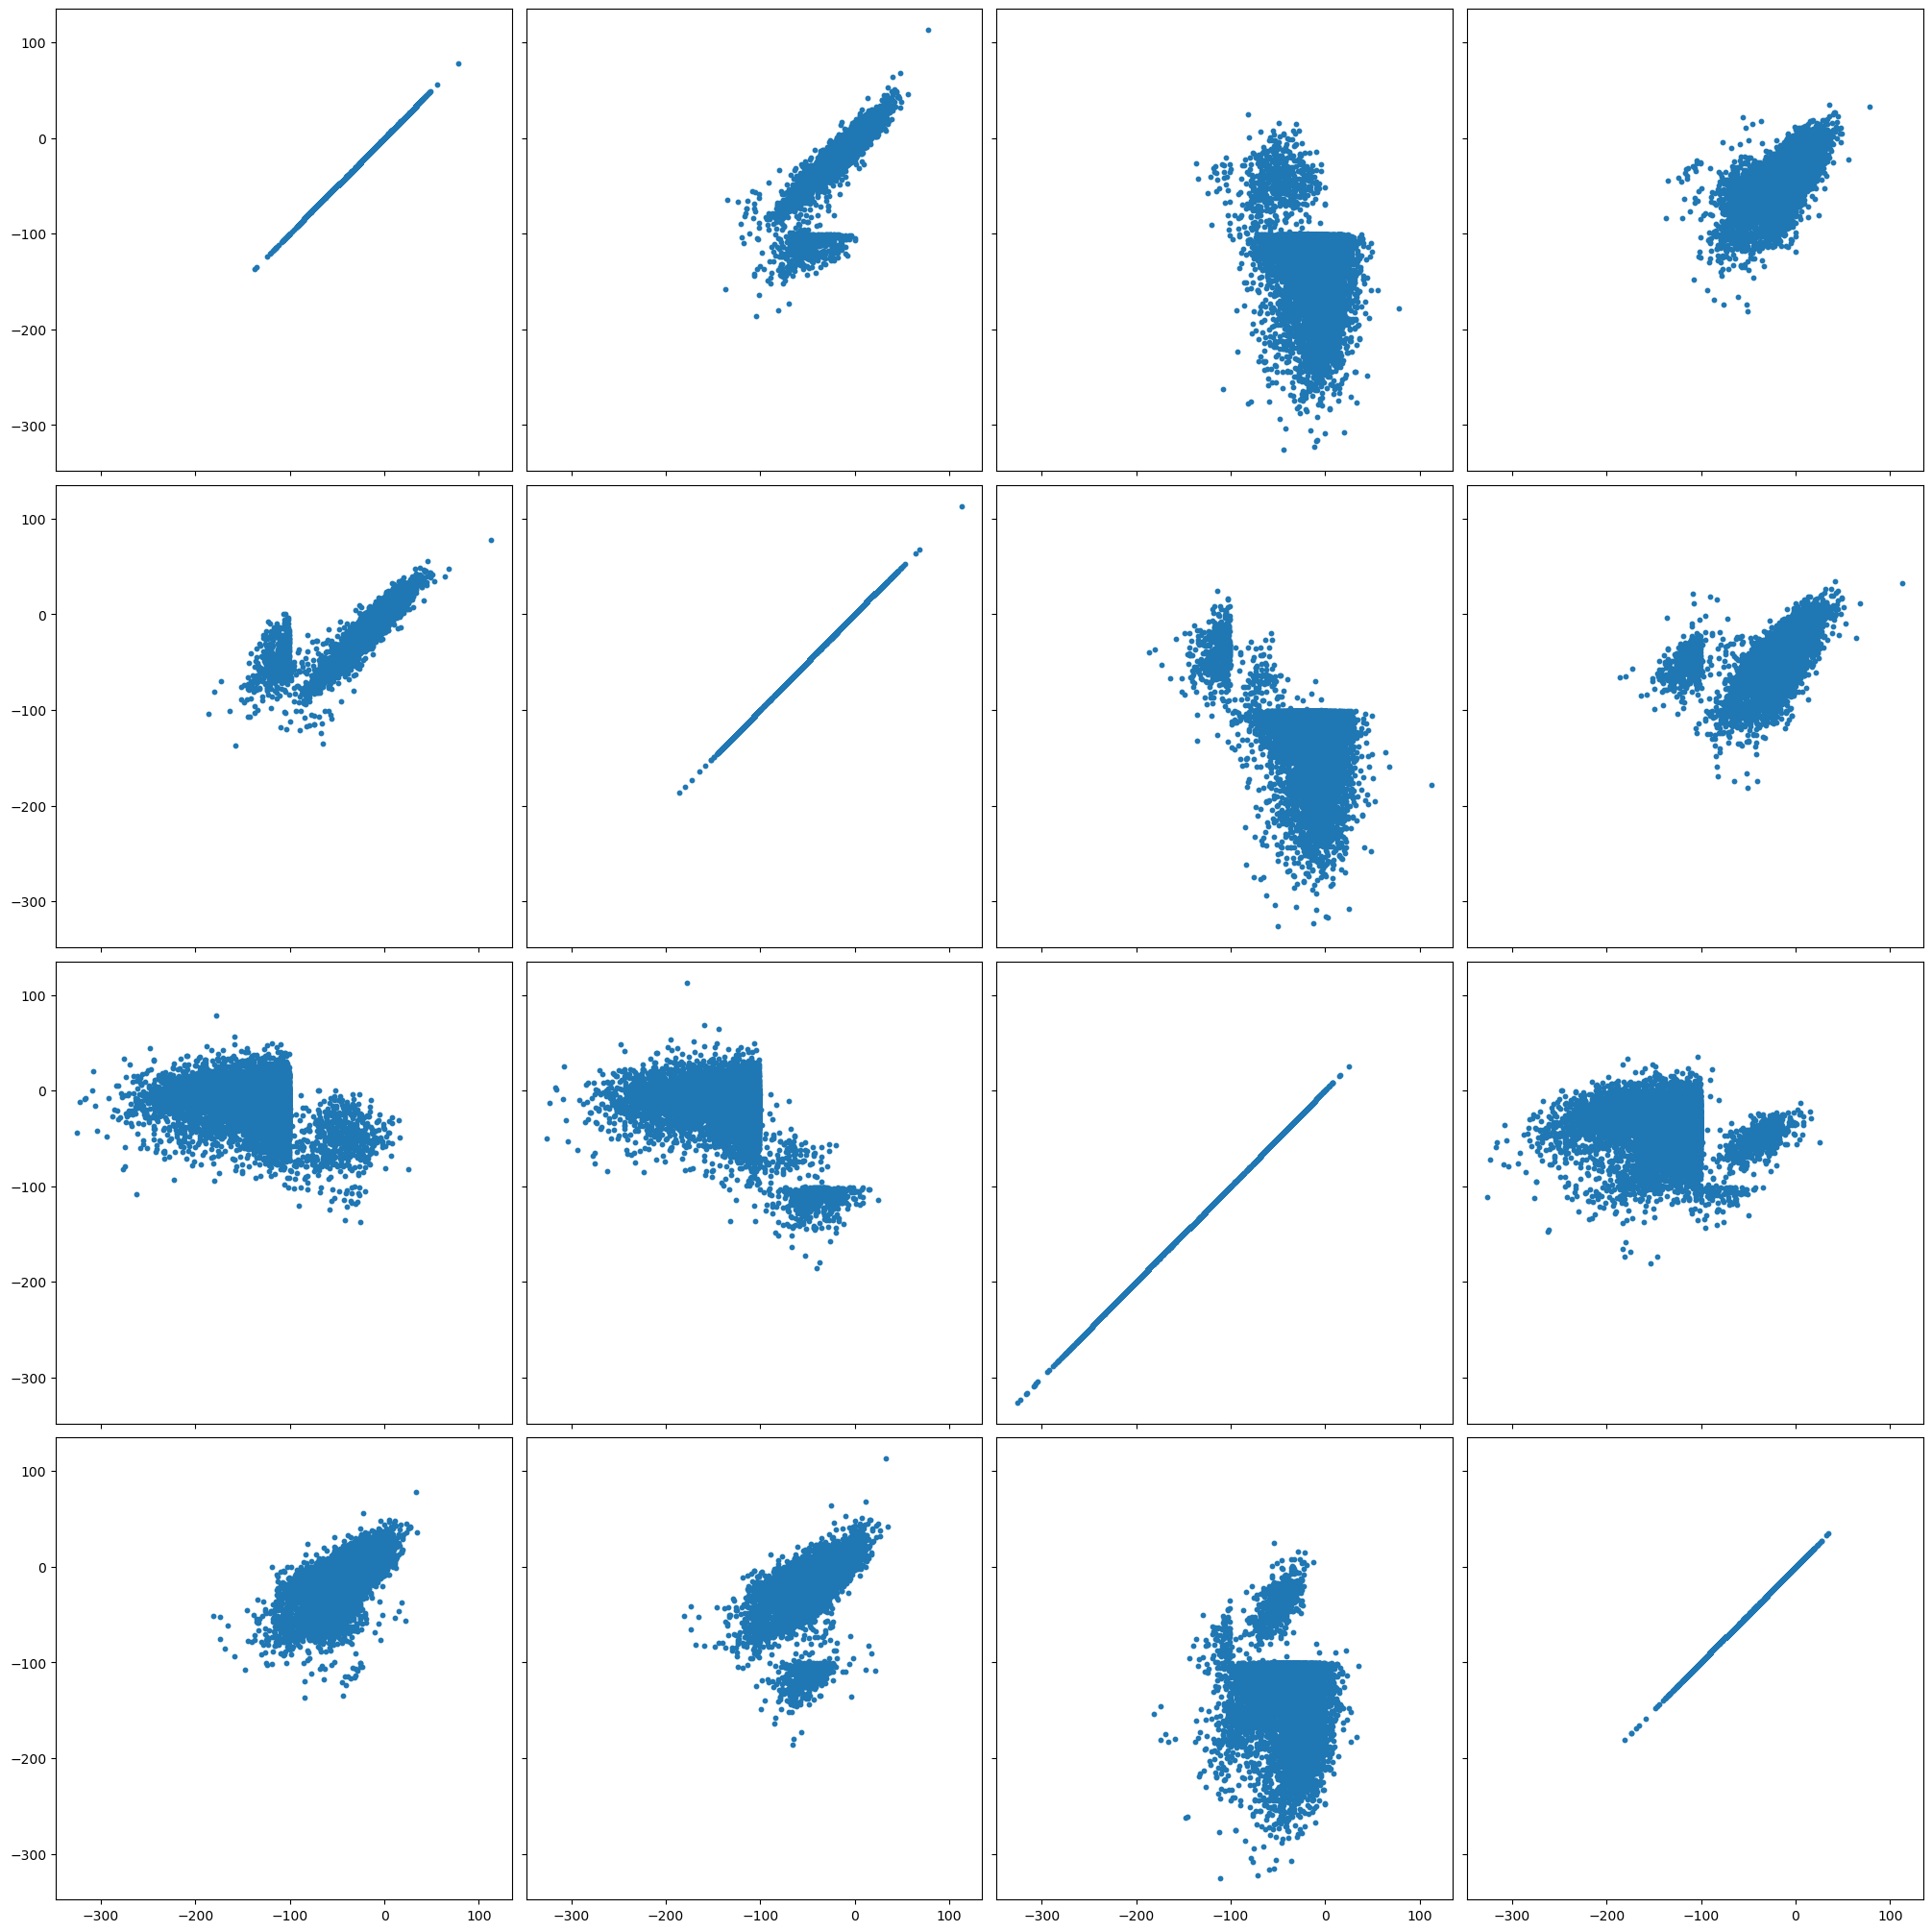

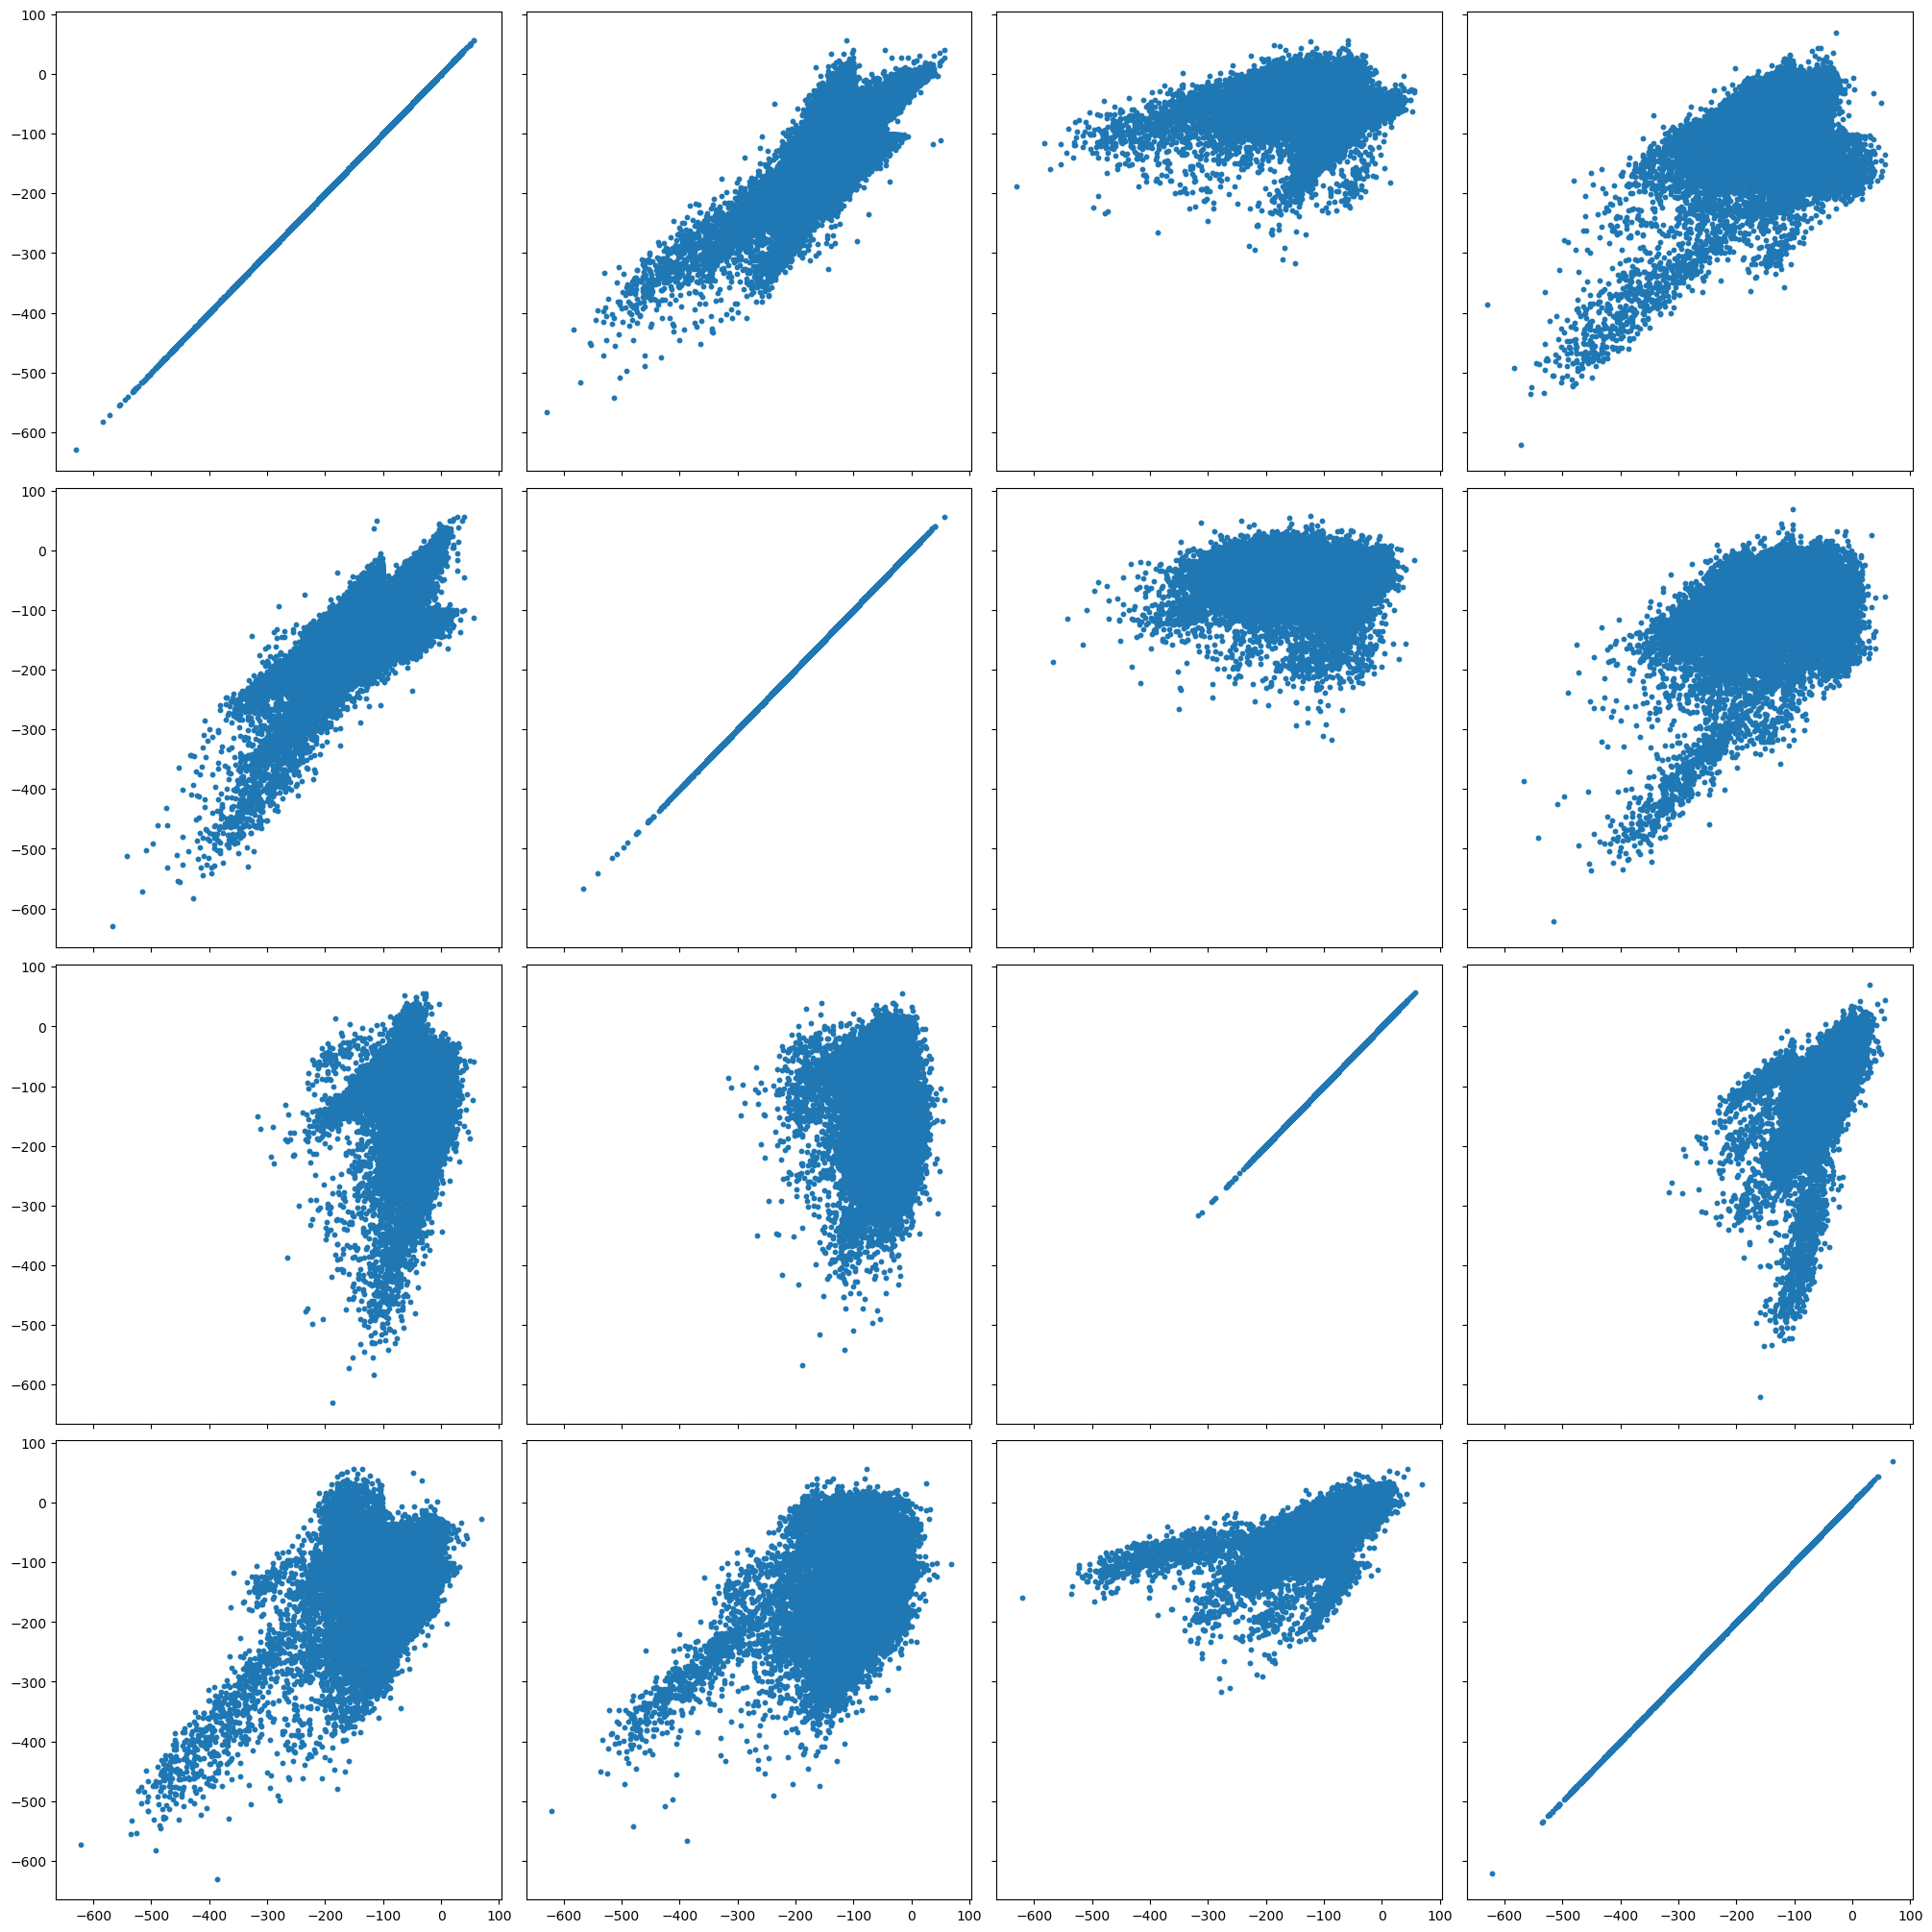

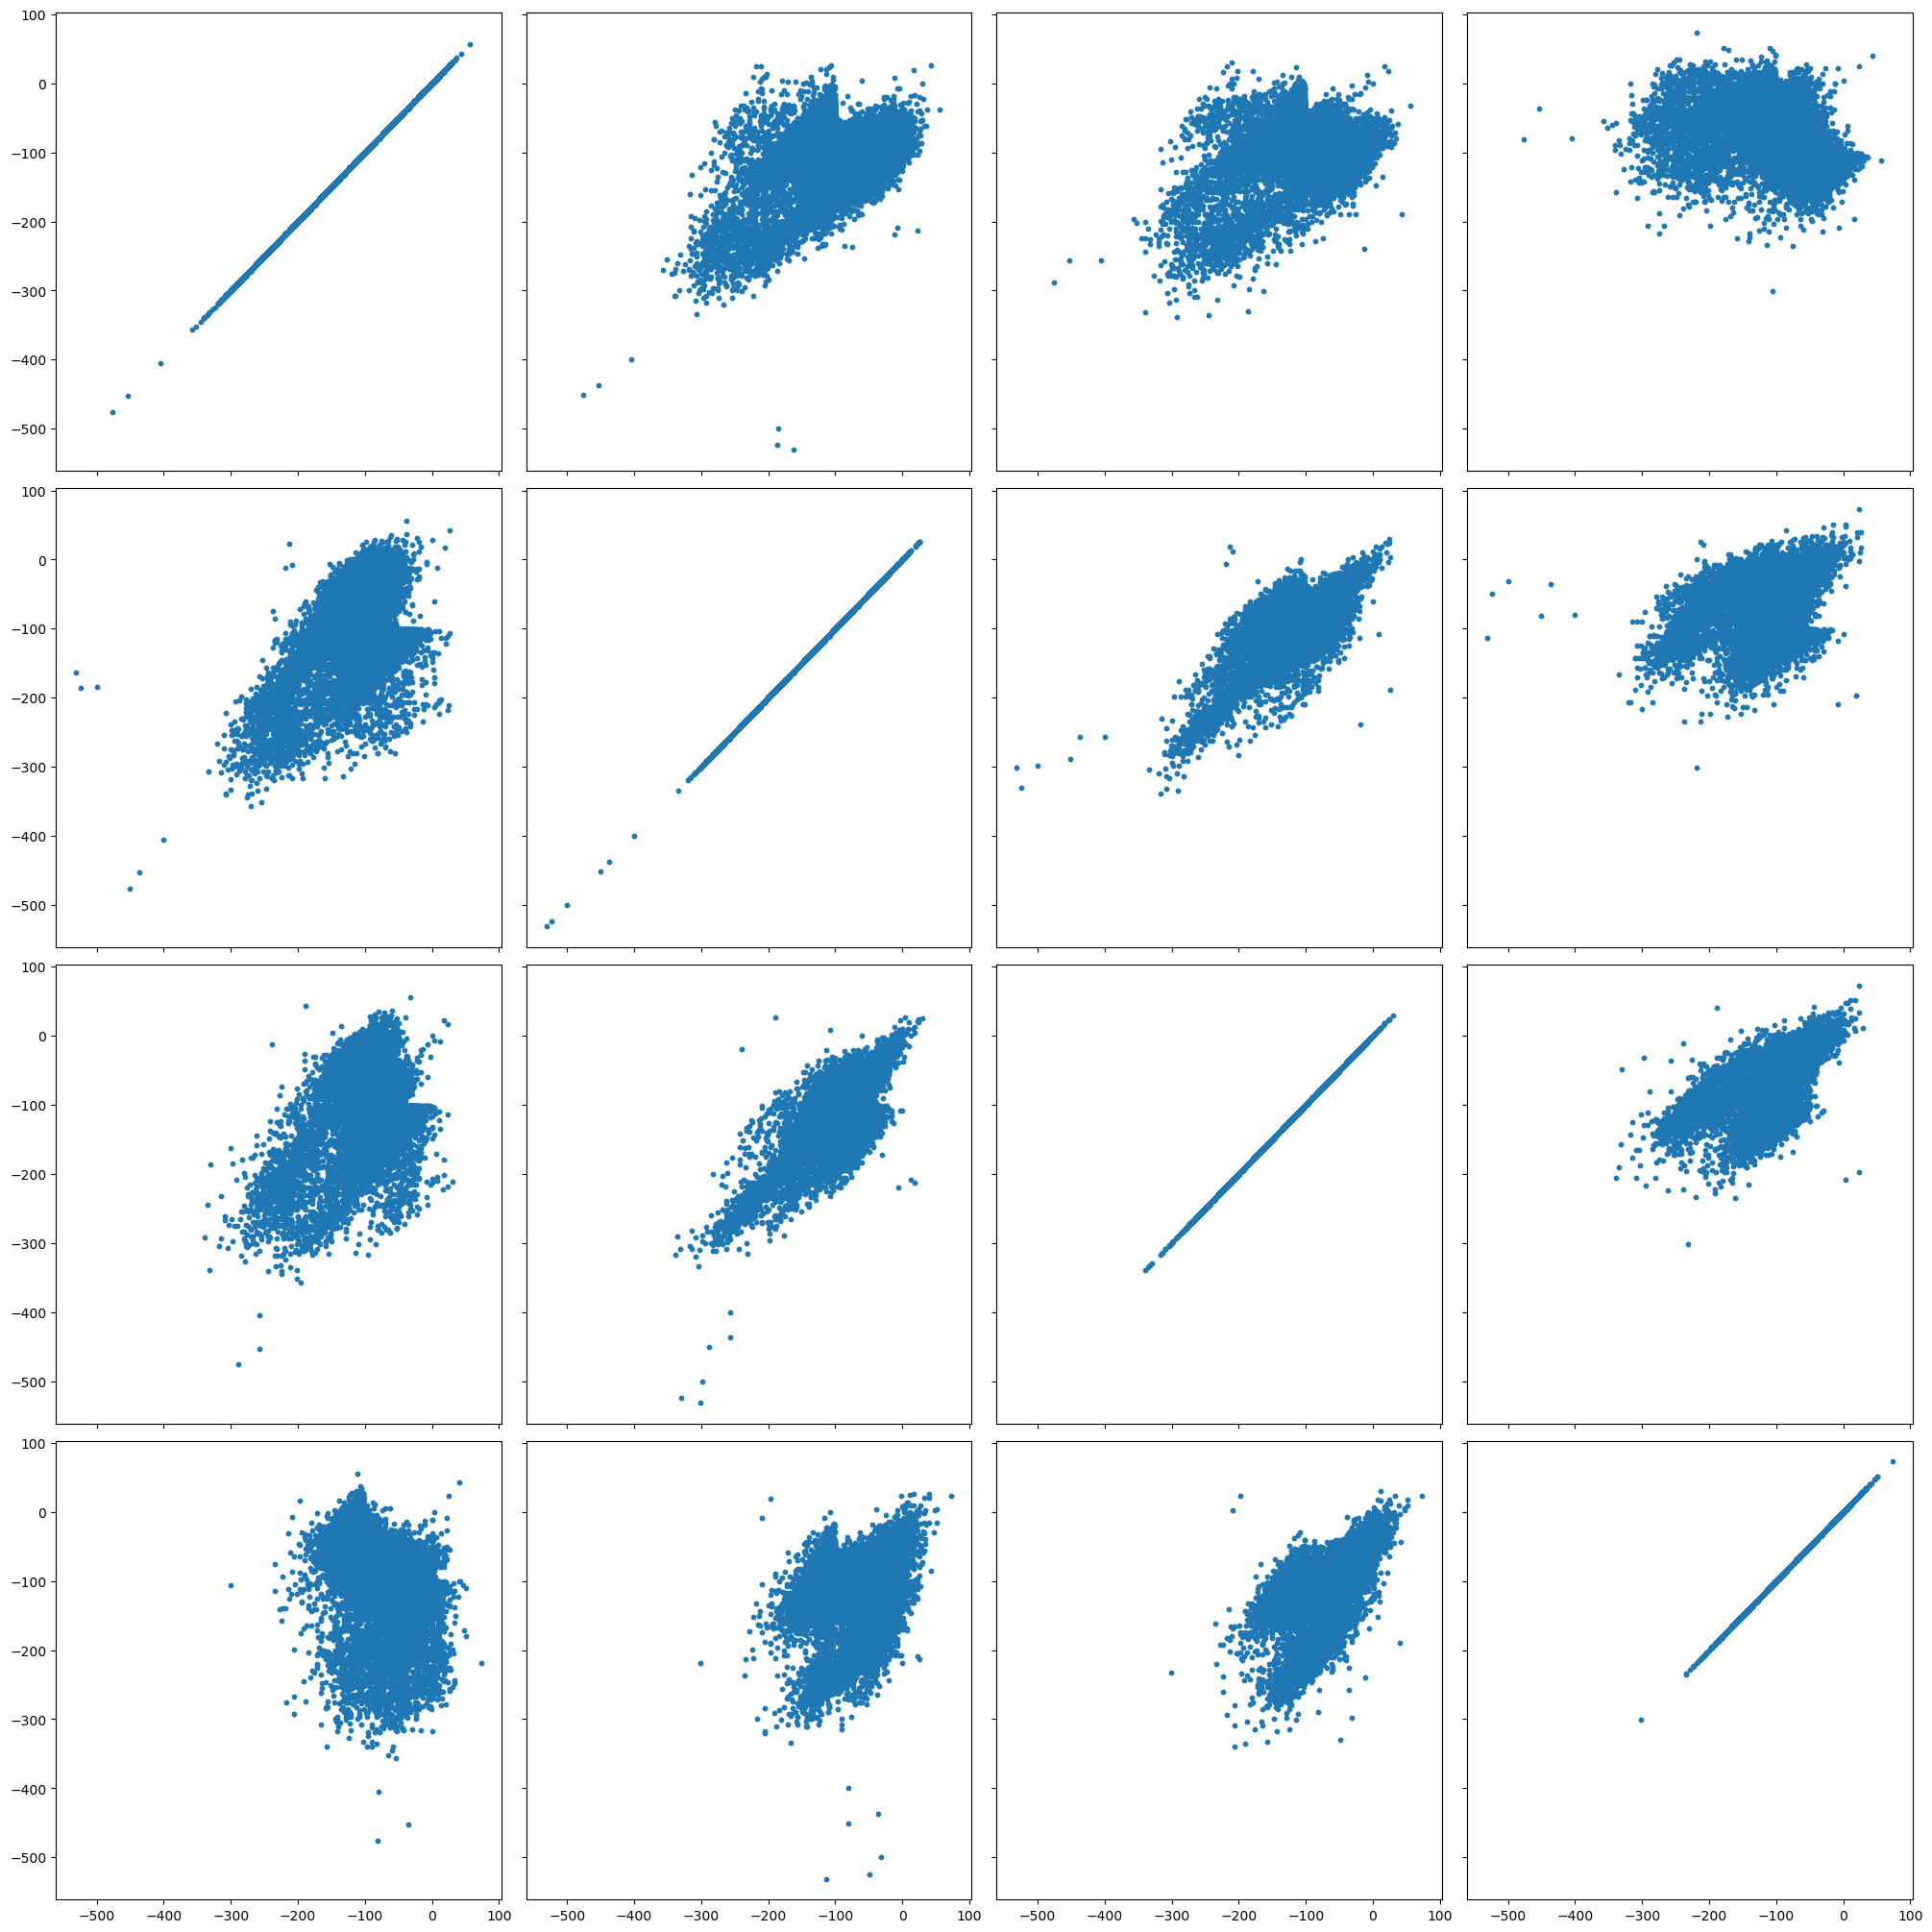

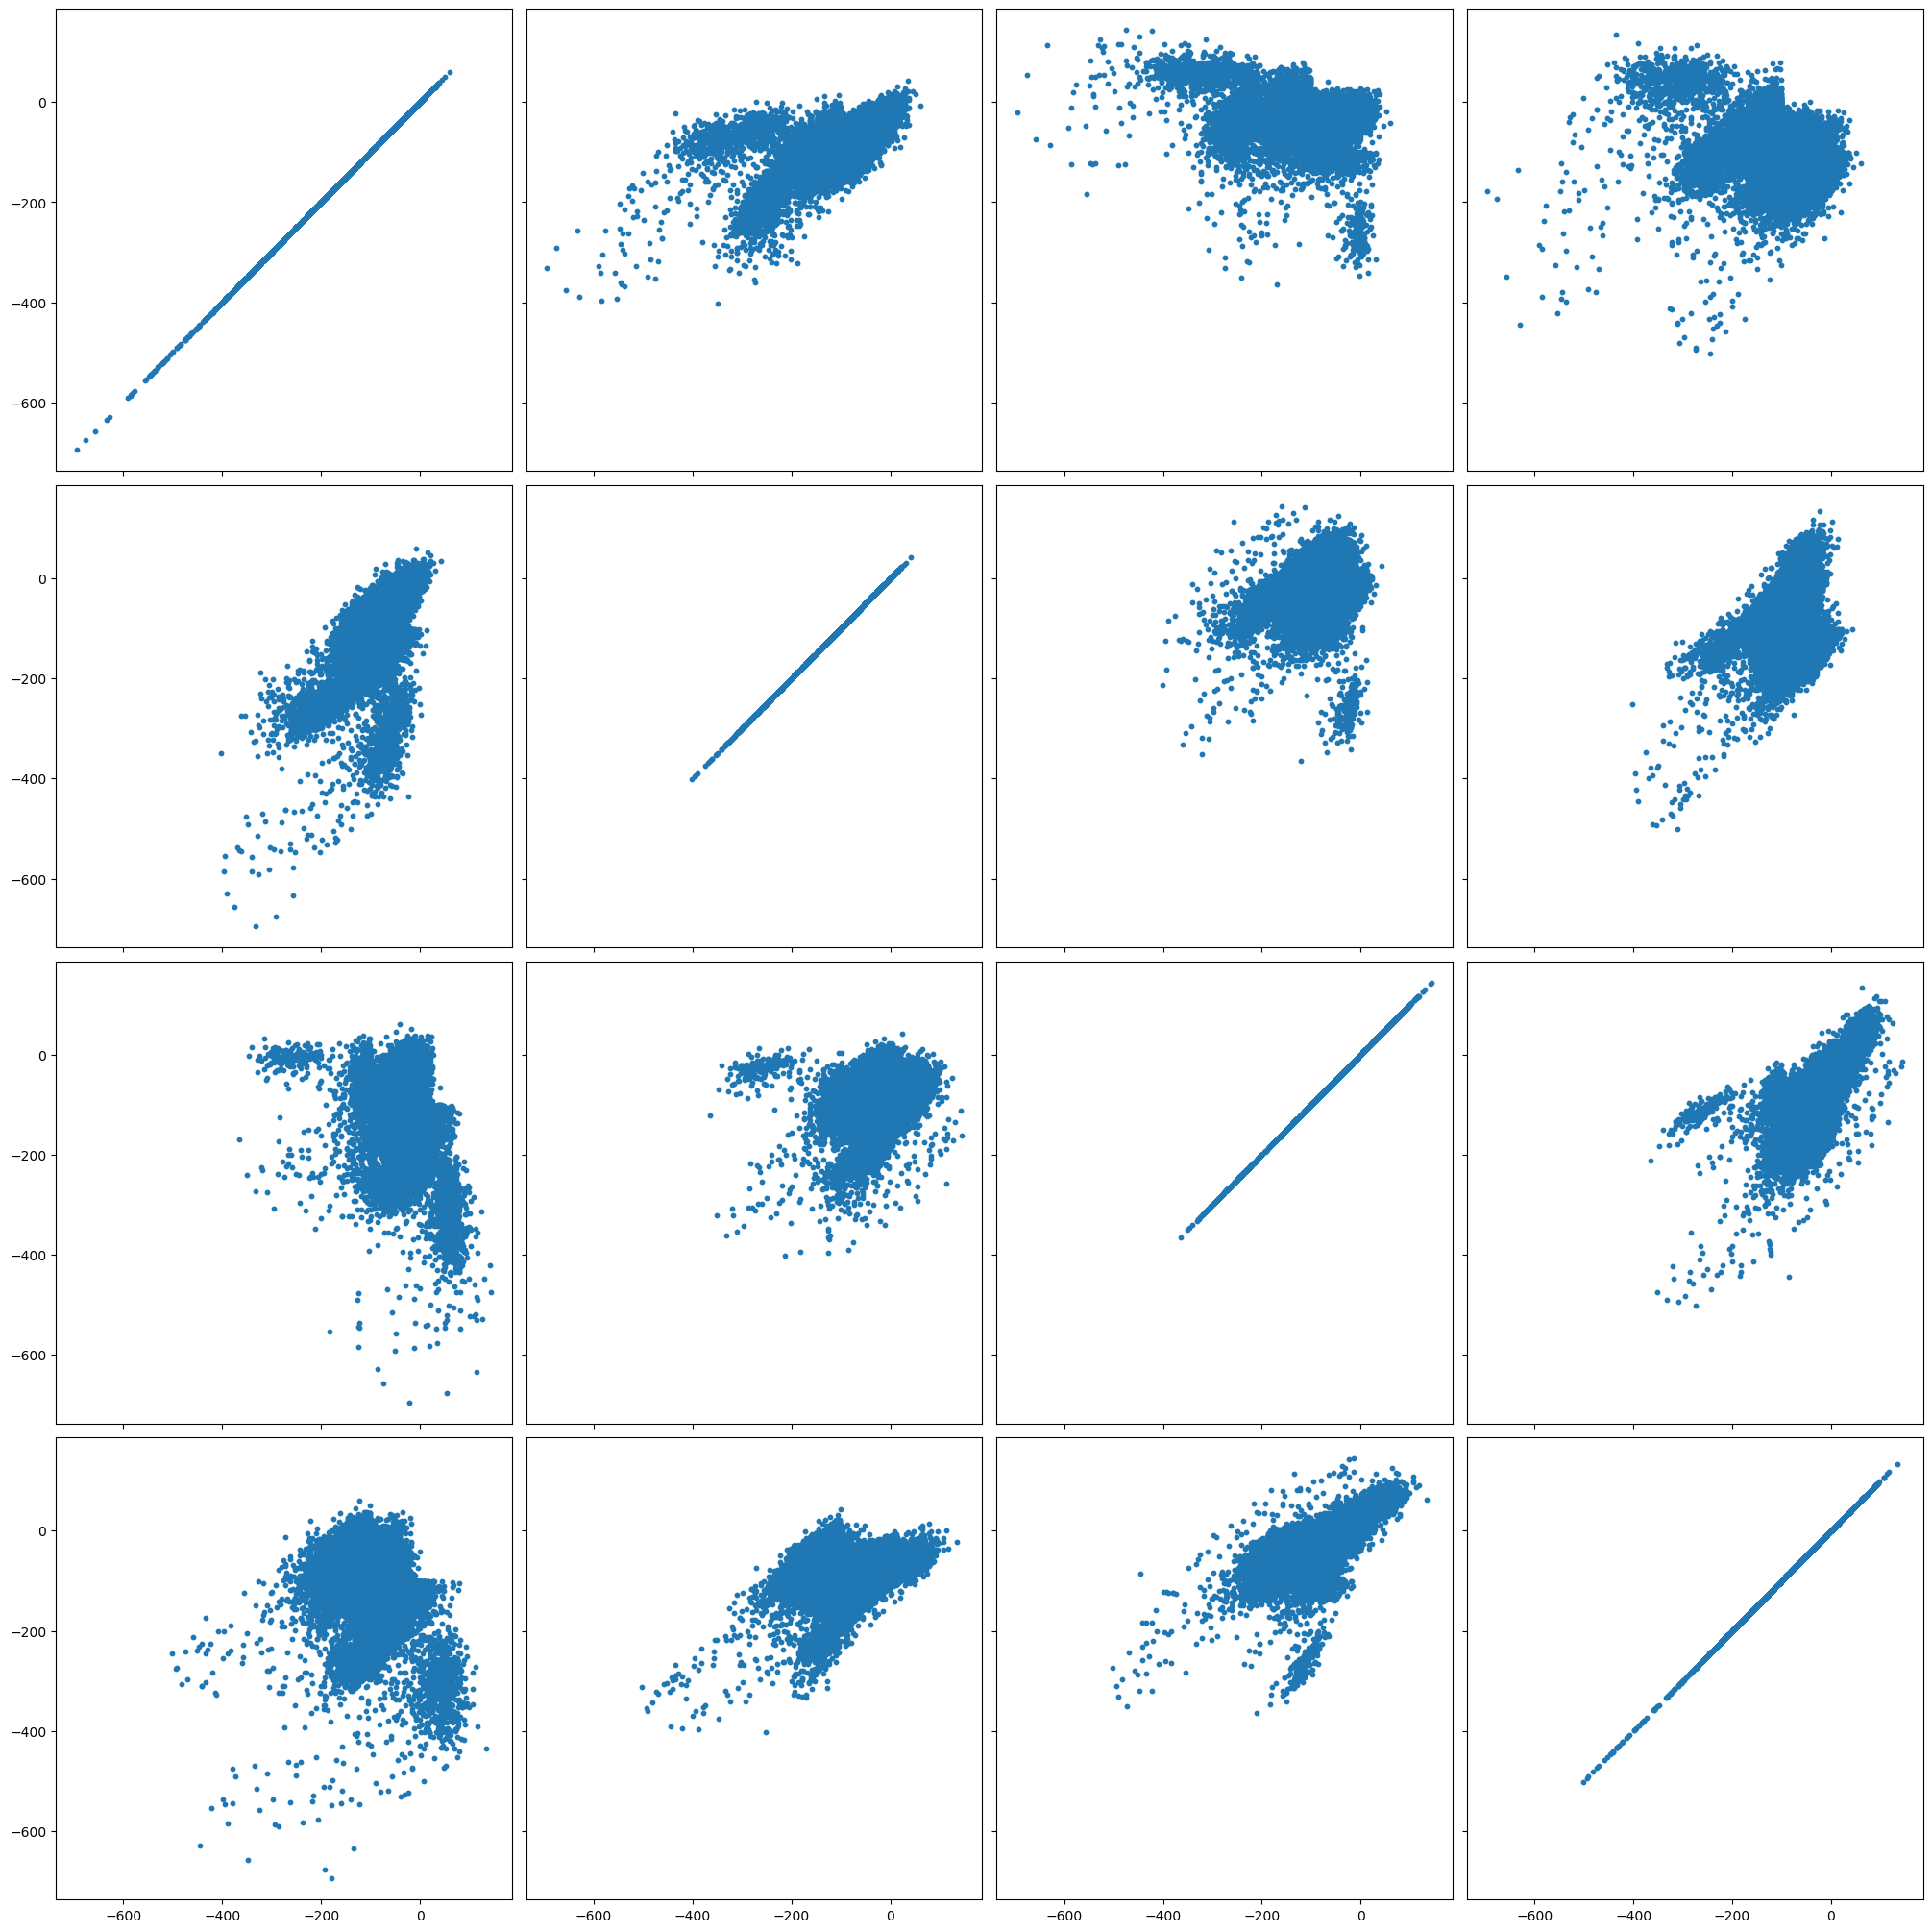

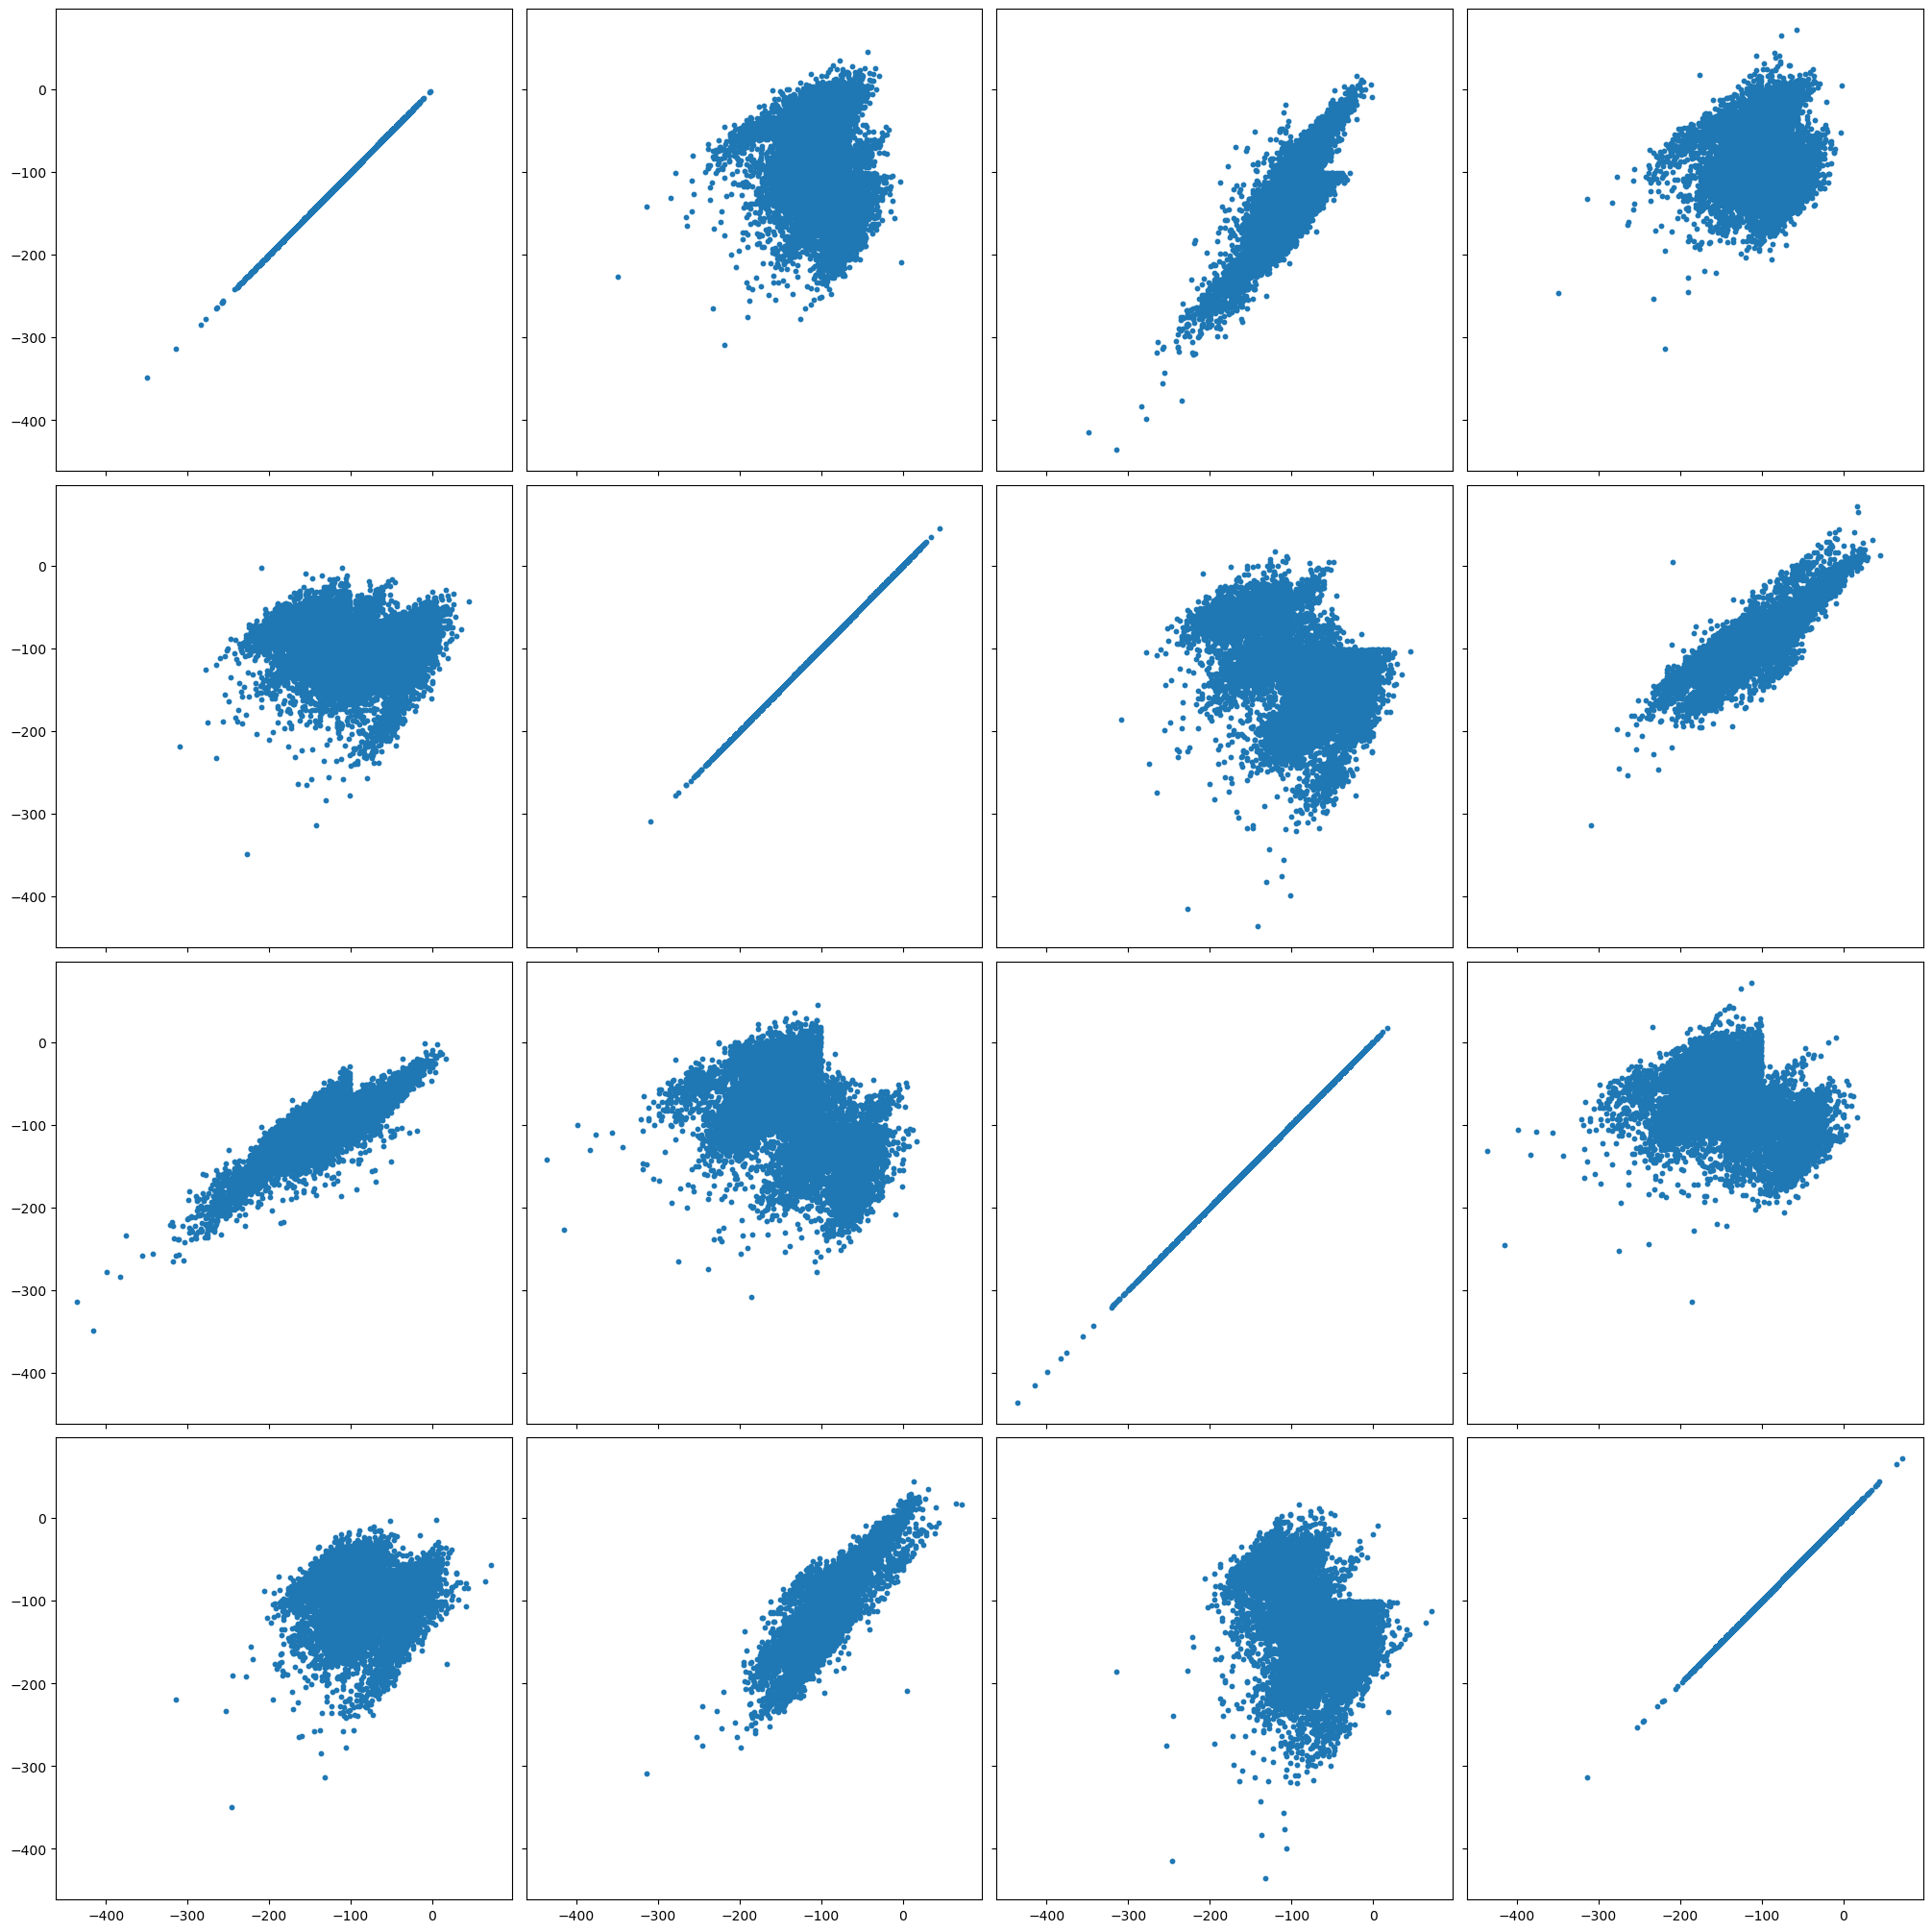

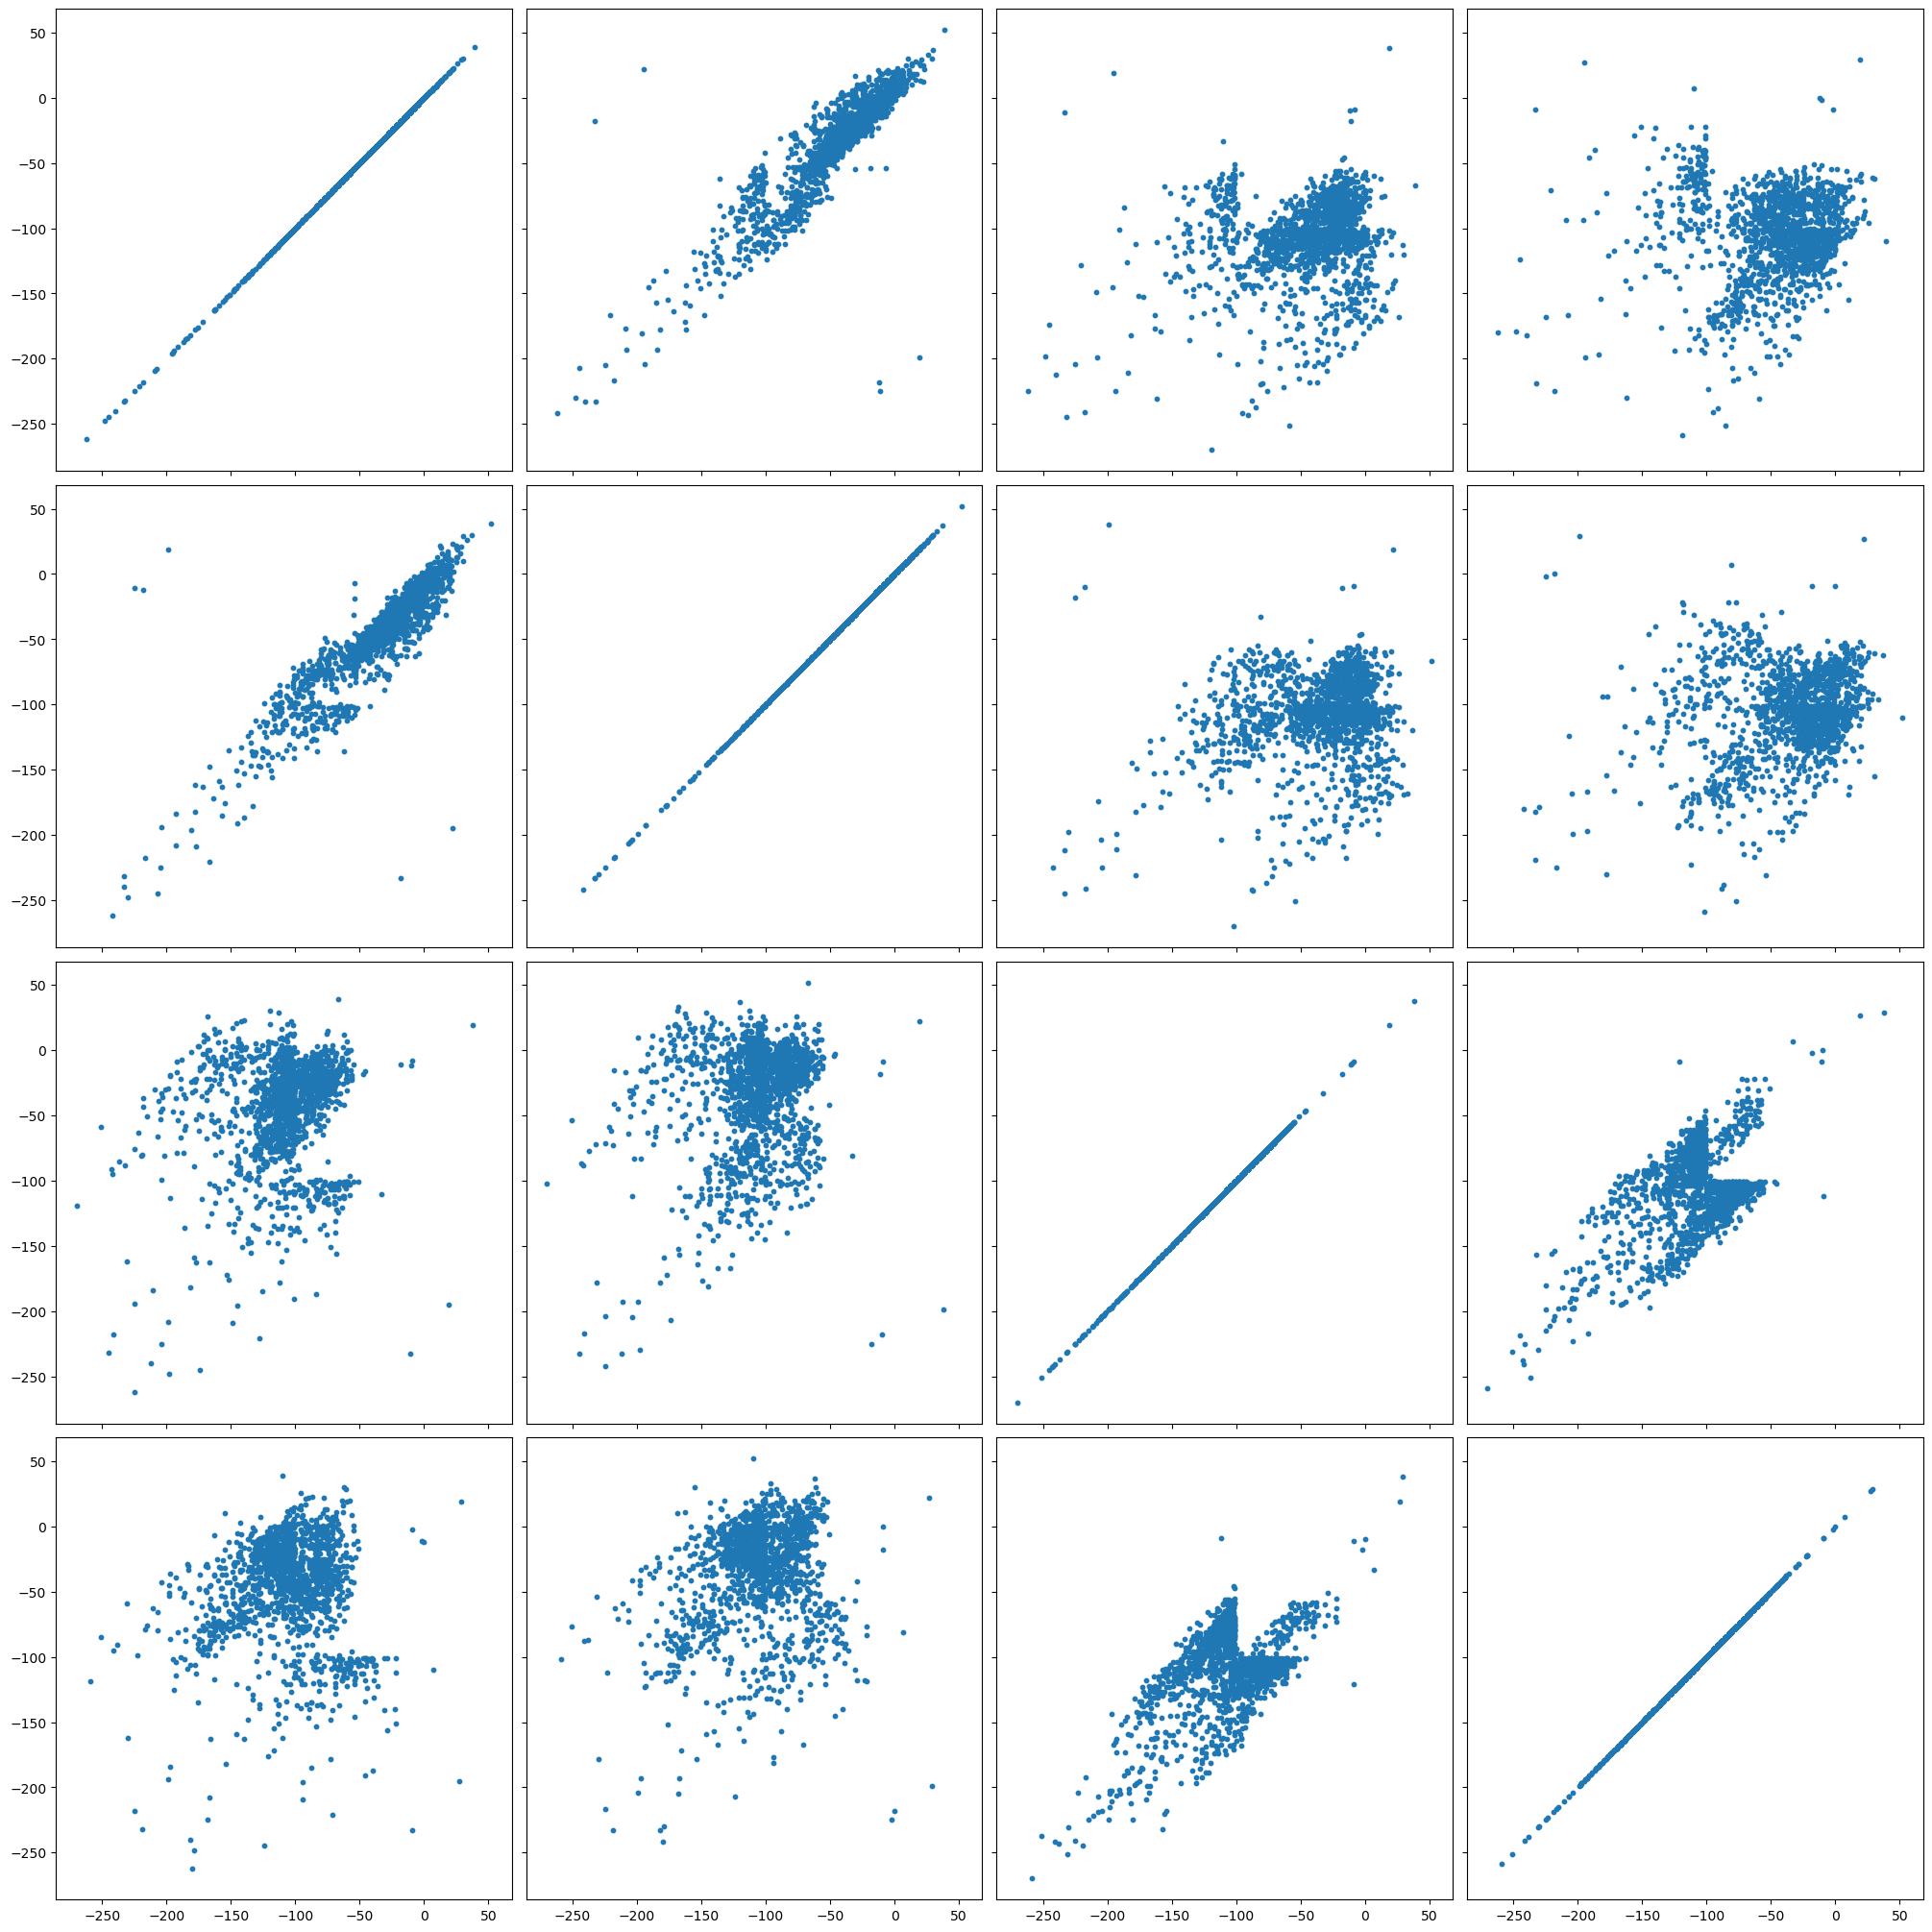

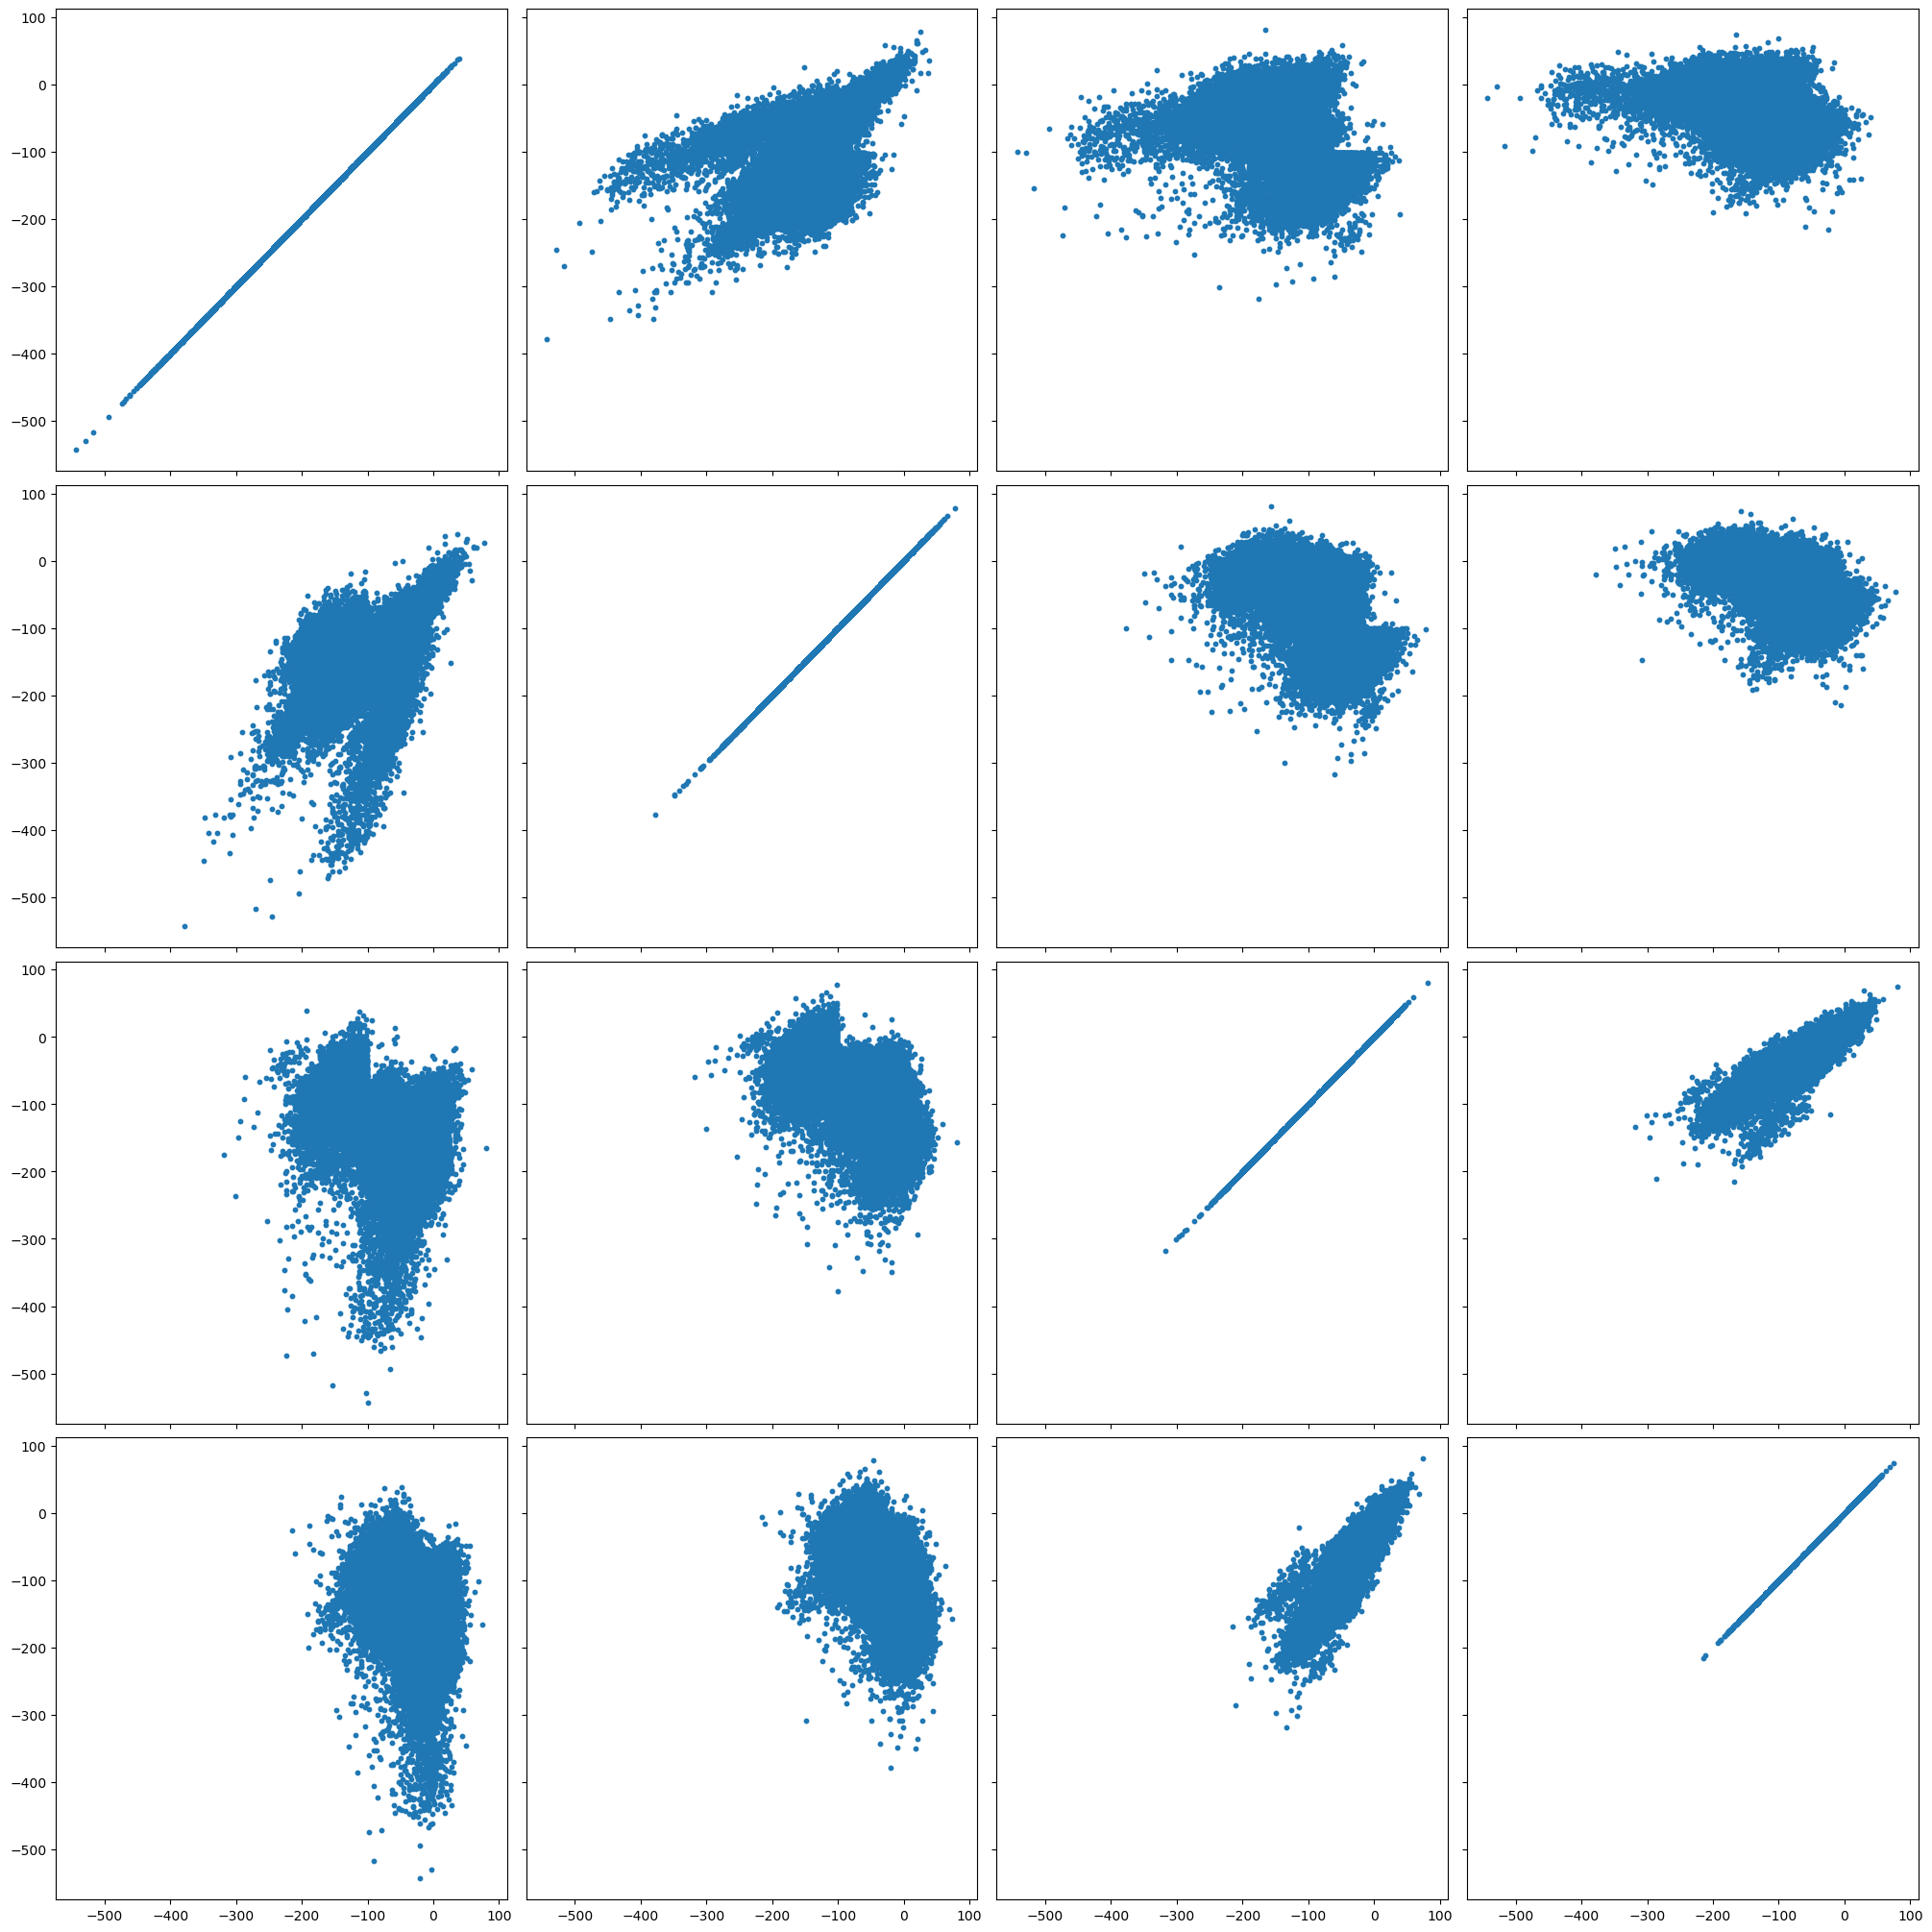

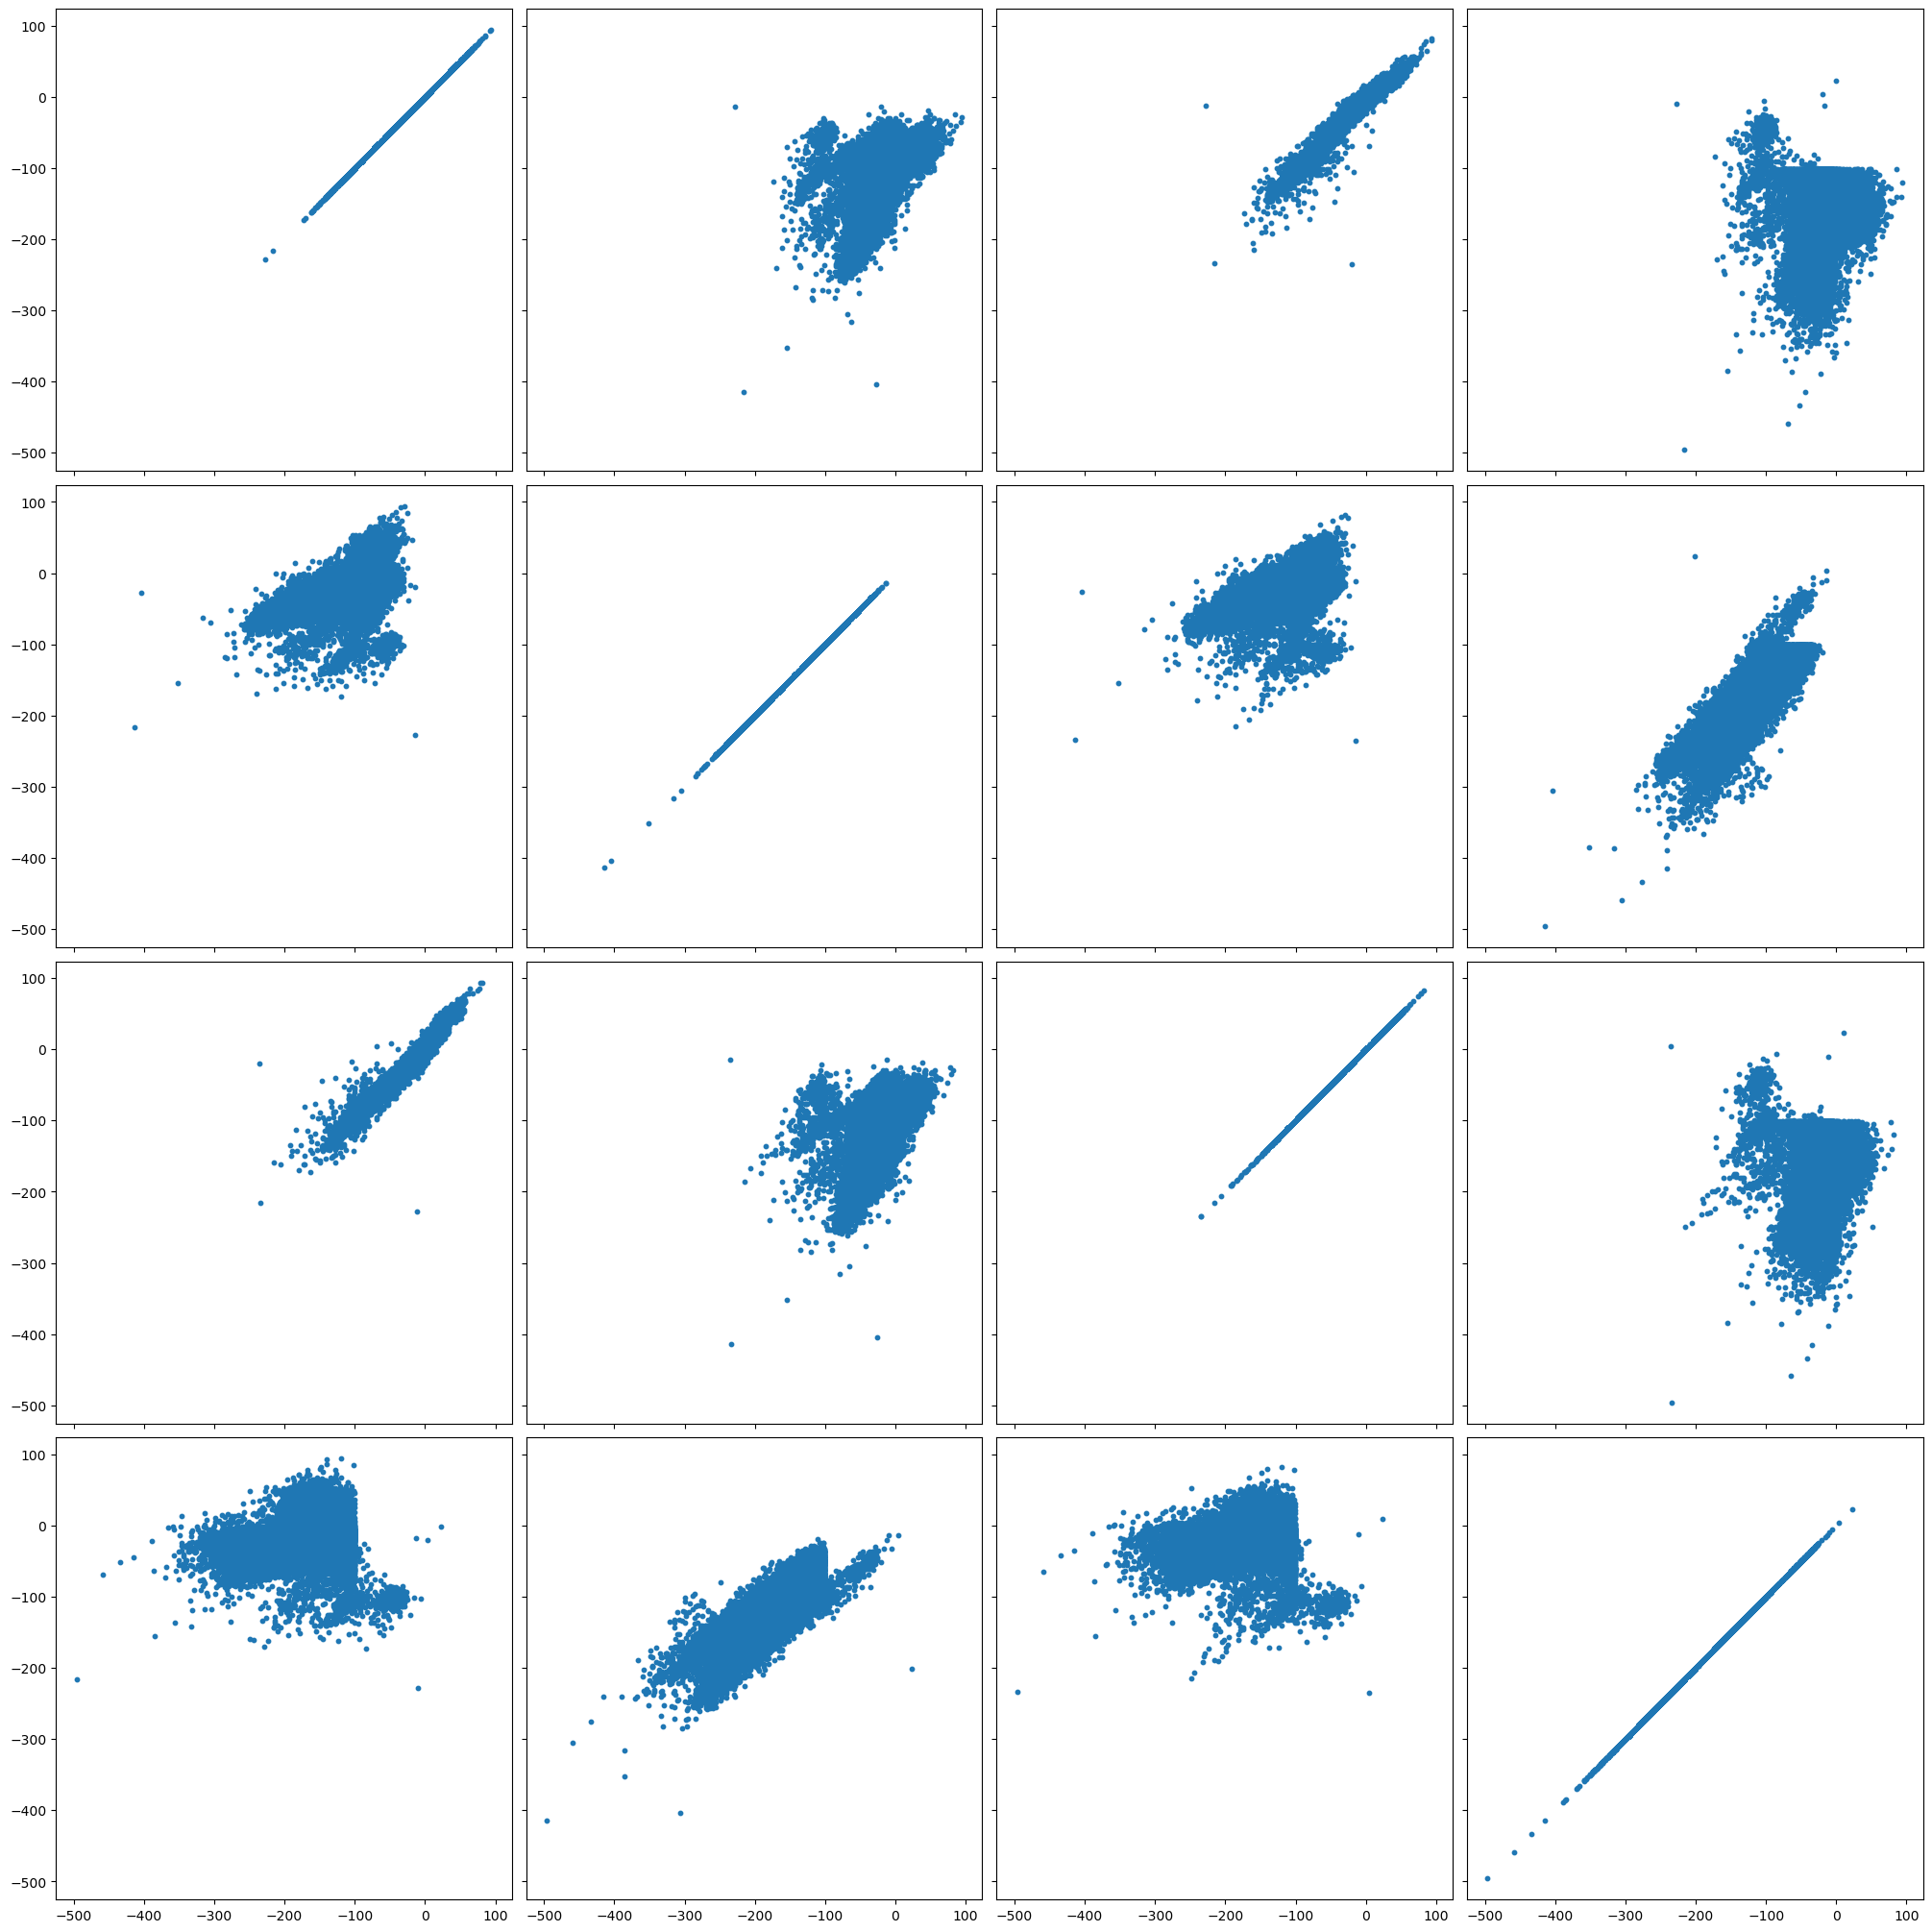

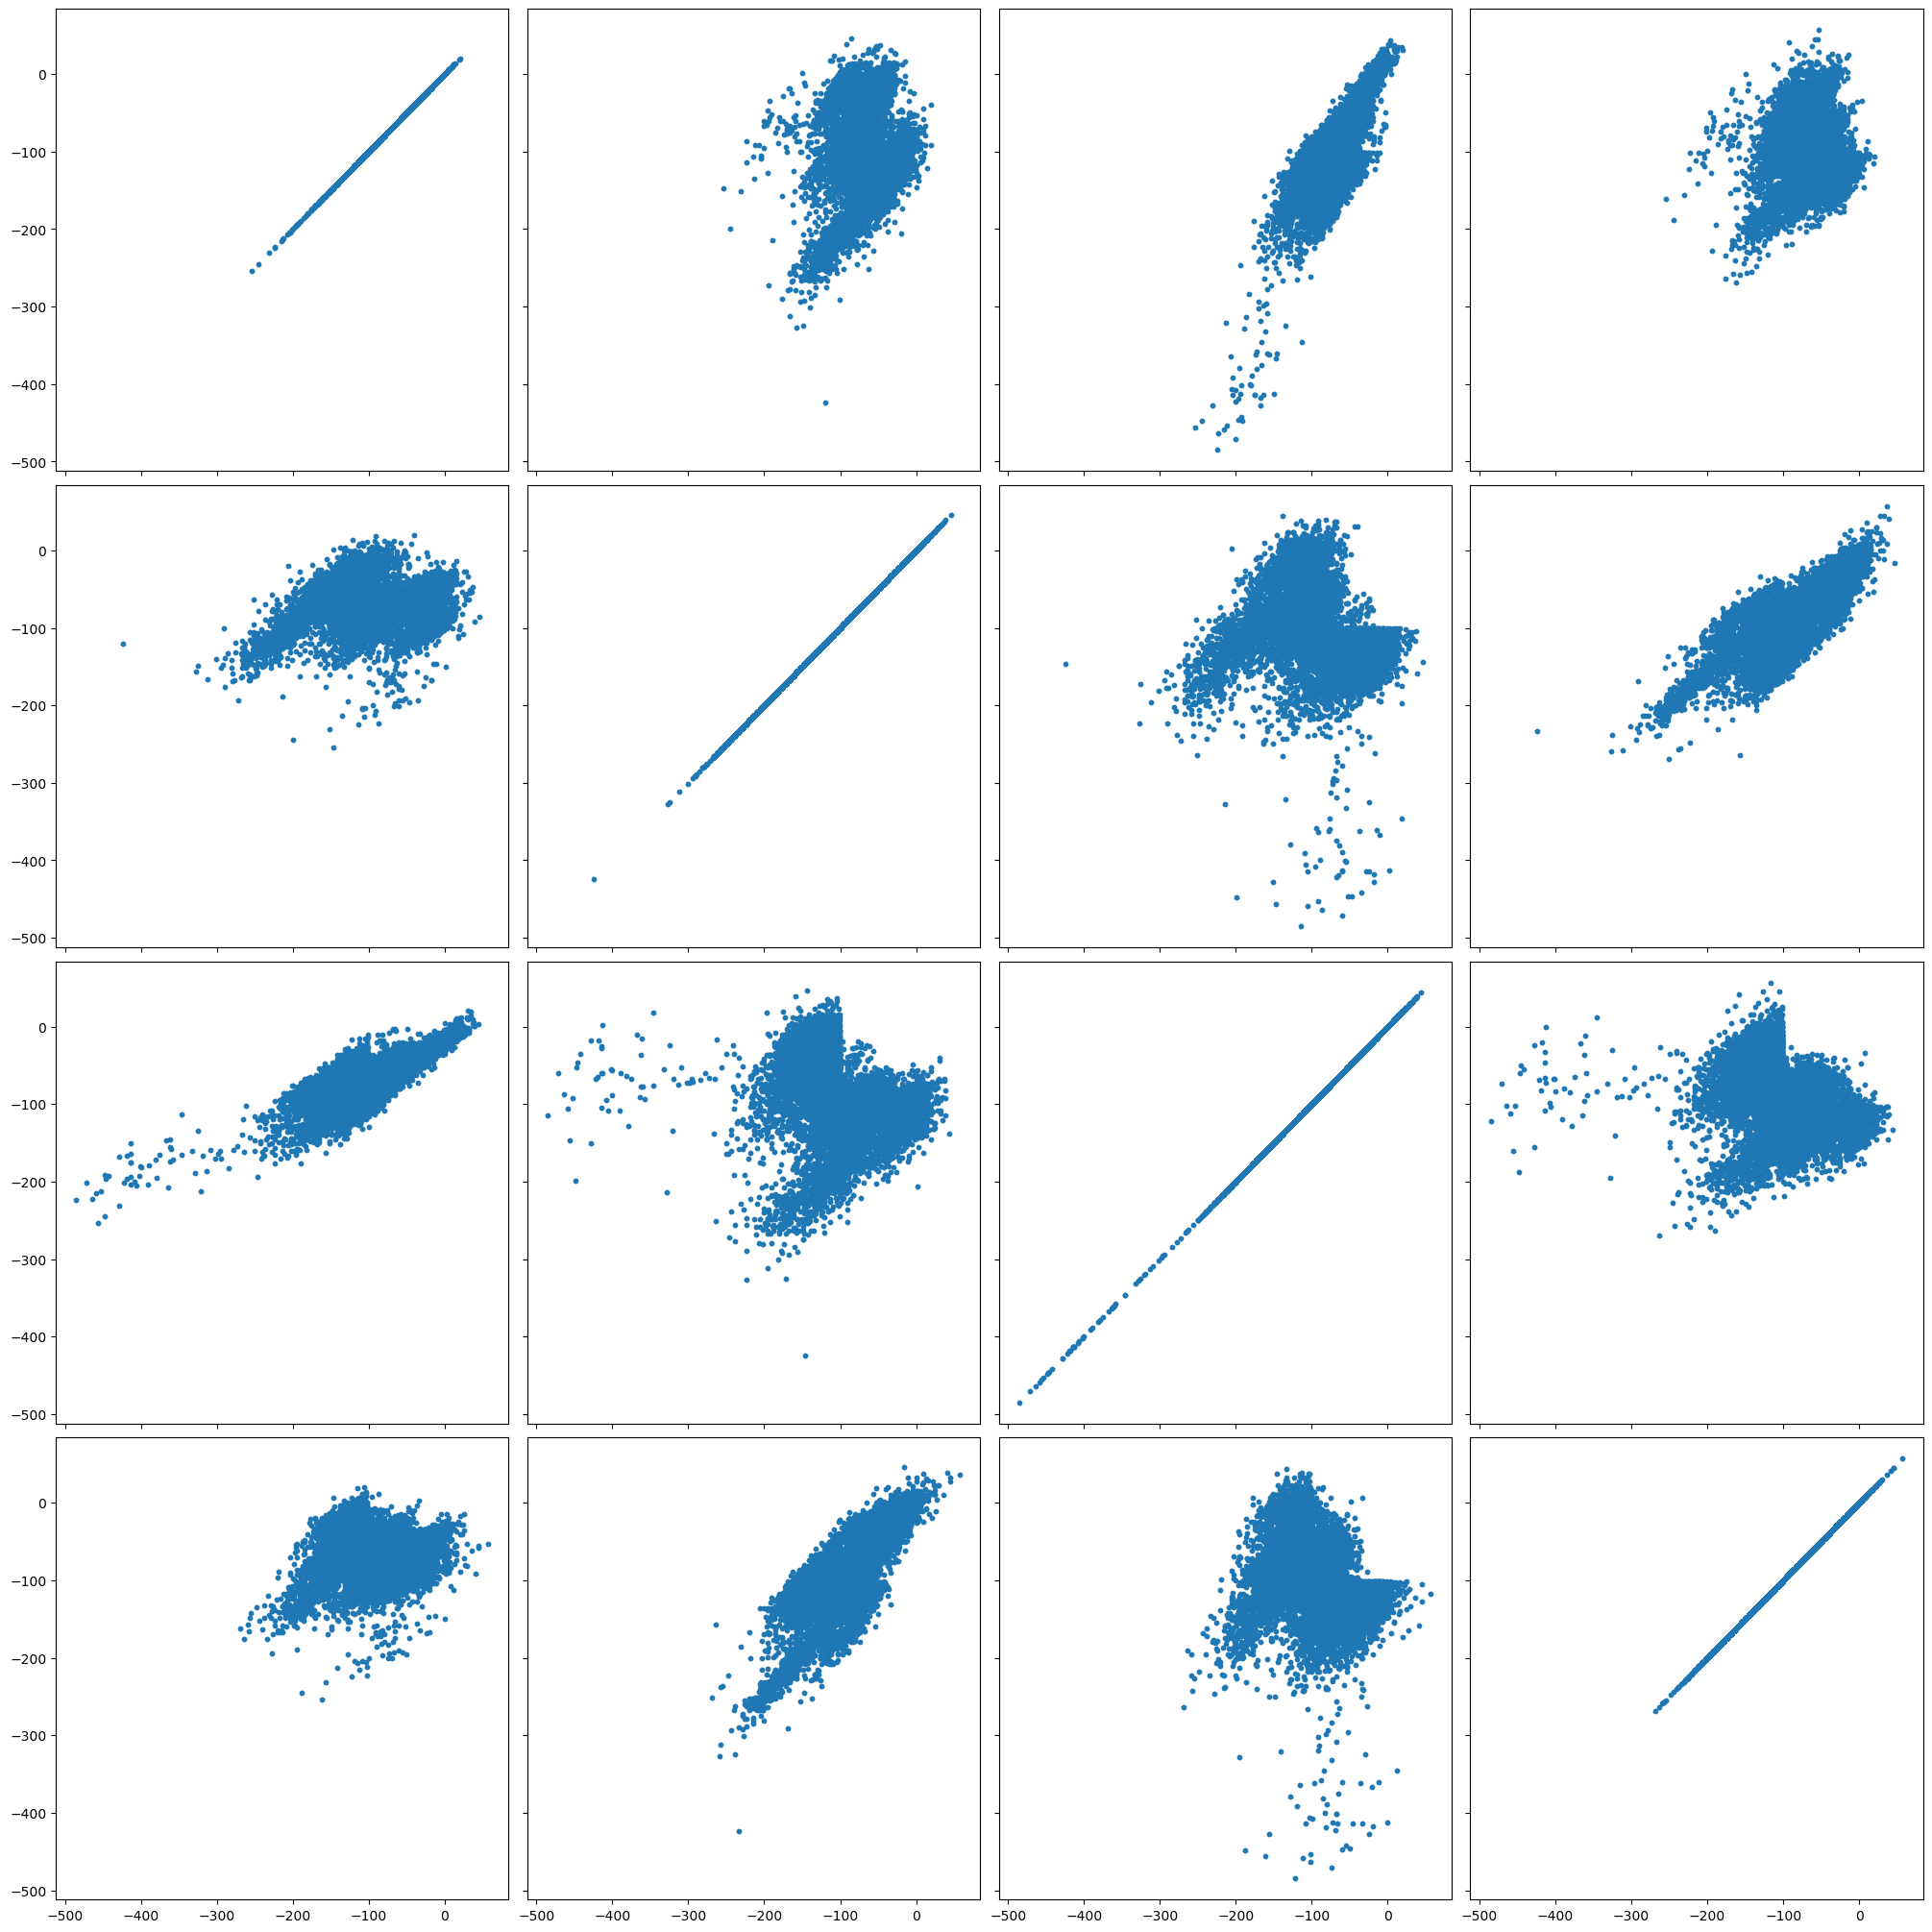

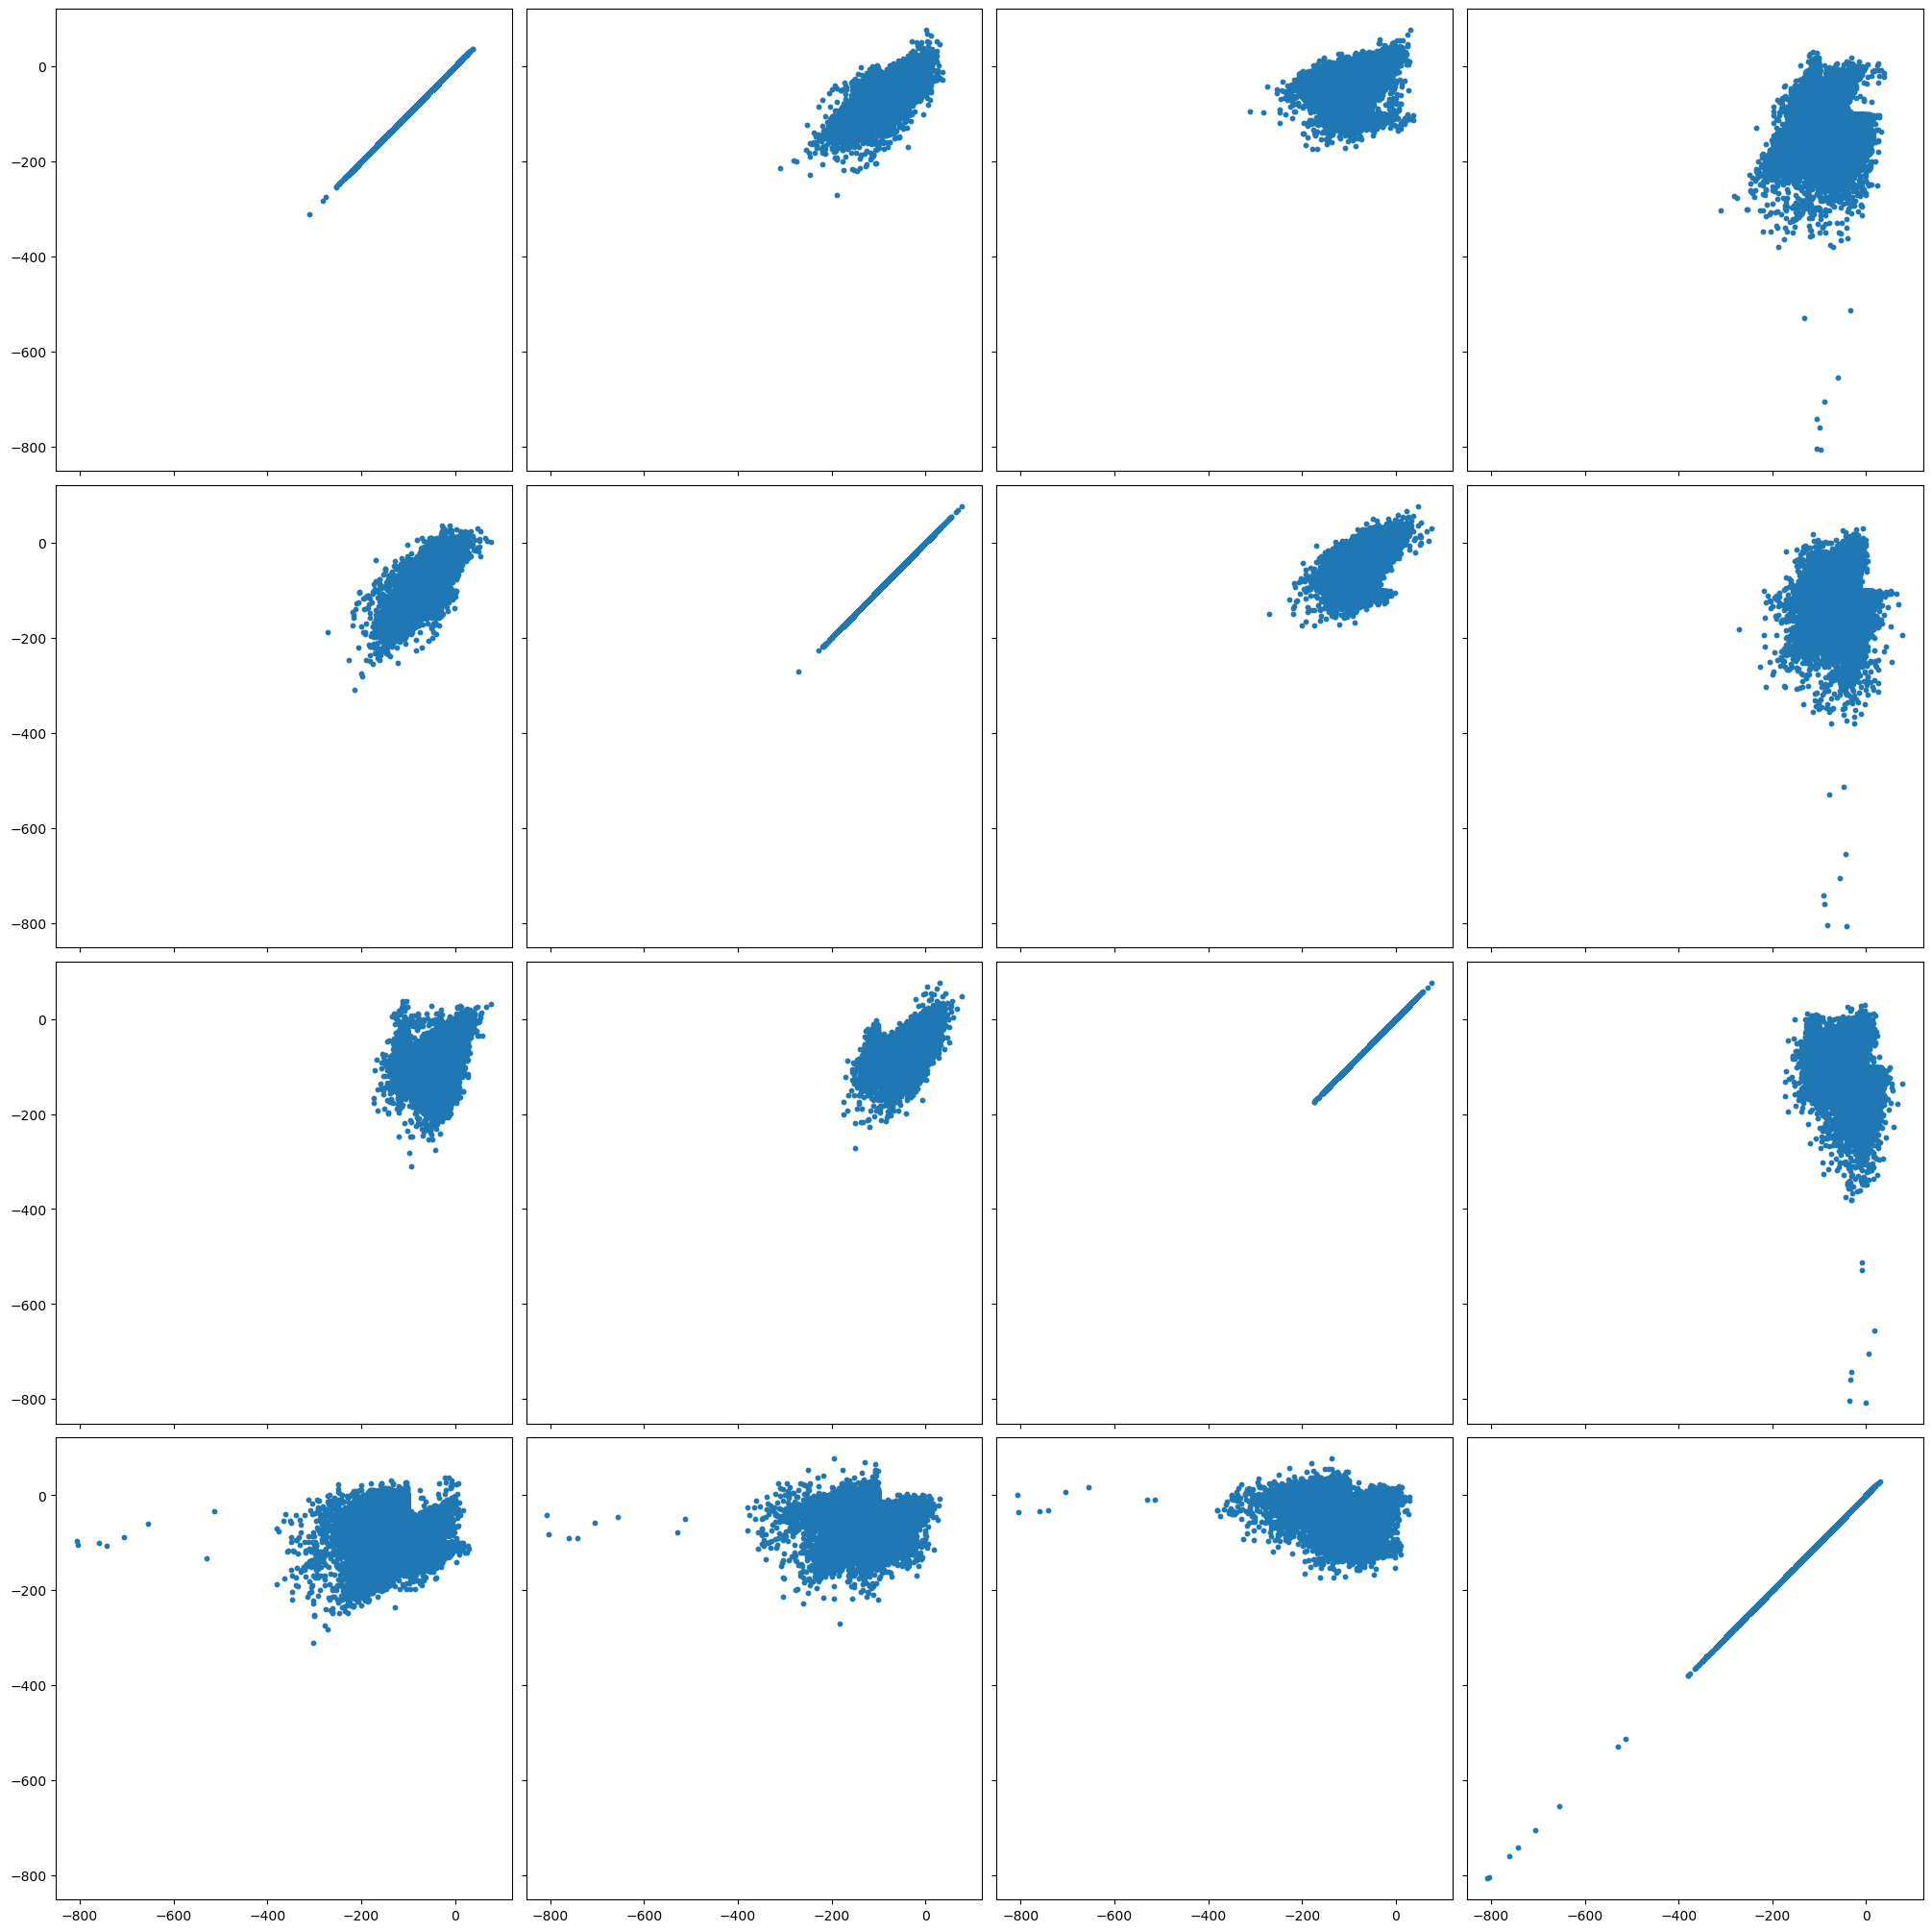

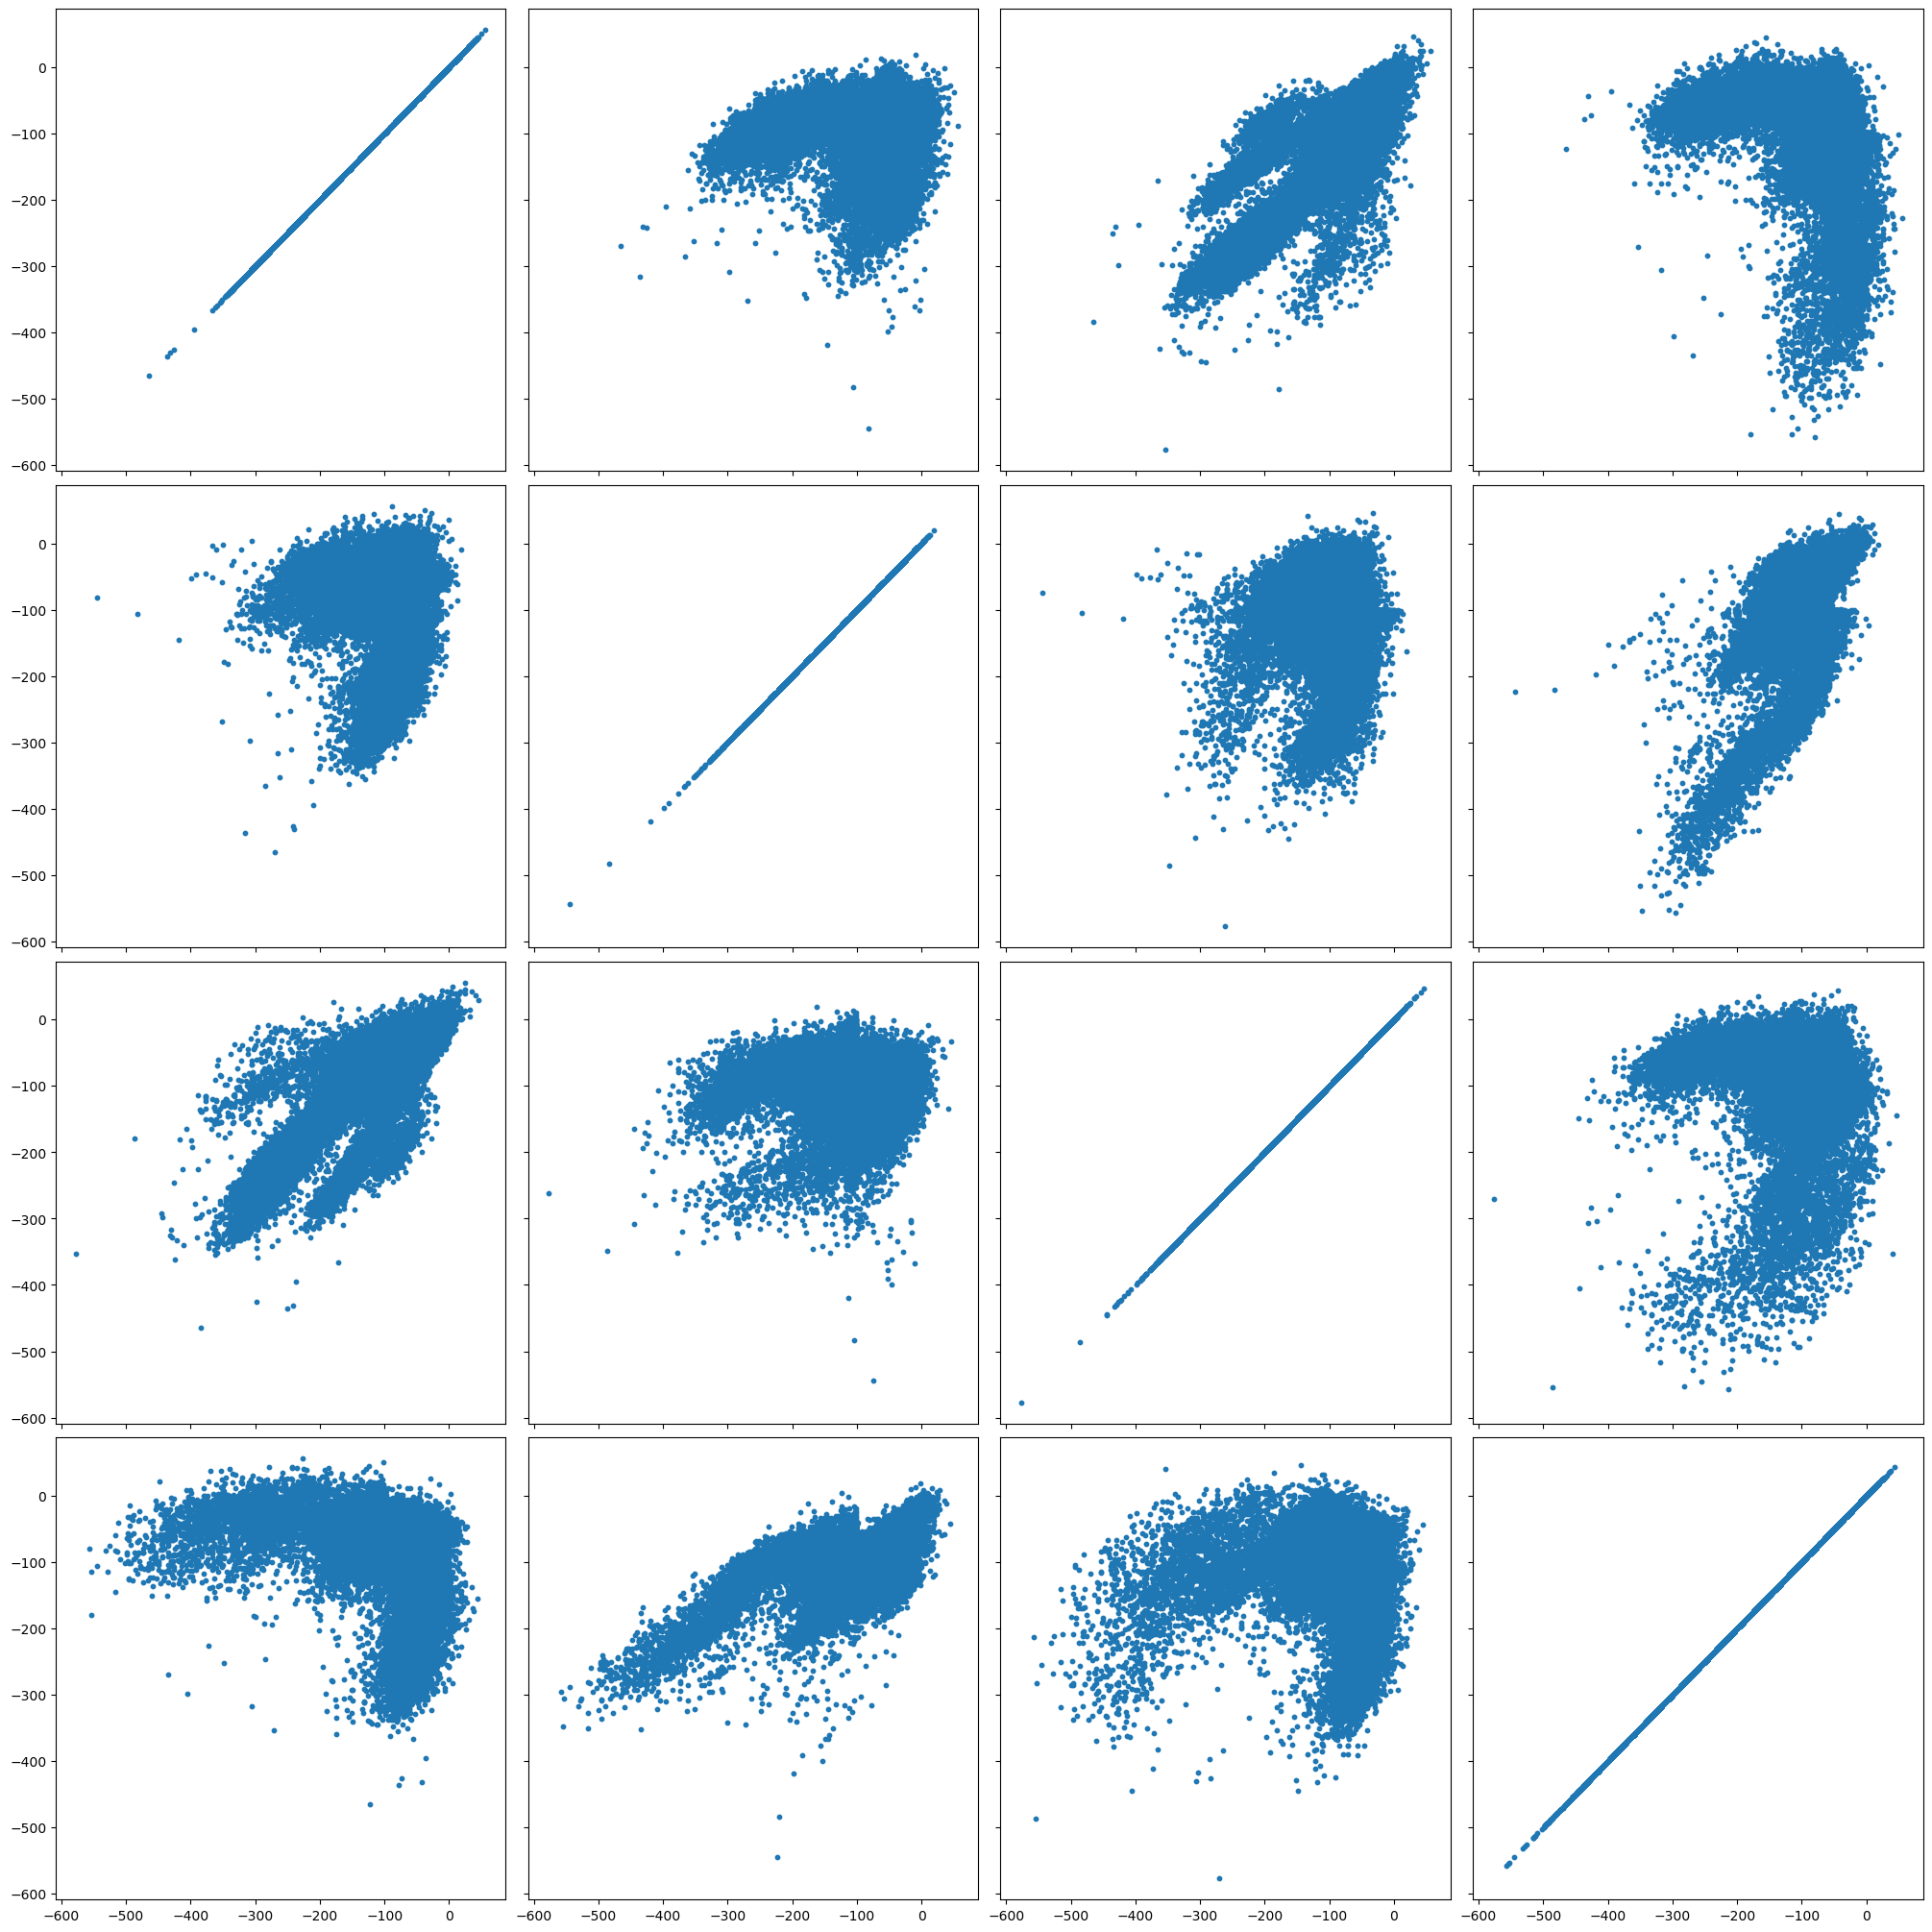

In [11]:
sgd_clusterless.UnitMarksIndicator.plot_all_marks(marks, plot_limit=2)

## Position


### Get position

Next, we'll grab the 2D position data from `IntervalPositionInfo` table. 

_Note:_ Position will need to be upsampled to our decoding frequency (500 Hz).
See [this notebook](./20_Position_Trodes.ipynb#upsampling-position) for more
information.

In [12]:
position_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": "pos 1 valid times",
    "position_info_param_name": "default_decoding",
}

position_info = (
    sgc_pos.IntervalPositionInfo() & position_key
).fetch1_dataframe()

position_info

/stelmo/nwb/analysis/chimi20200216_new_6YC9LPAR7S.nwb


head_position_x  head_position_y  head_orientation  \
time                                                               
1.581887e+09        91.051650       211.127050          2.680048   
1.581887e+09        91.039455       211.144123          3.003241   
1.581887e+09        91.027260       211.161196          3.008398   
1.581887e+09        91.015065       211.178268          3.012802   
1.581887e+09        91.002871       211.195341          3.017242   
...                       ...              ...               ...   
1.581888e+09       182.158583       201.299625         -0.944304   
1.581888e+09       182.158583       201.296373         -0.942329   
1.581888e+09       182.158583       201.293121         -0.940357   
1.581888e+09       182.158583       201.289869         -0.953059   
1.581888e+09       182.158583       201.286617         -0.588081   

              head_velocity_x  head_velocity_y  head_speed  
time                                                        
1.581887e+09         1.741550         2.301478    2.886139  
1.581887e+09         1.827555         2.333931    2.964320  
1.581887e+09         1.915800         2.366668    3.044898  
1.581887e+09         2.006286         2.399705    3.127901  
1.581887e+09         2.099012         2.433059    3.213352  
...                       ...              ...         ...  
1.581888e+09         0.057520        -0.356012    0.360629  
1.581888e+09         0.053954        -0.356343    0.360404  
1.581888e+09         0.050477        -0.356407    0.359964  
1.581888e+09         0.047091        -0.356212    0.359312  
1.581888e+09         0.043796        -0.355764    0.358450  

[655645 rows x 6 columns]

### Plot position

It is important to visualize the 2D position and identify outliers.

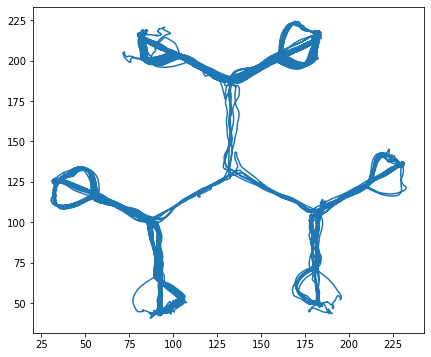

In [11]:
plt.figure(figsize=(7, 6))
plt.plot(position_info.head_position_x, position_info.head_position_y)

For 1D decoding, we load the linearized position tables.

In [13]:
if decode_1d:
    linearization_key = {
        "position_info_param_name": "default_decoding",
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
        "track_graph_name": "6 arm",
        "linearization_param_name": "default",
    }

    linear_position_df = (
        sgc_pos.IntervalLinearizedPosition() & linearization_key
    ).fetch1_dataframe()

    linear_position_df
else:
    linear_position_df = position_info

/stelmo/nwb/analysis/chimi20200216_new_0YEJJLYTSM.nwb


linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.581887e+09       412.042773                 0             90.802281   
1.581887e+09       412.061718                 0             90.785714   
1.581887e+09       412.080664                 0             90.769147   
1.581887e+09       412.099610                 0             90.752579   
1.581887e+09       412.118556                 0             90.736012   
...                       ...               ...                   ...   
1.581888e+09       340.325042                 1            175.434739   
1.581888e+09       340.323413                 1            175.433329   
1.581888e+09       340.321785                 1            175.431919   
1.581888e+09       340.320156                 1            175.430509   
1.581888e+09       340.318527                 1            175.429100   

              projected_y_position  
time                                
1.581887e+09            210.677533  
1.581887e+09            210.686724  
1.581887e+09            210.695914  
1.581887e+09            210.705105  
1.581887e+09            210.714296  
...                            ...  
1.581888e+09            212.920160  
1.581888e+09            212.919345  
1.581888e+09            212.918529  
1.581888e+09            212.917713  
1.581888e+09            212.916898  

[655645 rows x 4 columns]

We'll also sanity check linearized values by plotting the 2D position projected
to its corresponding 1D segment.

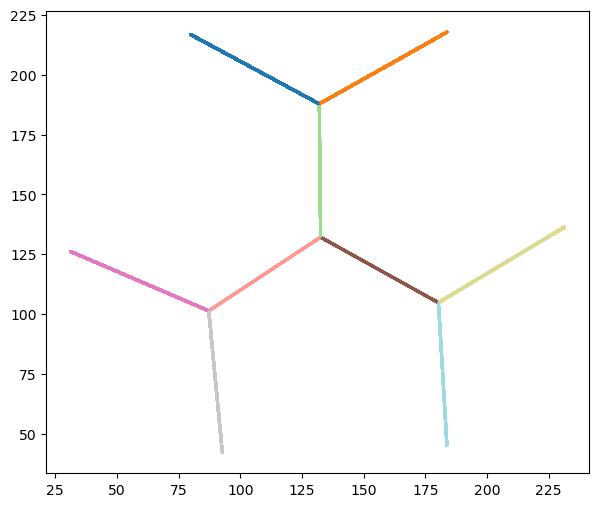

In [14]:
if decode_1d:
    plt.figure(figsize=(7, 6))
    plt.scatter(
        linear_position_df.projected_x_position,
        linear_position_df.projected_y_position,
        c=linear_position_df.track_segment_id,
        cmap="tab20",
        s=1,
    )

And then the linearized position itself:

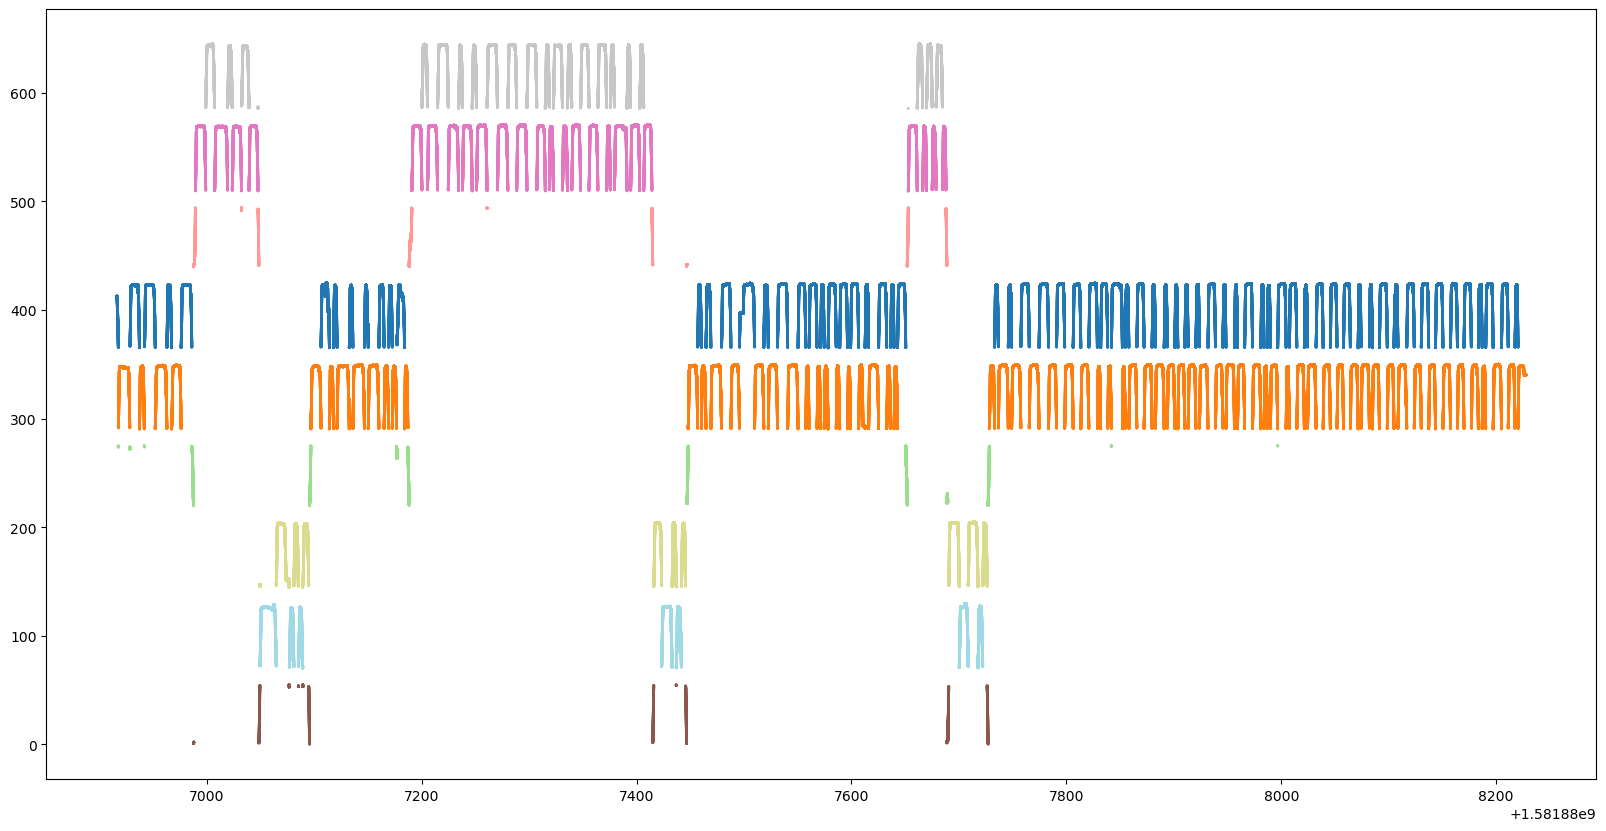

In [15]:
if decode_1d:
    plt.figure(figsize=(20, 10))
    plt.scatter(
        linear_position_df.index,
        linear_position_df.linear_position,
        s=1,
        c=linear_position_df.track_segment_id,
        cmap="tab20",
    )

And then, we'll verify that all our data is the same size. It may not be due to
the valid intervals of the neural and position data.

In [17]:
position_info.shape, marks.shape, linear_position_df.shape

((655645, 6), (655645, 4, 22), (655645, 4))

## Validate data

We'll also validate the ephys and position data for decoding. If we had more
than one time interval, we would decode on each separately.

In [18]:
key = {}
key["interval_list_name"] = "02_r1"
key["nwb_file_name"] = nwb_copy_file_name

interval = (
    sgc.IntervalList
    & {
        "nwb_file_name": key["nwb_file_name"],
        "interval_list_name": key["interval_list_name"],
    }
).fetch1("valid_times")

valid_ephys_times = (
    sgc.IntervalList
    & {
        "nwb_file_name": key["nwb_file_name"],
        "interval_list_name": "raw data valid times",
    }
).fetch1("valid_times")
position_interval_names = (
    sgc_pos.IntervalPositionInfo
    & {
        "nwb_file_name": key["nwb_file_name"],
        "position_info_param_name": "default_decoding",
    }
).fetch("interval_list_name")
valid_pos_times = [
    (
        sgc.IntervalList
        & {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": pos_interval_name,
        }
    ).fetch1("valid_times")
    for pos_interval_name in position_interval_names
]

intersect_interval = sgc_int.interval_list_intersect(
    sgc_int.interval_list_intersect(interval, valid_ephys_times),
    valid_pos_times[0],
)
valid_time_slice = slice(intersect_interval[0][0], intersect_interval[0][1])
valid_time_slice

slice(1581886916.3153033, 1581888227.5987928, None)

In [19]:
linear_position_df = linear_position_df.loc[valid_time_slice]
marks = marks.sel(time=valid_time_slice)
position_info = position_info.loc[valid_time_slice]

In [20]:
position_info.shape, marks.shape, linear_position_df.shape

((655643, 6), (655643, 4, 22), (655643, 4))

## Decoding


After sanity checks, we can finally get to decoding. 

_Note:_ Portions of the code below have been integrated into
`spyglass.decoding`, but are presented here in full.

We'll fetch the default parameters and modify them. For 1D decoding, we'll also pass the track graph and parameters from linearization to handle the random walk properly. `position_std` and `mark_std` set the amount of smoothing in the position and mark dimensions. `block_size` controls how many samples get processed at a time so that we don't run out of GPU memory.

In [21]:
parameters = (
    sgd_clusterless.ClusterlessClassifierParameters()
    & {"classifier_param_name": "default_decoding_gpu"}
).fetch1()

algorithm_params = (
    {
        "mark_std": 24.0,
        "position_std": 6.0,
        "block_size": 2**12,  # in merging nbs, changed from 2**13 for 2d
    },
)

if decode_1d:
    track = sgc_pos.TrackGraph() & {"track_graph_name": "6 arm"}
    track_graph = track.get_networkx_track_graph()
    track_graph_params = track.fetch1()

    parameters["classifier_params"] = {
        "environments": [
            rtc_env.Environment(
                track_graph=track_graph,
                edge_order=track_graph_params["linear_edge_order"],
                edge_spacing=track_graph_params["linear_edge_spacing"],
            )
        ],
        "clusterless_algorithm": "multiunit_likelihood_integer_gpu",
        "clusterless_algorithm_params": algorithm_params,
    }
else:
    parameters["classifier_params"] = {
        "environments": [rtc_env.Environment(place_bin_size=3.0)],
        "clusterless_algorithm_params": {
            **algorithm_params,
            "disable_progress_bar": False,
            "use_diffusion": False,
        },
    }

pprint(parameters)

{'classifier_param_name': 'default_decoding_gpu',
 'classifier_params': {'clusterless_algorithm': 'multiunit_likelihood_integer_gpu',
                       'clusterless_algorithm_params': {'block_size': 4096,
                                                        'mark_std': 24.0,
                                                        'position_std': 6.0},
                       'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_diffusion=False),
                                                        Uniform(environment_name='', environment2_name=None)],
                                                       [Uniform(environment_name='', environment2_name=None),
                                                        Uniform(environment_name='', environment2_name=None)]],
                       'discrete_transition_type': DiagonalDiscrete(diagonal_value=0.98),
                       'environments': [Environment(environment_name

To run decoding on the first GPU device, we use `cp.dua.Device(0)`.
For more information, see [this notebook](./32_Decoding_with_GPUs.ipynb).

In [22]:
if decode_1d:
    position = linear_position_df.linear_position.values
    time = linear_position_df.index
else:
    position = position_info[["head_position_x", "head_position_y"]].values
    time = position_info.index

with cp.cuda.Device(0):
    classifier = rtc.ClusterlessClassifier(**parameters["classifier_params"])
    classifier.fit(
        position=position,
        multiunits=marks.values,
        **parameters["fit_params"],
    )
    results = classifier.predict(
        multiunits=marks.values,
        time=time,
        **parameters["predict_params"],
    )
    logging.info("Done!")

12-Sep-22 12:15:15 Fitting initial conditions...
12-Sep-22 12:15:15 Fitting continuous state transition...
12-Sep-22 12:15:15 Fitting discrete state transition
12-Sep-22 12:15:15 Fitting multiunits...
12-Sep-22 12:15:18 Estimating likelihood...


n_electrodes:   0%|          | 0/22 [00:00<?, ?it/s]

12-Sep-22 12:15:32 Estimating causal posterior...
12-Sep-22 12:18:49 Estimating acausal posterior...
12-Sep-22 12:26:34 Done!


## Visualization


Finally, we can sanity check plot the decodes in an interactive figure with `create_interactive_1D_decoding_figurl`, which will return a URL

_Note:_ For this figure, that you need to be running an interactive sorting view backend.

<!-- What is that? -->

In [23]:
df = linear_position_df if decode_1d else position_info

view = sgd_viz.create_interactive_1D_decoding_figurl(
    position_info,
    linear_position_df,
    marks,
    results,
    position_name="linear_position",
    speed_name="head_speed",
    posterior_type="acausal_posterior",
    sampling_frequency=500,
    view_height=800,
)

Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_WUd2b9mq/file.npy
/stelmo/nwb/.kachery-cloud/tmp_VGviN8q9
Creating segment/1/0
Creating segment/1/1
Creating segment/1/2
Creating segment/1/3
Creating segment/1/4
Creating segment/1/5
Creating segment/1/6
Creating segment/3/0
Creating segment/3/1
Creating segment/3/2
Creating segment/9/0
Creating segment/27/0
Creating segment/81/0
Creating segment/243/0
Creating segment/729/0
Creating segment/2187/0
Creating segment/6561/0
Creating segment/19683/0
Creating segment/59049/0
Creating segment/177147/0
Creating segment/531441/0
Computing sha1 of /stelmo/nwb/.kachery-cloud/tmp_VGviN8q9/live_position_pdf_plot.h5


'https://figurl.org/f?v=gs://figurl/spikesortingview-9&d=sha1://319b25199f81cc30d84f8eed471309b419c9b95d&project=lqqrbobsev&label=test'

To view the decode in the notebook, simply run `view` in a cell.

To create shareable visualization in the cloud, call `url`

In [ ]:
dim = "1D" if decode_1d else "2D"
view.url(label=f"{dim} Decoding Example")